# TESS Atlas fit for TOI 214

**Version: 0.1.0**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 214.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-214.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-214.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.0/toi-214.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 214

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
has_r_star = True

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    toi_r_star = 1.0
    toi_r_star_err = 0.0
    has_r_star = False

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 214 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

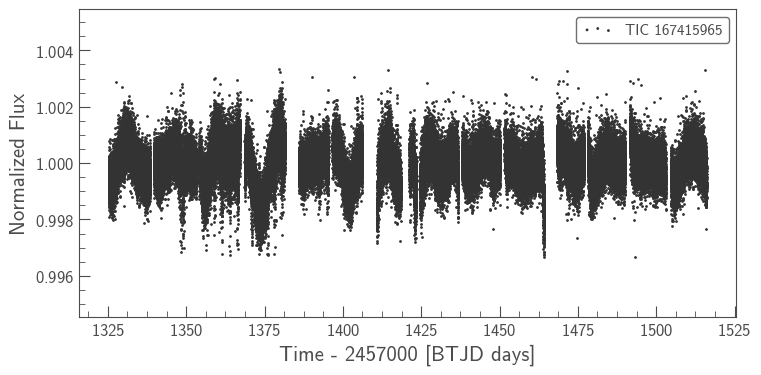

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all()

# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
lc = lc.remove_outliers()
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] *= 1000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -113666.23961572295 -> -94571.25560417645


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean flux of the star,
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -93345.48649427034 -> -83054.22744556023


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -83054.22744556023 -> -83020.24432263007


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -83020.24432263007 -> -83018.8076972246


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -83018.8076972246 -> -83018.48302793519


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -83018.48302793519 -> -83017.77054553687


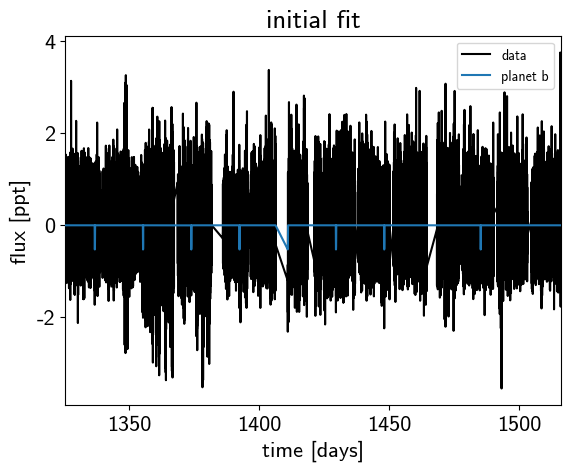

In [7]:
model = build_model(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2)
    trace = sampler.sample(draws=1000, chains=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:01, 75.40draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:16,  5.64draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:03<00:33,  2.67draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:05<00:44,  1.96draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:06<01:11,  1.22draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:06<00:52,  1.65draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:08<01:15,  1.13draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:08<00:54,  1.53draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:09<01:15,  1.09draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:10<00:55,  1.48draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:11<01:15,  1.08draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:11<00:55,  1.45draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:13<01:13,  1.07draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:13<00:54,  1.43draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:14<01:12,  1.07draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:15<00:53,  1.42draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:16<01:10,  1.07draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:16<00:52,  1.40draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:18<01:08,  1.07draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:18<00:51,  1.40draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:19<01:06,  1.07draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:20<00:50,  1.39draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:21<01:04,  1.08draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:21<00:48,  1.39draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:21<00:36,  1.84draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:23<00:55,  1.20draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:23<00:40,  1.61draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:24<00:57,  1.12draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:25<00:41,  1.52draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:26<00:57,  1.08draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:28<00:53,  1.12draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:29<00:50,  1.14draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:31<00:48,  1.16draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:33<00:45,  1.18draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:34<00:43,  1.19draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:36<00:41,  1.20draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:38<00:39,  1.21draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:39<00:37,  1.21draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:41<00:36,  1.22draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:43<00:34,  1.22draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:43<00:24,  1.66draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:44<00:35,  1.14draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:44<00:25,  1.53draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:46<00:34,  1.10draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:46<00:25,  1.48draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:47<00:33,  1.08draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:48<00:24,  1.45draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:48<00:25,  1.32draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:49<00:24,  1.34draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:50<00:25,  1.26draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:51<00:24,  1.28draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:52<00:24,  1.23draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:52<00:23,  1.26draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:53<00:22,  1.22draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:54<00:21,  1.24draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:55<00:21,  1.21draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:56<00:20,  1.24draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:57<00:19,  1.21draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:57<00:18,  1.23draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:58<00:17,  1.29draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:58<00:12,  1.69draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [01:00<00:17,  1.17draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [01:00<00:12,  1.54draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [01:01<00:16,  1.12draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [01:02<00:11,  1.48draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [01:03<00:14,  1.09draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [01:03<00:10,  1.46draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [01:05<00:12,  1.08draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [01:05<00:09,  1.44draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [01:06<00:11,  1.07draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [01:06<00:07,  1.44draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [01:08<00:09,  1.06draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [01:08<00:06,  1.44draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [01:10<00:07,  1.06draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [01:10<00:04,  1.44draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [01:11<00:05,  1.06draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [01:11<00:03,  1.44draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [01:13<00:03,  1.06draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [01:13<00:02,  1.44draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [01:15<00:01,  1.02draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [01:19<00:02,  2.14s/draws]

Sampling 2 chains: 100%|██████████| 104/104 [01:21<00:00,  2.01s/draws]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:01, 87.83draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:16,  5.63draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:03<00:33,  2.68draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:05<00:44,  1.96draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:06<01:13,  1.18draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:08<01:11,  1.19draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:10<01:09,  1.19draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:10<00:50,  1.59draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:11<01:09,  1.16draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:11<00:53,  1.48draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:13<01:10,  1.11draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:13<00:53,  1.43draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:15<01:09,  1.09draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:15<00:53,  1.41draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:16<01:08,  1.08draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:16<00:51,  1.41draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:17<00:41,  1.74draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:18<00:53,  1.32draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:18<00:46,  1.50draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:20<00:57,  1.21draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:20<00:48,  1.40draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:21<00:57,  1.16draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:22<00:48,  1.36draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:22<00:36,  1.79draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:23<00:45,  1.40draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:23<00:42,  1.49draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:25<00:49,  1.26draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:25<00:44,  1.38draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:26<00:50,  1.19draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:27<00:44,  1.33draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:28<00:49,  1.17draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:28<00:43,  1.31draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:29<00:48,  1.15draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:30<00:42,  1.30draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:31<00:47,  1.14draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:32<00:40,  1.30draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:33<00:45,  1.14draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:33<00:39,  1.30draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:34<00:44,  1.13draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:35<00:37,  1.31draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:36<00:42,  1.13draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:37<00:35,  1.31draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:38<00:40,  1.13draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:38<00:34,  1.31draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:39<00:39,  1.12draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:40<00:32,  1.31draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:41<00:37,  1.12draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:42<00:31,  1.32draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:42<00:28,  1.42draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:43<00:26,  1.46draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:44<00:29,  1.28draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:44<00:27,  1.35draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:45<00:29,  1.23draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:46<00:27,  1.29draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:47<00:28,  1.20draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:48<00:26,  1.27draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:48<00:18,  1.71draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:49<00:20,  1.50draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:49<00:21,  1.41draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:50<00:21,  1.34draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:51<00:21,  1.30draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:52<00:21,  1.27draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:53<00:20,  1.25draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:53<00:16,  1.50draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:54<00:20,  1.17draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:55<00:16,  1.42draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:56<00:19,  1.13draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:56<00:15,  1.39draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:58<00:17,  1.15draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:58<00:14,  1.36draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:59<00:15,  1.13draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [01:00<00:12,  1.34draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [01:01<00:14,  1.11draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [01:01<00:11,  1.34draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [01:03<00:12,  1.11draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [01:03<00:09,  1.34draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [01:04<00:10,  1.11draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [01:05<00:08,  1.34draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [01:06<00:09,  1.10draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [01:06<00:06,  1.34draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [01:08<00:07,  1.10draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [01:08<00:05,  1.34draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [01:09<00:05,  1.10draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [01:10<00:03,  1.34draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [01:11<00:03,  1.10draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [01:13<00:03,  1.13s/draws]

Sampling 2 chains:  98%|█████████▊| 102/104 [01:14<00:02,  1.29s/draws]

Sampling 2 chains:  99%|█████████▉| 103/104 [01:16<00:01,  1.49s/draws]

Sampling 2 chains: 100%|██████████| 104/104 [01:21<00:00,  2.43s/draws]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:01<05:37,  1.66s/draws]

Sampling 2 chains:   1%|▏         | 3/204 [00:01<04:01,  1.20s/draws]

Sampling 2 chains:   2%|▏         | 4/204 [00:02<03:37,  1.09s/draws]

Sampling 2 chains:   2%|▏         | 5/204 [00:03<03:20,  1.01s/draws]

Sampling 2 chains:   3%|▎         | 6/204 [00:04<03:08,  1.05draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:04<02:22,  1.37draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:06<02:54,  1.12draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:06<02:22,  1.36draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:07<02:54,  1.10draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:08<02:21,  1.36draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:08<02:06,  1.51draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:09<02:34,  1.23draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:10<02:15,  1.39draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:10<02:15,  1.38draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:11<02:26,  1.28draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:12<02:09,  1.42draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:13<02:06,  1.46draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:14<02:22,  1.28draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:14<01:50,  1.64draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:14<01:25,  2.12draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:15<01:15,  2.38draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:16<02:04,  1.43draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:16<01:43,  1.71draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:18<02:22,  1.24draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:18<01:56,  1.51draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:19<02:30,  1.17draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:20<02:02,  1.42draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:21<02:08,  1.34draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:21<01:34,  1.81draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:21<01:24,  2.02draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:21<01:12,  2.36draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:21<00:55,  3.05draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:23<01:43,  1.63draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:23<01:27,  1.91draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:23<01:06,  2.47draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:25<01:58,  1.38draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:25<01:31,  1.79draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:25<01:09,  2.33draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:25<00:53,  3.02draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:26<01:28,  1.80draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:27<01:13,  2.14draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:27<01:10,  2.21draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:27<00:59,  2.64draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:28<01:16,  2.03draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:28<01:03,  2.41draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:29<01:21,  1.87draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:30<01:17,  1.96draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:31<01:47,  1.40draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:31<01:35,  1.56draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:33<01:58,  1.25draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:33<01:43,  1.42draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:33<01:30,  1.62draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:34<01:11,  2.02draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:34<01:13,  1.97draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:34<00:55,  2.58draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:35<00:49,  2.87draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:35<01:06,  2.12draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:36<01:03,  2.20draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:36<01:03,  2.18draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:37<00:59,  2.33draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:37<01:02,  2.19draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:38<01:14,  1.82draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:38<00:55,  2.41draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:38<00:55,  2.42draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:38<00:42,  3.12draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:39<00:40,  3.24draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:39<00:40,  3.23draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:40<01:09,  1.88draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:41<01:11,  1.80draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:41<01:01,  2.07draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:42<01:10,  1.81draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:42<00:56,  2.23draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:43<01:07,  1.86draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:44<01:02,  1.96draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:44<01:13,  1.66draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:45<01:21,  1.49draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:46<01:22,  1.46draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:46<01:00,  1.96draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:46<00:45,  2.56draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:48<01:21,  1.43draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:48<00:59,  1.92draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:48<00:46,  2.46draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:49<01:23,  1.36draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:50<01:02,  1.78draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:51<01:33,  1.19draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:51<01:10,  1.56draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:53<01:36,  1.12draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:53<01:13,  1.47draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:53<00:57,  1.85draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:55<01:26,  1.23draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:55<01:05,  1.59draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:55<00:52,  1.99draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [00:56<01:15,  1.37draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:56<00:55,  1.84draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:57<00:46,  2.16draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:58<01:13,  1.35draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:58<00:58,  1.68draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [01:00<01:22,  1.19draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [01:00<00:59,  1.62draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [01:00<00:45,  2.12draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [01:00<00:40,  2.36draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [01:01<00:38,  2.42draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [01:01<00:32,  2.85draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [01:01<00:25,  3.57draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [01:02<00:43,  2.10draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [01:03<00:49,  1.81draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [01:03<00:58,  1.51draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [01:04<01:00,  1.46draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [01:05<01:05,  1.33draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [01:06<01:04,  1.32draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [01:06<00:47,  1.79draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [01:06<00:43,  1.94draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [01:08<00:58,  1.42draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [01:08<00:52,  1.56draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [01:09<01:04,  1.25draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [01:10<00:56,  1.42draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [01:10<00:41,  1.91draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [01:10<00:37,  2.06draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [01:11<00:54,  1.40draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [01:12<00:47,  1.60draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [01:13<00:51,  1.47draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [01:13<00:53,  1.38draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [01:14<00:38,  1.86draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [01:14<00:31,  2.28draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [01:14<00:30,  2.33draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [01:15<00:38,  1.78draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [01:15<00:31,  2.19draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [01:16<00:29,  2.25draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [01:16<00:23,  2.81draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [01:16<00:24,  2.66draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [01:18<00:40,  1.59draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [01:18<00:31,  1.99draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [01:18<00:25,  2.42draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [01:20<00:32,  1.86draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [01:21<00:31,  1.86draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [01:21<00:31,  1.82draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [01:22<00:39,  1.41draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [01:23<00:30,  1.79draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [01:23<00:26,  2.02draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [01:24<00:32,  1.62draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [01:24<00:30,  1.70draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [01:25<00:23,  2.18draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [01:26<00:27,  1.75draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [01:26<00:19,  2.36draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [01:28<00:33,  1.36draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [01:28<00:25,  1.76draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [01:29<00:23,  1.86draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [01:30<00:28,  1.47draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [01:30<00:22,  1.86draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [01:30<00:20,  1.99draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [01:31<00:17,  2.25draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [01:31<00:22,  1.69draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [01:32<00:23,  1.60draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [01:33<00:26,  1.38draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [01:33<00:21,  1.67draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [01:34<00:18,  1.87draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [01:35<00:22,  1.47draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [01:35<00:17,  1.81draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [01:36<00:24,  1.24draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [01:37<00:19,  1.55draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [01:37<00:14,  2.07draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [01:37<00:10,  2.71draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [01:37<00:10,  2.61draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [01:37<00:07,  3.34draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [01:38<00:10,  2.49draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [01:39<00:14,  1.70draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [01:40<00:13,  1.67draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [01:41<00:16,  1.37draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [01:41<00:14,  1.44draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [01:42<00:16,  1.25draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [01:43<00:11,  1.69draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [01:43<00:10,  1.79draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [01:45<00:10,  1.57draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [01:46<00:08,  1.62draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [01:46<00:07,  1.65draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [01:47<00:06,  1.79draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [01:48<00:06,  1.59draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [01:48<00:06,  1.44draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [01:49<00:06,  1.37draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [01:50<00:04,  1.74draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [01:50<00:03,  2.31draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [01:50<00:02,  2.18draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [01:50<00:01,  2.62draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [01:51<00:02,  1.95draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [01:51<00:01,  2.53draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [01:52<00:00,  2.97draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [01:52<00:00,  2.17draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/404 [00:00<00:50,  7.93draws/s]

Sampling 2 chains:   1%|          | 3/404 [00:00<00:42,  9.40draws/s]

Sampling 2 chains:   1%|          | 5/404 [00:00<00:36, 10.79draws/s]

Sampling 2 chains:   1%|▏         | 6/404 [00:00<00:43,  9.06draws/s]

Sampling 2 chains:   2%|▏         | 7/404 [00:00<00:42,  9.25draws/s]

Sampling 2 chains:   2%|▏         | 9/404 [00:00<00:42,  9.38draws/s]

Sampling 2 chains:   3%|▎         | 11/404 [00:00<00:35, 11.10draws/s]

Sampling 2 chains:   3%|▎         | 13/404 [00:01<00:32, 12.04draws/s]

Sampling 2 chains:   4%|▎         | 15/404 [00:01<00:28, 13.59draws/s]

Sampling 2 chains:   4%|▍         | 17/404 [00:01<00:30, 12.79draws/s]

Sampling 2 chains:   5%|▍         | 19/404 [00:01<00:34, 11.07draws/s]

Sampling 2 chains:   5%|▌         | 21/404 [00:01<00:47,  7.98draws/s]

Sampling 2 chains:   6%|▌         | 23/404 [00:02<00:43,  8.76draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:02<00:36, 10.49draws/s]

Sampling 2 chains:   7%|▋         | 27/404 [00:02<00:38,  9.77draws/s]

Sampling 2 chains:   7%|▋         | 29/404 [00:02<00:32, 11.41draws/s]

Sampling 2 chains:   8%|▊         | 31/404 [00:02<00:28, 13.01draws/s]

Sampling 2 chains:   8%|▊         | 34/404 [00:02<00:24, 15.14draws/s]

Sampling 2 chains:   9%|▉         | 36/404 [00:02<00:22, 16.22draws/s]

Sampling 2 chains:  10%|▉         | 39/404 [00:03<00:19, 18.49draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:03<00:18, 19.44draws/s]

Sampling 2 chains:  11%|█         | 45/404 [00:03<00:22, 15.75draws/s]

Sampling 2 chains:  12%|█▏        | 47/404 [00:03<00:26, 13.31draws/s]

Sampling 2 chains:  12%|█▏        | 49/404 [00:03<00:24, 14.71draws/s]

Sampling 2 chains:  13%|█▎        | 52/404 [00:03<00:20, 17.30draws/s]

Sampling 2 chains:  14%|█▎        | 55/404 [00:04<00:19, 17.90draws/s]

Sampling 2 chains:  14%|█▍        | 58/404 [00:04<00:20, 16.71draws/s]

Sampling 2 chains:  15%|█▍        | 60/404 [00:04<00:19, 17.45draws/s]

Sampling 2 chains:  15%|█▌        | 62/404 [00:04<00:24, 14.12draws/s]

Sampling 2 chains:  16%|█▌        | 65/404 [00:04<00:20, 16.70draws/s]

Sampling 2 chains:  17%|█▋        | 68/404 [00:04<00:21, 15.91draws/s]

Sampling 2 chains:  18%|█▊        | 71/404 [00:05<00:19, 16.84draws/s]

Sampling 2 chains:  18%|█▊        | 74/404 [00:05<00:17, 19.30draws/s]

Sampling 2 chains:  19%|█▉        | 77/404 [00:05<00:16, 19.71draws/s]

Sampling 2 chains:  20%|█▉        | 80/404 [00:05<00:18, 17.82draws/s]

Sampling 2 chains:  20%|██        | 82/404 [00:05<00:17, 18.27draws/s]

Sampling 2 chains:  21%|██        | 84/404 [00:05<00:17, 18.60draws/s]

Sampling 2 chains:  21%|██▏       | 86/404 [00:05<00:16, 18.84draws/s]

Sampling 2 chains:  22%|██▏       | 89/404 [00:05<00:15, 20.83draws/s]

Sampling 2 chains:  23%|██▎       | 92/404 [00:06<00:19, 15.64draws/s]

Sampling 2 chains:  23%|██▎       | 94/404 [00:06<00:18, 16.61draws/s]

Sampling 2 chains:  24%|██▍       | 97/404 [00:06<00:16, 19.07draws/s]

Sampling 2 chains:  25%|██▍       | 100/404 [00:06<00:16, 18.99draws/s]

Sampling 2 chains:  25%|██▌       | 103/404 [00:06<00:14, 21.22draws/s]

Sampling 2 chains:  26%|██▌       | 106/404 [00:06<00:14, 20.83draws/s]

Sampling 2 chains:  27%|██▋       | 109/404 [00:07<00:15, 18.47draws/s]

Sampling 2 chains:  28%|██▊       | 112/404 [00:07<00:15, 18.67draws/s]

Sampling 2 chains:  28%|██▊       | 114/404 [00:07<00:15, 18.88draws/s]

Sampling 2 chains:  29%|██▊       | 116/404 [00:07<00:15, 18.90draws/s]

Sampling 2 chains:  29%|██▉       | 118/404 [00:07<00:19, 14.76draws/s]

Sampling 2 chains:  30%|██▉       | 120/404 [00:07<00:17, 15.91draws/s]

Sampling 2 chains:  30%|███       | 122/404 [00:07<00:16, 16.86draws/s]

Sampling 2 chains:  31%|███       | 124/404 [00:07<00:15, 17.59draws/s]

Sampling 2 chains:  31%|███       | 126/404 [00:07<00:15, 18.14draws/s]

Sampling 2 chains:  32%|███▏      | 129/404 [00:08<00:13, 20.41draws/s]

Sampling 2 chains:  33%|███▎      | 132/404 [00:08<00:13, 20.13draws/s]

Sampling 2 chains:  33%|███▎      | 135/404 [00:08<00:14, 18.18draws/s]

Sampling 2 chains:  34%|███▍      | 137/404 [00:08<00:14, 18.57draws/s]

Sampling 2 chains:  34%|███▍      | 139/404 [00:08<00:16, 16.49draws/s]

Sampling 2 chains:  35%|███▍      | 141/404 [00:08<00:17, 15.29draws/s]

Sampling 2 chains:  36%|███▌      | 144/404 [00:08<00:14, 17.86draws/s]

Sampling 2 chains:  36%|███▋      | 147/404 [00:09<00:12, 20.23draws/s]

Sampling 2 chains:  37%|███▋      | 150/404 [00:09<00:13, 18.17draws/s]

Sampling 2 chains:  38%|███▊      | 153/404 [00:09<00:14, 16.97draws/s]

Sampling 2 chains:  38%|███▊      | 155/404 [00:09<00:14, 17.68draws/s]

Sampling 2 chains:  39%|███▉      | 157/404 [00:09<00:16, 15.43draws/s]

Sampling 2 chains:  39%|███▉      | 159/404 [00:09<00:14, 16.46draws/s]

Sampling 2 chains:  40%|███▉      | 161/404 [00:09<00:14, 17.26draws/s]

Sampling 2 chains:  40%|████      | 163/404 [00:10<00:13, 17.87draws/s]

Sampling 2 chains:  41%|████      | 166/404 [00:10<00:12, 19.23draws/s]

Sampling 2 chains:  42%|████▏     | 169/404 [00:10<00:11, 20.97draws/s]

Sampling 2 chains:  43%|████▎     | 172/404 [00:10<00:10, 22.95draws/s]

Sampling 2 chains:  43%|████▎     | 175/404 [00:10<00:10, 22.23draws/s]

Sampling 2 chains:  44%|████▍     | 178/404 [00:10<00:09, 23.48draws/s]

Sampling 2 chains:  45%|████▍     | 181/404 [00:10<00:10, 22.14draws/s]

Sampling 2 chains:  46%|████▌     | 184/404 [00:10<00:10, 21.30draws/s]

Sampling 2 chains:  46%|████▋     | 187/404 [00:11<00:11, 18.75draws/s]

Sampling 2 chains:  47%|████▋     | 189/404 [00:11<00:12, 16.57draws/s]

Sampling 2 chains:  48%|████▊     | 192/404 [00:11<00:12, 17.55draws/s]

Sampling 2 chains:  48%|████▊     | 194/404 [00:11<00:13, 15.54draws/s]

Sampling 2 chains:  49%|████▊     | 196/404 [00:11<00:13, 14.90draws/s]

Sampling 2 chains:  49%|████▉     | 198/404 [00:11<00:12, 16.02draws/s]

Sampling 2 chains:  50%|████▉     | 200/404 [00:12<00:15, 13.43draws/s]

Sampling 2 chains:  50%|█████     | 202/404 [00:12<00:13, 14.80draws/s]

Sampling 2 chains:  50%|█████     | 204/404 [00:12<00:14, 14.14draws/s]

Sampling 2 chains:  51%|█████     | 206/404 [00:12<00:12, 15.43draws/s]

Sampling 2 chains:  51%|█████▏    | 208/404 [00:12<00:11, 16.48draws/s]

Sampling 2 chains:  52%|█████▏    | 210/404 [00:12<00:11, 17.30draws/s]

Sampling 2 chains:  52%|█████▏    | 212/404 [00:12<00:10, 17.93draws/s]

Sampling 2 chains:  53%|█████▎    | 215/404 [00:12<00:10, 18.39draws/s]

Sampling 2 chains:  54%|█████▍    | 218/404 [00:13<00:08, 20.72draws/s]

Sampling 2 chains:  55%|█████▍    | 221/404 [00:13<00:08, 22.72draws/s]

Sampling 2 chains:  55%|█████▌    | 224/404 [00:13<00:08, 21.66draws/s]

Sampling 2 chains:  56%|█████▌    | 227/404 [00:13<00:08, 19.73draws/s]

Sampling 2 chains:  57%|█████▋    | 230/404 [00:13<00:09, 17.73draws/s]

Sampling 2 chains:  57%|█████▋    | 232/404 [00:13<00:09, 18.18draws/s]

Sampling 2 chains:  58%|█████▊    | 234/404 [00:13<00:09, 17.89draws/s]

Sampling 2 chains:  58%|█████▊    | 236/404 [00:13<00:09, 18.36draws/s]

Sampling 2 chains:  59%|█████▉    | 238/404 [00:14<00:09, 16.87draws/s]

Sampling 2 chains:  59%|█████▉    | 240/404 [00:14<00:10, 15.08draws/s]

Sampling 2 chains:  60%|██████    | 243/404 [00:14<00:09, 16.48draws/s]

Sampling 2 chains:  61%|██████    | 245/404 [00:14<00:09, 17.28draws/s]

Sampling 2 chains:  62%|██████▏   | 249/404 [00:14<00:07, 20.42draws/s]

Sampling 2 chains:  62%|██████▏   | 252/404 [00:14<00:08, 18.28draws/s]

Sampling 2 chains:  63%|██████▎   | 255/404 [00:15<00:10, 14.66draws/s]

Sampling 2 chains:  64%|██████▎   | 257/404 [00:15<00:09, 15.62draws/s]

Sampling 2 chains:  64%|██████▍   | 259/404 [00:15<00:22,  6.56draws/s]

Sampling 2 chains:  65%|██████▍   | 261/404 [00:16<00:17,  8.19draws/s]

Sampling 2 chains:  65%|██████▌   | 263/404 [00:16<00:16,  8.67draws/s]

Sampling 2 chains:  66%|██████▌   | 265/404 [00:16<00:15,  8.97draws/s]

Sampling 2 chains:  66%|██████▌   | 267/404 [00:16<00:18,  7.57draws/s]

Sampling 2 chains:  67%|██████▋   | 269/404 [00:16<00:14,  9.28draws/s]

Sampling 2 chains:  67%|██████▋   | 271/404 [00:17<00:13, 10.16draws/s]

Sampling 2 chains:  68%|██████▊   | 273/404 [00:17<00:12, 10.87draws/s]

Sampling 2 chains:  68%|██████▊   | 275/404 [00:17<00:10, 12.55draws/s]

Sampling 2 chains:  69%|██████▊   | 277/404 [00:17<00:09, 14.06draws/s]

Sampling 2 chains:  69%|██████▉   | 280/404 [00:17<00:08, 15.36draws/s]

Sampling 2 chains:  70%|███████   | 284/404 [00:17<00:06, 17.53draws/s]

Sampling 2 chains:  71%|███████   | 286/404 [00:17<00:06, 18.10draws/s]

Sampling 2 chains:  71%|███████▏  | 288/404 [00:17<00:06, 18.52draws/s]

Sampling 2 chains:  72%|███████▏  | 291/404 [00:18<00:05, 20.82draws/s]

Sampling 2 chains:  73%|███████▎  | 294/404 [00:18<00:04, 22.53draws/s]

Sampling 2 chains:  74%|███████▎  | 297/404 [00:18<00:04, 21.59draws/s]

Sampling 2 chains:  74%|███████▍  | 300/404 [00:18<00:05, 18.93draws/s]

Sampling 2 chains:  75%|███████▌  | 303/404 [00:18<00:05, 17.40draws/s]

Sampling 2 chains:  75%|███████▌  | 305/404 [00:18<00:06, 15.82draws/s]

Sampling 2 chains:  76%|███████▌  | 307/404 [00:19<00:07, 13.16draws/s]

Sampling 2 chains:  76%|███████▋  | 309/404 [00:19<00:07, 12.08draws/s]

Sampling 2 chains:  77%|███████▋  | 311/404 [00:19<00:06, 13.42draws/s]

Sampling 2 chains:  77%|███████▋  | 313/404 [00:19<00:06, 14.79draws/s]

Sampling 2 chains:  78%|███████▊  | 315/404 [00:19<00:06, 13.07draws/s]

Sampling 2 chains:  79%|███████▉  | 319/404 [00:19<00:05, 16.33draws/s]

Sampling 2 chains:  80%|███████▉  | 322/404 [00:19<00:04, 16.85draws/s]

Sampling 2 chains:  81%|████████  | 326/404 [00:20<00:04, 18.83draws/s]

Sampling 2 chains:  81%|████████▏ | 329/404 [00:20<00:04, 17.33draws/s]

Sampling 2 chains:  82%|████████▏ | 332/404 [00:20<00:03, 19.74draws/s]

Sampling 2 chains:  83%|████████▎ | 335/404 [00:20<00:03, 20.22draws/s]

Sampling 2 chains:  84%|████████▎ | 338/404 [00:20<00:03, 21.59draws/s]

Sampling 2 chains:  84%|████████▍ | 341/404 [00:20<00:02, 21.58draws/s]

Sampling 2 chains:  85%|████████▌ | 344/404 [00:20<00:02, 22.62draws/s]

Sampling 2 chains:  86%|████████▌ | 347/404 [00:21<00:02, 19.42draws/s]

Sampling 2 chains:  87%|████████▋ | 350/404 [00:21<00:02, 18.27draws/s]

Sampling 2 chains:  87%|████████▋ | 353/404 [00:21<00:02, 20.60draws/s]

Sampling 2 chains:  88%|████████▊ | 356/404 [00:21<00:03, 15.48draws/s]

Sampling 2 chains:  89%|████████▊ | 358/404 [00:21<00:03, 14.66draws/s]

Sampling 2 chains:  89%|████████▉ | 360/404 [00:22<00:02, 14.93draws/s]

Sampling 2 chains:  90%|████████▉ | 362/404 [00:22<00:02, 16.03draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [00:22<00:02, 13.43draws/s]

Sampling 2 chains:  91%|█████████ | 366/404 [00:22<00:03, 12.06draws/s]

Sampling 2 chains:  91%|█████████ | 368/404 [00:22<00:03, 11.27draws/s]

Sampling 2 chains:  92%|█████████▏| 370/404 [00:22<00:02, 12.41draws/s]

Sampling 2 chains:  92%|█████████▏| 372/404 [00:22<00:02, 13.94draws/s]

Sampling 2 chains:  93%|█████████▎| 374/404 [00:23<00:02, 12.37draws/s]

Sampling 2 chains:  93%|█████████▎| 376/404 [00:23<00:02, 13.91draws/s]

Sampling 2 chains:  94%|█████████▎| 378/404 [00:23<00:01, 15.10draws/s]

Sampling 2 chains:  94%|█████████▍| 380/404 [00:23<00:01, 12.24draws/s]

Sampling 2 chains:  95%|█████████▍| 382/404 [00:23<00:01, 11.37draws/s]

Sampling 2 chains:  95%|█████████▌| 384/404 [00:23<00:01, 11.81draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [00:24<00:01, 13.38draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [00:24<00:01, 11.59draws/s]

Sampling 2 chains:  97%|█████████▋| 390/404 [00:24<00:01, 10.91draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [00:24<00:01, 10.40draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [00:24<00:00, 12.06draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [00:24<00:00, 12.30draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [00:25<00:00, 11.35draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [00:25<00:00,  9.96draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [00:25<00:00, 10.68draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:25<00:00, 11.20draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/804 [00:00<01:42,  7.86draws/s]

Sampling 2 chains:   1%|          | 5/804 [00:00<01:18, 10.22draws/s]

Sampling 2 chains:   1%|          | 7/804 [00:00<01:06, 11.92draws/s]

Sampling 2 chains:   1%|          | 9/804 [00:00<01:01, 12.98draws/s]

Sampling 2 chains:   1%|▏         | 11/804 [00:00<00:57, 13.81draws/s]

Sampling 2 chains:   2%|▏         | 13/804 [00:00<00:52, 15.08draws/s]

Sampling 2 chains:   2%|▏         | 16/804 [00:00<00:44, 17.60draws/s]

Sampling 2 chains:   2%|▏         | 20/804 [00:00<00:37, 21.02draws/s]

Sampling 2 chains:   3%|▎         | 24/804 [00:01<00:32, 24.29draws/s]

Sampling 2 chains:   3%|▎         | 27/804 [00:01<00:30, 25.51draws/s]

Sampling 2 chains:   4%|▎         | 30/804 [00:01<00:29, 26.46draws/s]

Sampling 2 chains:   4%|▍         | 33/804 [00:01<00:32, 23.78draws/s]

Sampling 2 chains:   4%|▍         | 36/804 [00:01<00:34, 22.33draws/s]

Sampling 2 chains:   5%|▍         | 39/804 [00:01<00:46, 16.29draws/s]

Sampling 2 chains:   5%|▌         | 41/804 [00:01<00:46, 16.57draws/s]

Sampling 2 chains:   5%|▌         | 43/804 [00:02<00:43, 17.36draws/s]

Sampling 2 chains:   6%|▌         | 45/804 [00:02<00:47, 16.02draws/s]

Sampling 2 chains:   6%|▌         | 47/804 [00:02<00:44, 16.86draws/s]

Sampling 2 chains:   6%|▌         | 49/804 [00:02<00:43, 17.52draws/s]

Sampling 2 chains:   6%|▋         | 52/804 [00:02<00:42, 17.71draws/s]

Sampling 2 chains:   7%|▋         | 54/804 [00:02<00:46, 15.99draws/s]

Sampling 2 chains:   7%|▋         | 56/804 [00:02<00:44, 16.92draws/s]

Sampling 2 chains:   7%|▋         | 59/804 [00:03<00:45, 16.20draws/s]

Sampling 2 chains:   8%|▊         | 61/804 [00:03<00:43, 17.01draws/s]

Sampling 2 chains:   8%|▊         | 63/804 [00:03<00:51, 14.44draws/s]

Sampling 2 chains:   8%|▊         | 65/804 [00:03<00:54, 13.50draws/s]

Sampling 2 chains:   8%|▊         | 67/804 [00:03<01:12, 10.17draws/s]

Sampling 2 chains:   9%|▊         | 69/804 [00:03<01:06, 11.10draws/s]

Sampling 2 chains:   9%|▉         | 72/804 [00:04<00:53, 13.61draws/s]

Sampling 2 chains:   9%|▉         | 75/804 [00:04<00:45, 15.94draws/s]

Sampling 2 chains:  10%|▉         | 78/804 [00:04<00:39, 18.48draws/s]

Sampling 2 chains:  10%|█         | 81/804 [00:04<00:34, 20.80draws/s]

Sampling 2 chains:  10%|█         | 84/804 [00:04<00:31, 22.81draws/s]

Sampling 2 chains:  11%|█         | 87/804 [00:04<00:29, 24.45draws/s]

Sampling 2 chains:  11%|█▏        | 91/804 [00:04<00:25, 27.56draws/s]

Sampling 2 chains:  12%|█▏        | 95/804 [00:04<00:23, 30.06draws/s]

Sampling 2 chains:  12%|█▏        | 99/804 [00:04<00:21, 32.27draws/s]

Sampling 2 chains:  13%|█▎        | 103/804 [00:04<00:21, 33.27draws/s]

Sampling 2 chains:  13%|█▎        | 107/804 [00:05<00:20, 33.36draws/s]

Sampling 2 chains:  14%|█▍        | 111/804 [00:05<00:23, 29.90draws/s]

Sampling 2 chains:  14%|█▍        | 115/804 [00:05<00:23, 29.06draws/s]

Sampling 2 chains:  15%|█▍        | 119/804 [00:05<00:22, 30.71draws/s]

Sampling 2 chains:  15%|█▌        | 123/804 [00:05<00:22, 29.89draws/s]

Sampling 2 chains:  16%|█▌        | 127/804 [00:05<00:22, 30.72draws/s]

Sampling 2 chains:  16%|█▋        | 131/804 [00:05<00:23, 28.82draws/s]

Sampling 2 chains:  17%|█▋        | 134/804 [00:06<00:23, 28.87draws/s]

Sampling 2 chains:  17%|█▋        | 137/804 [00:06<00:26, 25.36draws/s]

Sampling 2 chains:  18%|█▊        | 141/804 [00:06<00:23, 28.29draws/s]

Sampling 2 chains:  18%|█▊        | 145/804 [00:06<00:21, 30.76draws/s]

Sampling 2 chains:  19%|█▊        | 149/804 [00:06<00:25, 26.09draws/s]

Sampling 2 chains:  19%|█▉        | 152/804 [00:06<00:24, 26.89draws/s]

Sampling 2 chains:  19%|█▉        | 155/804 [00:06<00:23, 27.38draws/s]

Sampling 2 chains:  20%|█▉        | 158/804 [00:06<00:26, 24.62draws/s]

Sampling 2 chains:  20%|██        | 162/804 [00:07<00:23, 27.65draws/s]

Sampling 2 chains:  21%|██        | 165/804 [00:07<00:25, 25.23draws/s]

Sampling 2 chains:  21%|██        | 168/804 [00:07<00:30, 20.65draws/s]

Sampling 2 chains:  21%|██▏       | 171/804 [00:07<00:34, 18.32draws/s]

Sampling 2 chains:  22%|██▏       | 174/804 [00:07<00:37, 16.81draws/s]

Sampling 2 chains:  22%|██▏       | 176/804 [00:07<00:35, 17.62draws/s]

Sampling 2 chains:  22%|██▏       | 179/804 [00:08<00:31, 19.98draws/s]

Sampling 2 chains:  23%|██▎       | 182/804 [00:08<00:28, 22.00draws/s]

Sampling 2 chains:  23%|██▎       | 185/804 [00:08<00:26, 23.69draws/s]

Sampling 2 chains:  23%|██▎       | 188/804 [00:08<00:27, 22.47draws/s]

Sampling 2 chains:  24%|██▍       | 191/804 [00:08<00:31, 19.37draws/s]

Sampling 2 chains:  24%|██▍       | 194/804 [00:08<00:29, 20.44draws/s]

Sampling 2 chains:  25%|██▍       | 197/804 [00:08<00:26, 22.48draws/s]

Sampling 2 chains:  25%|██▌       | 201/804 [00:09<00:25, 23.48draws/s]

Sampling 2 chains:  25%|██▌       | 204/804 [00:09<00:26, 22.70draws/s]

Sampling 2 chains:  26%|██▌       | 208/804 [00:09<00:23, 25.69draws/s]

Sampling 2 chains:  26%|██▌       | 211/804 [00:09<00:22, 26.56draws/s]

Sampling 2 chains:  27%|██▋       | 214/804 [00:09<00:24, 23.86draws/s]

Sampling 2 chains:  27%|██▋       | 217/804 [00:09<00:23, 25.31draws/s]

Sampling 2 chains:  27%|██▋       | 220/804 [00:09<00:22, 26.40draws/s]

Sampling 2 chains:  28%|██▊       | 223/804 [00:09<00:21, 27.05draws/s]

Sampling 2 chains:  28%|██▊       | 226/804 [00:10<00:26, 21.59draws/s]

Sampling 2 chains:  28%|██▊       | 229/804 [00:10<00:24, 23.09draws/s]

Sampling 2 chains:  29%|██▉       | 232/804 [00:10<00:29, 19.63draws/s]

Sampling 2 chains:  29%|██▉       | 235/804 [00:10<00:31, 18.12draws/s]

Sampling 2 chains:  30%|██▉       | 238/804 [00:10<00:27, 20.48draws/s]

Sampling 2 chains:  30%|██▉       | 241/804 [00:10<00:25, 22.52draws/s]

Sampling 2 chains:  30%|███       | 244/804 [00:10<00:23, 24.13draws/s]

Sampling 2 chains:  31%|███       | 248/804 [00:10<00:21, 25.91draws/s]

Sampling 2 chains:  31%|███       | 251/804 [00:11<00:22, 24.95draws/s]

Sampling 2 chains:  32%|███▏      | 255/804 [00:11<00:19, 27.91draws/s]

Sampling 2 chains:  32%|███▏      | 259/804 [00:11<00:17, 30.45draws/s]

Sampling 2 chains:  33%|███▎      | 263/804 [00:11<00:18, 28.85draws/s]

Sampling 2 chains:  33%|███▎      | 267/804 [00:11<00:17, 31.22draws/s]

Sampling 2 chains:  34%|███▎      | 271/804 [00:11<00:16, 33.11draws/s]

Sampling 2 chains:  34%|███▍      | 275/804 [00:11<00:15, 34.58draws/s]

Sampling 2 chains:  35%|███▍      | 279/804 [00:11<00:17, 30.24draws/s]

Sampling 2 chains:  35%|███▌      | 283/804 [00:12<00:18, 28.85draws/s]

Sampling 2 chains:  36%|███▌      | 287/804 [00:12<00:18, 28.63draws/s]

Sampling 2 chains:  36%|███▌      | 291/804 [00:12<00:16, 31.04draws/s]

Sampling 2 chains:  37%|███▋      | 295/804 [00:12<00:17, 29.22draws/s]

Sampling 2 chains:  37%|███▋      | 300/804 [00:12<00:15, 33.14draws/s]

Sampling 2 chains:  38%|███▊      | 304/804 [00:12<00:14, 34.61draws/s]

Sampling 2 chains:  38%|███▊      | 308/804 [00:12<00:16, 29.40draws/s]

Sampling 2 chains:  39%|███▉      | 312/804 [00:13<00:16, 29.78draws/s]

Sampling 2 chains:  39%|███▉      | 316/804 [00:13<00:16, 30.40draws/s]

Sampling 2 chains:  40%|███▉      | 320/804 [00:13<00:14, 32.59draws/s]

Sampling 2 chains:  40%|████      | 324/804 [00:13<00:15, 31.54draws/s]

Sampling 2 chains:  41%|████      | 328/804 [00:13<00:14, 32.15draws/s]

Sampling 2 chains:  41%|████▏     | 332/804 [00:13<00:15, 30.92draws/s]

Sampling 2 chains:  42%|████▏     | 336/804 [00:13<00:16, 29.17draws/s]

Sampling 2 chains:  42%|████▏     | 340/804 [00:13<00:14, 31.48draws/s]

Sampling 2 chains:  43%|████▎     | 344/804 [00:14<00:15, 29.07draws/s]

Sampling 2 chains:  43%|████▎     | 348/804 [00:14<00:14, 30.59draws/s]

Sampling 2 chains:  44%|████▍     | 352/804 [00:14<00:14, 31.99draws/s]

Sampling 2 chains:  44%|████▍     | 356/804 [00:14<00:14, 31.19draws/s]

Sampling 2 chains:  45%|████▍     | 360/804 [00:14<00:14, 31.54draws/s]

Sampling 2 chains:  45%|████▌     | 364/804 [00:14<00:13, 33.37draws/s]

Sampling 2 chains:  46%|████▌     | 368/804 [00:14<00:15, 27.40draws/s]

Sampling 2 chains:  46%|████▌     | 371/804 [00:14<00:16, 26.11draws/s]

Sampling 2 chains:  47%|████▋     | 375/804 [00:15<00:17, 24.45draws/s]

Sampling 2 chains:  47%|████▋     | 378/804 [00:15<00:16, 25.63draws/s]

Sampling 2 chains:  48%|████▊     | 382/804 [00:15<00:14, 28.49draws/s]

Sampling 2 chains:  48%|████▊     | 386/804 [00:15<00:13, 30.16draws/s]

Sampling 2 chains:  49%|████▊     | 390/804 [00:15<00:12, 32.39draws/s]

Sampling 2 chains:  49%|████▉     | 394/804 [00:15<00:12, 32.62draws/s]

Sampling 2 chains:  50%|████▉     | 398/804 [00:15<00:13, 30.21draws/s]

Sampling 2 chains:  50%|█████     | 402/804 [00:16<00:14, 27.06draws/s]

Sampling 2 chains:  50%|█████     | 405/804 [00:16<00:14, 27.69draws/s]

Sampling 2 chains:  51%|█████     | 408/804 [00:16<00:14, 28.18draws/s]

Sampling 2 chains:  51%|█████     | 411/804 [00:16<00:14, 26.49draws/s]

Sampling 2 chains:  51%|█████▏    | 414/804 [00:16<00:15, 25.33draws/s]

Sampling 2 chains:  52%|█████▏    | 417/804 [00:16<00:15, 24.70draws/s]

Sampling 2 chains:  52%|█████▏    | 420/804 [00:16<00:17, 21.66draws/s]

Sampling 2 chains:  53%|█████▎    | 423/804 [00:16<00:16, 23.52draws/s]

Sampling 2 chains:  53%|█████▎    | 426/804 [00:17<00:15, 25.02draws/s]

Sampling 2 chains:  53%|█████▎    | 429/804 [00:17<00:15, 24.06draws/s]

Sampling 2 chains:  54%|█████▎    | 432/804 [00:17<00:17, 21.68draws/s]

Sampling 2 chains:  54%|█████▍    | 435/804 [00:17<00:15, 23.53draws/s]

Sampling 2 chains:  54%|█████▍    | 438/804 [00:17<00:17, 20.35draws/s]

Sampling 2 chains:  55%|█████▍    | 441/804 [00:17<00:16, 22.35draws/s]

Sampling 2 chains:  55%|█████▌    | 445/804 [00:17<00:14, 25.20draws/s]

Sampling 2 chains:  56%|█████▌    | 449/804 [00:17<00:12, 28.20draws/s]

Sampling 2 chains:  56%|█████▋    | 453/804 [00:18<00:12, 27.54draws/s]

Sampling 2 chains:  57%|█████▋    | 456/804 [00:18<00:12, 28.05draws/s]

Sampling 2 chains:  57%|█████▋    | 459/804 [00:18<00:13, 24.83draws/s]

Sampling 2 chains:  57%|█████▋    | 462/804 [00:18<00:14, 22.94draws/s]

Sampling 2 chains:  58%|█████▊    | 465/804 [00:18<00:13, 24.47draws/s]

Sampling 2 chains:  58%|█████▊    | 468/804 [00:18<00:13, 25.75draws/s]

Sampling 2 chains:  59%|█████▊    | 472/804 [00:18<00:11, 28.69draws/s]

Sampling 2 chains:  59%|█████▉    | 476/804 [00:18<00:10, 31.18draws/s]

Sampling 2 chains:  60%|█████▉    | 480/804 [00:19<00:11, 29.44draws/s]

Sampling 2 chains:  60%|██████    | 484/804 [00:19<00:11, 28.89draws/s]

Sampling 2 chains:  61%|██████    | 487/804 [00:19<00:12, 25.15draws/s]

Sampling 2 chains:  61%|██████    | 491/804 [00:19<00:11, 28.07draws/s]

Sampling 2 chains:  62%|██████▏   | 495/804 [00:19<00:10, 30.34draws/s]

Sampling 2 chains:  62%|██████▏   | 499/804 [00:19<00:11, 26.05draws/s]

Sampling 2 chains:  62%|██████▏   | 502/804 [00:19<00:12, 23.58draws/s]

Sampling 2 chains:  63%|██████▎   | 505/804 [00:20<00:11, 24.98draws/s]

Sampling 2 chains:  63%|██████▎   | 508/804 [00:20<00:11, 26.05draws/s]

Sampling 2 chains:  64%|██████▎   | 511/804 [00:20<00:12, 23.56draws/s]

Sampling 2 chains:  64%|██████▍   | 515/804 [00:20<00:11, 24.64draws/s]

Sampling 2 chains:  64%|██████▍   | 518/804 [00:20<00:11, 25.90draws/s]

Sampling 2 chains:  65%|██████▍   | 522/804 [00:20<00:10, 27.99draws/s]

Sampling 2 chains:  65%|██████▌   | 526/804 [00:20<00:09, 28.20draws/s]

Sampling 2 chains:  66%|██████▌   | 529/804 [00:20<00:11, 24.95draws/s]

Sampling 2 chains:  66%|██████▌   | 532/804 [00:21<00:10, 26.11draws/s]

Sampling 2 chains:  67%|██████▋   | 535/804 [00:21<00:09, 27.01draws/s]

Sampling 2 chains:  67%|██████▋   | 538/804 [00:21<00:10, 25.86draws/s]

Sampling 2 chains:  67%|██████▋   | 542/804 [00:21<00:09, 28.70draws/s]

Sampling 2 chains:  68%|██████▊   | 546/804 [00:21<00:08, 29.40draws/s]

Sampling 2 chains:  68%|██████▊   | 550/804 [00:21<00:09, 25.46draws/s]

Sampling 2 chains:  69%|██████▉   | 553/804 [00:21<00:09, 26.52draws/s]

Sampling 2 chains:  69%|██████▉   | 556/804 [00:21<00:10, 23.95draws/s]

Sampling 2 chains:  70%|██████▉   | 559/804 [00:22<00:10, 22.44draws/s]

Sampling 2 chains:  70%|██████▉   | 562/804 [00:22<00:10, 24.15draws/s]

Sampling 2 chains:  70%|███████   | 565/804 [00:22<00:09, 24.38draws/s]

Sampling 2 chains:  71%|███████   | 568/804 [00:22<00:09, 23.70draws/s]

Sampling 2 chains:  71%|███████   | 571/804 [00:22<00:09, 25.13draws/s]

Sampling 2 chains:  72%|███████▏  | 575/804 [00:22<00:09, 25.42draws/s]

Sampling 2 chains:  72%|███████▏  | 579/804 [00:22<00:08, 25.71draws/s]

Sampling 2 chains:  72%|███████▏  | 582/804 [00:23<00:09, 23.47draws/s]

Sampling 2 chains:  73%|███████▎  | 585/804 [00:23<00:08, 24.97draws/s]

Sampling 2 chains:  73%|███████▎  | 588/804 [00:23<00:08, 25.81draws/s]

Sampling 2 chains:  74%|███████▎  | 591/804 [00:23<00:07, 26.66draws/s]

Sampling 2 chains:  74%|███████▍  | 594/804 [00:23<00:07, 27.33draws/s]

Sampling 2 chains:  74%|███████▍  | 597/804 [00:23<00:07, 27.79draws/s]

Sampling 2 chains:  75%|███████▍  | 600/804 [00:23<00:07, 28.14draws/s]

Sampling 2 chains:  75%|███████▌  | 603/804 [00:23<00:07, 28.38draws/s]

Sampling 2 chains:  75%|███████▌  | 606/804 [00:23<00:07, 25.80draws/s]

Sampling 2 chains:  76%|███████▌  | 609/804 [00:24<00:07, 26.78draws/s]

Sampling 2 chains:  76%|███████▌  | 612/804 [00:24<00:08, 21.49draws/s]

Sampling 2 chains:  76%|███████▋  | 615/804 [00:24<00:08, 22.11draws/s]

Sampling 2 chains:  77%|███████▋  | 618/804 [00:24<00:09, 20.17draws/s]

Sampling 2 chains:  77%|███████▋  | 621/804 [00:24<00:09, 20.20draws/s]

Sampling 2 chains:  78%|███████▊  | 624/804 [00:24<00:09, 19.62draws/s]

Sampling 2 chains:  78%|███████▊  | 627/804 [00:24<00:08, 21.78draws/s]

Sampling 2 chains:  78%|███████▊  | 630/804 [00:25<00:08, 20.93draws/s]

Sampling 2 chains:  79%|███████▊  | 633/804 [00:25<00:08, 20.65draws/s]

Sampling 2 chains:  79%|███████▉  | 636/804 [00:25<00:07, 22.68draws/s]

Sampling 2 chains:  79%|███████▉  | 639/804 [00:25<00:08, 19.50draws/s]

Sampling 2 chains:  80%|███████▉  | 642/804 [00:25<00:07, 21.69draws/s]

Sampling 2 chains:  80%|████████  | 645/804 [00:25<00:07, 21.00draws/s]

Sampling 2 chains:  81%|████████  | 648/804 [00:25<00:06, 22.97draws/s]

Sampling 2 chains:  81%|████████  | 651/804 [00:26<00:06, 21.91draws/s]

Sampling 2 chains:  81%|████████▏ | 654/804 [00:26<00:06, 23.65draws/s]

Sampling 2 chains:  82%|████████▏ | 657/804 [00:26<00:05, 25.00draws/s]

Sampling 2 chains:  82%|████████▏ | 660/804 [00:26<00:05, 26.06draws/s]

Sampling 2 chains:  83%|████████▎ | 664/804 [00:26<00:05, 26.23draws/s]

Sampling 2 chains:  83%|████████▎ | 667/804 [00:26<00:05, 27.10draws/s]

Sampling 2 chains:  83%|████████▎ | 670/804 [00:26<00:05, 24.27draws/s]

Sampling 2 chains:  84%|████████▎ | 673/804 [00:26<00:05, 23.34draws/s]

Sampling 2 chains:  84%|████████▍ | 677/804 [00:27<00:04, 26.48draws/s]

Sampling 2 chains:  85%|████████▍ | 680/804 [00:27<00:04, 27.20draws/s]

Sampling 2 chains:  85%|████████▍ | 683/804 [00:27<00:04, 27.69draws/s]

Sampling 2 chains:  85%|████████▌ | 686/804 [00:27<00:04, 28.03draws/s]

Sampling 2 chains:  86%|████████▌ | 691/804 [00:27<00:03, 32.04draws/s]

Sampling 2 chains:  86%|████████▋ | 695/804 [00:27<00:03, 29.64draws/s]

Sampling 2 chains:  87%|████████▋ | 699/804 [00:27<00:03, 28.51draws/s]

Sampling 2 chains:  87%|████████▋ | 703/804 [00:27<00:03, 29.16draws/s]

Sampling 2 chains:  88%|████████▊ | 707/804 [00:28<00:03, 31.46draws/s]

Sampling 2 chains:  88%|████████▊ | 711/804 [00:28<00:03, 29.50draws/s]

Sampling 2 chains:  89%|████████▉ | 715/804 [00:28<00:03, 28.26draws/s]

Sampling 2 chains:  89%|████████▉ | 718/804 [00:28<00:03, 22.00draws/s]

Sampling 2 chains:  90%|████████▉ | 721/804 [00:28<00:03, 22.94draws/s]

Sampling 2 chains:  90%|█████████ | 724/804 [00:28<00:03, 21.83draws/s]

Sampling 2 chains:  90%|█████████ | 727/804 [00:28<00:03, 21.53draws/s]

Sampling 2 chains:  91%|█████████ | 730/804 [00:29<00:03, 20.82draws/s]

Sampling 2 chains:  91%|█████████ | 733/804 [00:29<00:03, 22.72draws/s]

Sampling 2 chains:  92%|█████████▏| 736/804 [00:29<00:02, 23.99draws/s]

Sampling 2 chains:  92%|█████████▏| 739/804 [00:29<00:02, 22.48draws/s]

Sampling 2 chains:  92%|█████████▏| 742/804 [00:29<00:02, 21.56draws/s]

Sampling 2 chains:  93%|█████████▎| 746/804 [00:29<00:02, 22.70draws/s]

Sampling 2 chains:  93%|█████████▎| 750/804 [00:29<00:02, 25.96draws/s]

Sampling 2 chains:  94%|█████████▍| 754/804 [00:29<00:01, 28.59draws/s]

Sampling 2 chains:  94%|█████████▍| 758/804 [00:30<00:01, 28.06draws/s]

Sampling 2 chains:  95%|█████████▍| 761/804 [00:30<00:01, 28.47draws/s]

Sampling 2 chains:  95%|█████████▌| 764/804 [00:30<00:01, 28.73draws/s]

Sampling 2 chains:  96%|█████████▌| 768/804 [00:30<00:01, 30.29draws/s]

Sampling 2 chains:  96%|█████████▌| 772/804 [00:30<00:01, 26.71draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [00:30<00:00, 29.51draws/s]

Sampling 2 chains:  97%|█████████▋| 780/804 [00:30<00:00, 30.46draws/s]

Sampling 2 chains:  98%|█████████▊| 784/804 [00:31<00:00, 28.86draws/s]

Sampling 2 chains:  98%|█████████▊| 787/804 [00:31<00:00, 25.12draws/s]

Sampling 2 chains:  98%|█████████▊| 790/804 [00:31<00:00, 23.02draws/s]

Sampling 2 chains:  99%|█████████▊| 793/804 [00:31<00:00, 21.75draws/s]

Sampling 2 chains:  99%|█████████▉| 796/804 [00:31<00:00, 18.90draws/s]

Sampling 2 chains:  99%|█████████▉| 799/804 [00:31<00:00, 17.33draws/s]

Sampling 2 chains: 100%|█████████▉| 801/804 [00:31<00:00, 17.87draws/s]

Sampling 2 chains: 100%|█████████▉| 803/804 [00:32<00:00, 17.56draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:32<00:00, 24.94draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/4404 [00:00<09:22,  7.82draws/s]

Sampling 2 chains:   0%|          | 5/4404 [00:00<07:16, 10.07draws/s]

Sampling 2 chains:   0%|          | 7/4404 [00:00<06:14, 11.76draws/s]

Sampling 2 chains:   0%|          | 9/4404 [00:00<05:30, 13.31draws/s]

Sampling 2 chains:   0%|          | 11/4404 [00:00<04:59, 14.66draws/s]

Sampling 2 chains:   0%|          | 13/4404 [00:00<04:37, 15.81draws/s]

Sampling 2 chains:   0%|          | 15/4404 [00:00<04:22, 16.74draws/s]

Sampling 2 chains:   0%|          | 17/4404 [00:00<05:13, 13.99draws/s]

Sampling 2 chains:   0%|          | 19/4404 [00:01<04:47, 15.24draws/s]

Sampling 2 chains:   0%|          | 21/4404 [00:01<04:28, 16.31draws/s]

Sampling 2 chains:   1%|          | 23/4404 [00:01<04:14, 17.18draws/s]

Sampling 2 chains:   1%|          | 25/4404 [00:01<04:09, 17.58draws/s]

Sampling 2 chains:   1%|          | 27/4404 [00:01<04:01, 18.10draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:01<03:29, 20.88draws/s]

Sampling 2 chains:   1%|          | 34/4404 [00:01<03:48, 19.13draws/s]

Sampling 2 chains:   1%|          | 37/4404 [00:01<03:24, 21.33draws/s]

Sampling 2 chains:   1%|          | 40/4404 [00:02<03:53, 18.70draws/s]

Sampling 2 chains:   1%|          | 43/4404 [00:02<03:39, 19.86draws/s]

Sampling 2 chains:   1%|          | 46/4404 [00:02<04:05, 17.77draws/s]

Sampling 2 chains:   1%|          | 49/4404 [00:02<03:44, 19.40draws/s]

Sampling 2 chains:   1%|          | 52/4404 [00:02<04:05, 17.71draws/s]

Sampling 2 chains:   1%|          | 54/4404 [00:02<04:01, 18.02draws/s]

Sampling 2 chains:   1%|▏         | 56/4404 [00:02<03:55, 18.48draws/s]

Sampling 2 chains:   1%|▏         | 58/4404 [00:03<04:18, 16.78draws/s]

Sampling 2 chains:   1%|▏         | 60/4404 [00:03<04:08, 17.45draws/s]

Sampling 2 chains:   1%|▏         | 62/4404 [00:03<04:01, 17.99draws/s]

Sampling 2 chains:   1%|▏         | 64/4404 [00:03<03:56, 18.37draws/s]

Sampling 2 chains:   1%|▏         | 66/4404 [00:03<05:01, 14.39draws/s]

Sampling 2 chains:   2%|▏         | 68/4404 [00:03<05:08, 14.08draws/s]

Sampling 2 chains:   2%|▏         | 70/4404 [00:03<04:41, 15.39draws/s]

Sampling 2 chains:   2%|▏         | 72/4404 [00:04<04:23, 16.47draws/s]

Sampling 2 chains:   2%|▏         | 75/4404 [00:04<03:49, 18.87draws/s]

Sampling 2 chains:   2%|▏         | 78/4404 [00:04<03:24, 21.15draws/s]

Sampling 2 chains:   2%|▏         | 81/4404 [00:04<04:35, 15.71draws/s]

Sampling 2 chains:   2%|▏         | 83/4404 [00:04<04:48, 14.98draws/s]

Sampling 2 chains:   2%|▏         | 86/4404 [00:04<04:06, 17.52draws/s]

Sampling 2 chains:   2%|▏         | 89/4404 [00:04<03:40, 19.60draws/s]

Sampling 2 chains:   2%|▏         | 92/4404 [00:05<04:45, 15.08draws/s]

Sampling 2 chains:   2%|▏         | 94/4404 [00:05<04:25, 16.20draws/s]

Sampling 2 chains:   2%|▏         | 97/4404 [00:05<03:50, 18.72draws/s]

Sampling 2 chains:   2%|▏         | 100/4404 [00:05<03:47, 18.95draws/s]

Sampling 2 chains:   2%|▏         | 103/4404 [00:05<03:22, 21.22draws/s]

Sampling 2 chains:   2%|▏         | 106/4404 [00:05<03:48, 18.77draws/s]

Sampling 2 chains:   2%|▏         | 109/4404 [00:05<03:29, 20.47draws/s]

Sampling 2 chains:   3%|▎         | 112/4404 [00:06<03:48, 18.80draws/s]

Sampling 2 chains:   3%|▎         | 115/4404 [00:06<03:23, 21.10draws/s]

Sampling 2 chains:   3%|▎         | 118/4404 [00:06<03:14, 21.99draws/s]

Sampling 2 chains:   3%|▎         | 121/4404 [00:06<03:12, 22.25draws/s]

Sampling 2 chains:   3%|▎         | 124/4404 [00:06<02:58, 24.00draws/s]

Sampling 2 chains:   3%|▎         | 127/4404 [00:06<02:48, 25.32draws/s]

Sampling 2 chains:   3%|▎         | 130/4404 [00:06<03:05, 22.99draws/s]

Sampling 2 chains:   3%|▎         | 133/4404 [00:07<03:15, 21.86draws/s]

Sampling 2 chains:   3%|▎         | 136/4404 [00:07<03:24, 20.85draws/s]

Sampling 2 chains:   3%|▎         | 140/4404 [00:07<03:12, 22.11draws/s]

Sampling 2 chains:   3%|▎         | 143/4404 [00:07<03:16, 21.73draws/s]

Sampling 2 chains:   3%|▎         | 146/4404 [00:07<03:45, 18.88draws/s]

Sampling 2 chains:   3%|▎         | 148/4404 [00:07<03:43, 19.08draws/s]

Sampling 2 chains:   3%|▎         | 151/4404 [00:07<03:26, 20.56draws/s]

Sampling 2 chains:   3%|▎         | 154/4404 [00:08<03:30, 20.17draws/s]

Sampling 2 chains:   4%|▎         | 157/4404 [00:08<03:33, 19.91draws/s]

Sampling 2 chains:   4%|▎         | 160/4404 [00:08<03:45, 18.79draws/s]

Sampling 2 chains:   4%|▎         | 162/4404 [00:08<04:47, 14.77draws/s]

Sampling 2 chains:   4%|▎         | 165/4404 [00:08<04:19, 16.35draws/s]

Sampling 2 chains:   4%|▍         | 168/4404 [00:08<03:45, 18.81draws/s]

Sampling 2 chains:   4%|▍         | 171/4404 [00:08<03:26, 20.46draws/s]

Sampling 2 chains:   4%|▍         | 174/4404 [00:09<03:24, 20.66draws/s]

Sampling 2 chains:   4%|▍         | 177/4404 [00:09<03:07, 22.59draws/s]

Sampling 2 chains:   4%|▍         | 180/4404 [00:09<02:54, 24.20draws/s]

Sampling 2 chains:   4%|▍         | 183/4404 [00:09<02:45, 25.44draws/s]

Sampling 2 chains:   4%|▍         | 186/4404 [00:09<03:24, 20.66draws/s]

Sampling 2 chains:   4%|▍         | 189/4404 [00:09<03:27, 20.33draws/s]

Sampling 2 chains:   4%|▍         | 192/4404 [00:09<03:30, 20.01draws/s]

Sampling 2 chains:   4%|▍         | 195/4404 [00:10<03:30, 20.00draws/s]

Sampling 2 chains:   4%|▍         | 198/4404 [00:10<03:52, 18.07draws/s]

Sampling 2 chains:   5%|▍         | 200/4404 [00:10<03:47, 18.52draws/s]

Sampling 2 chains:   5%|▍         | 202/4404 [00:10<03:44, 18.68draws/s]

Sampling 2 chains:   5%|▍         | 204/4404 [00:10<03:41, 18.95draws/s]

Sampling 2 chains:   5%|▍         | 206/4404 [00:10<03:39, 19.15draws/s]

Sampling 2 chains:   5%|▍         | 208/4404 [00:10<03:37, 19.28draws/s]

Sampling 2 chains:   5%|▍         | 210/4404 [00:10<03:36, 19.39draws/s]

Sampling 2 chains:   5%|▍         | 212/4404 [00:11<03:35, 19.46draws/s]

Sampling 2 chains:   5%|▍         | 214/4404 [00:11<03:34, 19.51draws/s]

Sampling 2 chains:   5%|▍         | 216/4404 [00:11<03:34, 19.56draws/s]

Sampling 2 chains:   5%|▍         | 218/4404 [00:11<03:33, 19.57draws/s]

Sampling 2 chains:   5%|▍         | 220/4404 [00:11<03:33, 19.61draws/s]

Sampling 2 chains:   5%|▌         | 222/4404 [00:11<03:49, 18.24draws/s]

Sampling 2 chains:   5%|▌         | 226/4404 [00:11<03:21, 20.78draws/s]

Sampling 2 chains:   5%|▌         | 229/4404 [00:11<03:23, 20.54draws/s]

Sampling 2 chains:   5%|▌         | 232/4404 [00:11<03:29, 19.91draws/s]

Sampling 2 chains:   5%|▌         | 235/4404 [00:12<03:52, 17.93draws/s]

Sampling 2 chains:   5%|▌         | 237/4404 [00:12<04:54, 14.13draws/s]

Sampling 2 chains:   5%|▌         | 239/4404 [00:12<04:31, 15.37draws/s]

Sampling 2 chains:   5%|▌         | 241/4404 [00:12<04:14, 16.37draws/s]

Sampling 2 chains:   6%|▌         | 243/4404 [00:12<04:02, 17.17draws/s]

Sampling 2 chains:   6%|▌         | 246/4404 [00:12<03:32, 19.55draws/s]

Sampling 2 chains:   6%|▌         | 250/4404 [00:12<03:17, 21.08draws/s]

Sampling 2 chains:   6%|▌         | 253/4404 [00:13<03:11, 21.69draws/s]

Sampling 2 chains:   6%|▌         | 256/4404 [00:13<02:56, 23.56draws/s]

Sampling 2 chains:   6%|▌         | 259/4404 [00:13<02:45, 25.05draws/s]

Sampling 2 chains:   6%|▌         | 262/4404 [00:13<03:12, 21.55draws/s]

Sampling 2 chains:   6%|▌         | 265/4404 [00:13<03:04, 22.40draws/s]

Sampling 2 chains:   6%|▌         | 268/4404 [00:13<03:12, 21.48draws/s]

Sampling 2 chains:   6%|▌         | 271/4404 [00:13<02:56, 23.39draws/s]

Sampling 2 chains:   6%|▌         | 274/4404 [00:14<03:23, 20.34draws/s]

Sampling 2 chains:   6%|▋         | 278/4404 [00:14<02:54, 23.70draws/s]

Sampling 2 chains:   6%|▋         | 282/4404 [00:14<02:49, 24.30draws/s]

Sampling 2 chains:   6%|▋         | 285/4404 [00:14<02:43, 25.14draws/s]

Sampling 2 chains:   7%|▋         | 288/4404 [00:14<02:55, 23.42draws/s]

Sampling 2 chains:   7%|▋         | 291/4404 [00:14<02:45, 24.84draws/s]

Sampling 2 chains:   7%|▋         | 294/4404 [00:14<02:38, 25.93draws/s]

Sampling 2 chains:   7%|▋         | 297/4404 [00:14<02:53, 23.64draws/s]

Sampling 2 chains:   7%|▋         | 300/4404 [00:15<02:44, 24.93draws/s]

Sampling 2 chains:   7%|▋         | 303/4404 [00:15<02:37, 26.03draws/s]

Sampling 2 chains:   7%|▋         | 306/4404 [00:15<03:15, 21.00draws/s]

Sampling 2 chains:   7%|▋         | 309/4404 [00:15<02:59, 22.87draws/s]

Sampling 2 chains:   7%|▋         | 312/4404 [00:15<03:29, 19.50draws/s]

Sampling 2 chains:   7%|▋         | 315/4404 [00:15<03:23, 20.07draws/s]

Sampling 2 chains:   7%|▋         | 318/4404 [00:15<03:11, 21.37draws/s]

Sampling 2 chains:   7%|▋         | 321/4404 [00:16<03:31, 19.31draws/s]

Sampling 2 chains:   7%|▋         | 324/4404 [00:16<03:19, 20.42draws/s]

Sampling 2 chains:   7%|▋         | 327/4404 [00:16<03:22, 20.11draws/s]

Sampling 2 chains:   7%|▋         | 330/4404 [00:16<03:15, 20.88draws/s]

Sampling 2 chains:   8%|▊         | 333/4404 [00:16<03:07, 21.66draws/s]

Sampling 2 chains:   8%|▊         | 336/4404 [00:16<03:06, 21.85draws/s]

Sampling 2 chains:   8%|▊         | 339/4404 [00:16<02:52, 23.58draws/s]

Sampling 2 chains:   8%|▊         | 342/4404 [00:16<02:42, 24.96draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [00:17<02:35, 26.04draws/s]

Sampling 2 chains:   8%|▊         | 348/4404 [00:17<02:31, 26.86draws/s]

Sampling 2 chains:   8%|▊         | 351/4404 [00:17<02:34, 26.22draws/s]

Sampling 2 chains:   8%|▊         | 355/4404 [00:17<02:29, 27.01draws/s]

Sampling 2 chains:   8%|▊         | 358/4404 [00:17<02:26, 27.59draws/s]

Sampling 2 chains:   8%|▊         | 361/4404 [00:17<02:24, 28.02draws/s]

Sampling 2 chains:   8%|▊         | 365/4404 [00:17<02:12, 30.54draws/s]

Sampling 2 chains:   8%|▊         | 369/4404 [00:17<02:19, 28.95draws/s]

Sampling 2 chains:   8%|▊         | 373/4404 [00:18<02:08, 31.31draws/s]

Sampling 2 chains:   9%|▊         | 377/4404 [00:18<02:16, 29.40draws/s]

Sampling 2 chains:   9%|▊         | 381/4404 [00:18<02:13, 30.24draws/s]

Sampling 2 chains:   9%|▊         | 385/4404 [00:18<02:14, 29.99draws/s]

Sampling 2 chains:   9%|▉         | 389/4404 [00:18<02:20, 28.60draws/s]

Sampling 2 chains:   9%|▉         | 392/4404 [00:18<02:47, 23.97draws/s]

Sampling 2 chains:   9%|▉         | 395/4404 [00:18<02:59, 22.39draws/s]

Sampling 2 chains:   9%|▉         | 398/4404 [00:19<03:00, 22.22draws/s]

Sampling 2 chains:   9%|▉         | 401/4404 [00:19<03:14, 20.58draws/s]

Sampling 2 chains:   9%|▉         | 404/4404 [00:19<03:11, 20.88draws/s]

Sampling 2 chains:   9%|▉         | 407/4404 [00:19<03:01, 22.04draws/s]

Sampling 2 chains:   9%|▉         | 410/4404 [00:19<03:28, 19.13draws/s]

Sampling 2 chains:   9%|▉         | 413/4404 [00:19<03:44, 17.78draws/s]

Sampling 2 chains:   9%|▉         | 415/4404 [00:19<03:38, 18.22draws/s]

Sampling 2 chains:   9%|▉         | 417/4404 [00:20<03:34, 18.56draws/s]

Sampling 2 chains:  10%|▉         | 419/4404 [00:20<03:31, 18.82draws/s]

Sampling 2 chains:  10%|▉         | 421/4404 [00:20<03:29, 18.99draws/s]

Sampling 2 chains:  10%|▉         | 424/4404 [00:20<03:07, 21.18draws/s]

Sampling 2 chains:  10%|▉         | 427/4404 [00:20<03:33, 18.62draws/s]

Sampling 2 chains:  10%|▉         | 429/4404 [00:20<03:31, 18.83draws/s]

Sampling 2 chains:  10%|▉         | 431/4404 [00:20<03:32, 18.70draws/s]

Sampling 2 chains:  10%|▉         | 433/4404 [00:21<04:28, 14.81draws/s]

Sampling 2 chains:  10%|▉         | 435/4404 [00:21<04:09, 15.94draws/s]

Sampling 2 chains:  10%|▉         | 437/4404 [00:21<03:58, 16.65draws/s]

Sampling 2 chains:  10%|▉         | 439/4404 [00:21<03:47, 17.39draws/s]

Sampling 2 chains:  10%|█         | 441/4404 [00:21<03:40, 17.95draws/s]

Sampling 2 chains:  10%|█         | 443/4404 [00:21<03:35, 18.37draws/s]

Sampling 2 chains:  10%|█         | 446/4404 [00:21<03:11, 20.67draws/s]

Sampling 2 chains:  10%|█         | 449/4404 [00:21<03:14, 20.29draws/s]

Sampling 2 chains:  10%|█         | 452/4404 [00:21<03:16, 20.09draws/s]

Sampling 2 chains:  10%|█         | 455/4404 [00:22<02:58, 22.14draws/s]

Sampling 2 chains:  10%|█         | 458/4404 [00:22<03:05, 21.25draws/s]

Sampling 2 chains:  10%|█         | 461/4404 [00:22<03:31, 18.63draws/s]

Sampling 2 chains:  11%|█         | 463/4404 [00:22<03:29, 18.85draws/s]

Sampling 2 chains:  11%|█         | 465/4404 [00:22<03:57, 16.55draws/s]

Sampling 2 chains:  11%|█         | 467/4404 [00:22<03:46, 17.38draws/s]

Sampling 2 chains:  11%|█         | 469/4404 [00:22<03:40, 17.86draws/s]

Sampling 2 chains:  11%|█         | 471/4404 [00:23<04:34, 14.33draws/s]

Sampling 2 chains:  11%|█         | 474/4404 [00:23<04:13, 15.49draws/s]

Sampling 2 chains:  11%|█         | 476/4404 [00:23<03:58, 16.48draws/s]

Sampling 2 chains:  11%|█         | 478/4404 [00:23<04:15, 15.36draws/s]

Sampling 2 chains:  11%|█         | 481/4404 [00:23<03:40, 17.77draws/s]

Sampling 2 chains:  11%|█         | 484/4404 [00:23<03:35, 18.22draws/s]

Sampling 2 chains:  11%|█         | 486/4404 [00:23<03:58, 16.43draws/s]

Sampling 2 chains:  11%|█         | 488/4404 [00:24<04:20, 15.02draws/s]

Sampling 2 chains:  11%|█         | 490/4404 [00:24<05:02, 12.95draws/s]

Sampling 2 chains:  11%|█         | 493/4404 [00:24<04:12, 15.49draws/s]

Sampling 2 chains:  11%|█         | 495/4404 [00:24<03:55, 16.57draws/s]

Sampling 2 chains:  11%|█▏        | 498/4404 [00:24<03:25, 19.03draws/s]

Sampling 2 chains:  11%|█▏        | 501/4404 [00:24<03:23, 19.16draws/s]

Sampling 2 chains:  11%|█▏        | 504/4404 [00:24<04:02, 16.07draws/s]

Sampling 2 chains:  11%|█▏        | 506/4404 [00:25<03:49, 16.95draws/s]

Sampling 2 chains:  12%|█▏        | 509/4404 [00:25<03:22, 19.24draws/s]

Sampling 2 chains:  12%|█▏        | 512/4404 [00:25<03:20, 19.44draws/s]

Sampling 2 chains:  12%|█▏        | 515/4404 [00:25<03:01, 21.39draws/s]

Sampling 2 chains:  12%|█▏        | 518/4404 [00:25<03:25, 18.94draws/s]

Sampling 2 chains:  12%|█▏        | 521/4404 [00:25<03:05, 20.92draws/s]

Sampling 2 chains:  12%|█▏        | 524/4404 [00:25<03:09, 20.44draws/s]

Sampling 2 chains:  12%|█▏        | 527/4404 [00:26<03:49, 16.87draws/s]

Sampling 2 chains:  12%|█▏        | 529/4404 [00:26<03:40, 17.57draws/s]

Sampling 2 chains:  12%|█▏        | 531/4404 [00:26<04:03, 15.88draws/s]

Sampling 2 chains:  12%|█▏        | 533/4404 [00:26<03:50, 16.80draws/s]

Sampling 2 chains:  12%|█▏        | 536/4404 [00:26<03:40, 17.52draws/s]

Sampling 2 chains:  12%|█▏        | 538/4404 [00:26<03:34, 18.05draws/s]

Sampling 2 chains:  12%|█▏        | 540/4404 [00:26<03:29, 18.45draws/s]

Sampling 2 chains:  12%|█▏        | 542/4404 [00:26<03:26, 18.71draws/s]

Sampling 2 chains:  12%|█▏        | 544/4404 [00:27<03:23, 18.93draws/s]

Sampling 2 chains:  12%|█▏        | 546/4404 [00:27<03:22, 19.09draws/s]

Sampling 2 chains:  12%|█▏        | 548/4404 [00:27<03:21, 19.18draws/s]

Sampling 2 chains:  12%|█▏        | 550/4404 [00:27<03:20, 19.27draws/s]

Sampling 2 chains:  13%|█▎        | 552/4404 [00:27<03:19, 19.33draws/s]

Sampling 2 chains:  13%|█▎        | 554/4404 [00:27<03:21, 19.14draws/s]

Sampling 2 chains:  13%|█▎        | 556/4404 [00:27<03:20, 19.23draws/s]

Sampling 2 chains:  13%|█▎        | 558/4404 [00:27<03:19, 19.30draws/s]

Sampling 2 chains:  13%|█▎        | 560/4404 [00:27<03:18, 19.36draws/s]

Sampling 2 chains:  13%|█▎        | 562/4404 [00:28<03:18, 19.39draws/s]

Sampling 2 chains:  13%|█▎        | 564/4404 [00:28<03:17, 19.41draws/s]

Sampling 2 chains:  13%|█▎        | 566/4404 [00:28<03:17, 19.42draws/s]

Sampling 2 chains:  13%|█▎        | 568/4404 [00:28<03:17, 19.43draws/s]

Sampling 2 chains:  13%|█▎        | 570/4404 [00:28<03:17, 19.44draws/s]

Sampling 2 chains:  13%|█▎        | 572/4404 [00:28<03:16, 19.46draws/s]

Sampling 2 chains:  13%|█▎        | 574/4404 [00:28<03:16, 19.47draws/s]

Sampling 2 chains:  13%|█▎        | 577/4404 [00:28<02:56, 21.63draws/s]

Sampling 2 chains:  13%|█▎        | 580/4404 [00:28<03:02, 20.91draws/s]

Sampling 2 chains:  13%|█▎        | 583/4404 [00:29<02:51, 22.23draws/s]

Sampling 2 chains:  13%|█▎        | 586/4404 [00:29<02:39, 23.93draws/s]

Sampling 2 chains:  13%|█▎        | 589/4404 [00:29<03:10, 20.04draws/s]

Sampling 2 chains:  13%|█▎        | 592/4404 [00:29<03:06, 20.39draws/s]

Sampling 2 chains:  14%|█▎        | 595/4404 [00:29<02:55, 21.73draws/s]

Sampling 2 chains:  14%|█▎        | 598/4404 [00:29<03:01, 20.97draws/s]

Sampling 2 chains:  14%|█▎        | 601/4404 [00:29<02:59, 21.15draws/s]

Sampling 2 chains:  14%|█▎        | 604/4404 [00:29<02:51, 22.22draws/s]

Sampling 2 chains:  14%|█▍        | 607/4404 [00:30<02:58, 21.29draws/s]

Sampling 2 chains:  14%|█▍        | 610/4404 [00:30<02:57, 21.43draws/s]

Sampling 2 chains:  14%|█▍        | 613/4404 [00:30<03:02, 20.81draws/s]

Sampling 2 chains:  14%|█▍        | 616/4404 [00:30<02:46, 22.77draws/s]

Sampling 2 chains:  14%|█▍        | 619/4404 [00:30<02:42, 23.35draws/s]

Sampling 2 chains:  14%|█▍        | 622/4404 [00:30<02:32, 24.82draws/s]

Sampling 2 chains:  14%|█▍        | 625/4404 [00:30<02:25, 25.97draws/s]

Sampling 2 chains:  14%|█▍        | 628/4404 [00:31<02:33, 24.62draws/s]

Sampling 2 chains:  14%|█▍        | 631/4404 [00:31<02:45, 22.81draws/s]

Sampling 2 chains:  14%|█▍        | 634/4404 [00:31<02:34, 24.36draws/s]

Sampling 2 chains:  14%|█▍        | 637/4404 [00:31<02:55, 21.52draws/s]

Sampling 2 chains:  15%|█▍        | 641/4404 [00:31<02:31, 24.82draws/s]

Sampling 2 chains:  15%|█▍        | 644/4404 [00:31<02:44, 22.89draws/s]

Sampling 2 chains:  15%|█▍        | 647/4404 [00:31<02:43, 22.95draws/s]

Sampling 2 chains:  15%|█▍        | 650/4404 [00:31<02:43, 23.01draws/s]

Sampling 2 chains:  15%|█▍        | 653/4404 [00:32<02:32, 24.57draws/s]

Sampling 2 chains:  15%|█▍        | 656/4404 [00:32<03:03, 20.38draws/s]

Sampling 2 chains:  15%|█▍        | 659/4404 [00:32<03:25, 18.22draws/s]

Sampling 2 chains:  15%|█▌        | 662/4404 [00:32<03:02, 20.54draws/s]

Sampling 2 chains:  15%|█▌        | 665/4404 [00:32<02:45, 22.54draws/s]

Sampling 2 chains:  15%|█▌        | 668/4404 [00:32<02:35, 24.08draws/s]

Sampling 2 chains:  15%|█▌        | 671/4404 [00:32<02:27, 25.37draws/s]

Sampling 2 chains:  15%|█▌        | 674/4404 [00:32<02:21, 26.39draws/s]

Sampling 2 chains:  15%|█▌        | 677/4404 [00:33<02:55, 21.20draws/s]

Sampling 2 chains:  15%|█▌        | 680/4404 [00:33<03:28, 17.90draws/s]

Sampling 2 chains:  16%|█▌        | 683/4404 [00:33<03:22, 18.34draws/s]

Sampling 2 chains:  16%|█▌        | 686/4404 [00:33<03:10, 19.47draws/s]

Sampling 2 chains:  16%|█▌        | 689/4404 [00:33<03:10, 19.45draws/s]

Sampling 2 chains:  16%|█▌        | 692/4404 [00:33<02:51, 21.61draws/s]

Sampling 2 chains:  16%|█▌        | 695/4404 [00:34<02:46, 22.28draws/s]

Sampling 2 chains:  16%|█▌        | 698/4404 [00:34<02:34, 23.99draws/s]

Sampling 2 chains:  16%|█▌        | 701/4404 [00:34<02:45, 22.41draws/s]

Sampling 2 chains:  16%|█▌        | 704/4404 [00:34<02:44, 22.43draws/s]

Sampling 2 chains:  16%|█▌        | 707/4404 [00:34<02:33, 24.10draws/s]

Sampling 2 chains:  16%|█▌        | 710/4404 [00:34<02:51, 21.48draws/s]

Sampling 2 chains:  16%|█▌        | 713/4404 [00:34<02:38, 23.34draws/s]

Sampling 2 chains:  16%|█▋        | 716/4404 [00:35<02:59, 20.56draws/s]

Sampling 2 chains:  16%|█▋        | 719/4404 [00:35<02:50, 21.63draws/s]

Sampling 2 chains:  16%|█▋        | 722/4404 [00:35<03:14, 18.90draws/s]

Sampling 2 chains:  16%|█▋        | 725/4404 [00:35<02:54, 21.13draws/s]

Sampling 2 chains:  17%|█▋        | 728/4404 [00:35<03:17, 18.63draws/s]

Sampling 2 chains:  17%|█▋        | 731/4404 [00:35<03:08, 19.46draws/s]

Sampling 2 chains:  17%|█▋        | 734/4404 [00:35<03:14, 18.87draws/s]

Sampling 2 chains:  17%|█▋        | 737/4404 [00:36<03:06, 19.61draws/s]

Sampling 2 chains:  17%|█▋        | 740/4404 [00:36<02:54, 21.04draws/s]

Sampling 2 chains:  17%|█▋        | 743/4404 [00:36<02:52, 21.18draws/s]

Sampling 2 chains:  17%|█▋        | 746/4404 [00:36<03:02, 20.04draws/s]

Sampling 2 chains:  17%|█▋        | 749/4404 [00:36<02:45, 22.12draws/s]

Sampling 2 chains:  17%|█▋        | 752/4404 [00:36<03:06, 19.63draws/s]

Sampling 2 chains:  17%|█▋        | 755/4404 [00:36<02:47, 21.76draws/s]

Sampling 2 chains:  17%|█▋        | 758/4404 [00:37<02:59, 20.30draws/s]

Sampling 2 chains:  17%|█▋        | 761/4404 [00:37<03:01, 20.04draws/s]

Sampling 2 chains:  17%|█▋        | 764/4404 [00:37<03:21, 18.02draws/s]

Sampling 2 chains:  17%|█▋        | 766/4404 [00:37<03:45, 16.14draws/s]

Sampling 2 chains:  17%|█▋        | 769/4404 [00:37<03:15, 18.63draws/s]

Sampling 2 chains:  18%|█▊        | 772/4404 [00:37<03:07, 19.37draws/s]

Sampling 2 chains:  18%|█▊        | 775/4404 [00:38<02:53, 20.90draws/s]

Sampling 2 chains:  18%|█▊        | 778/4404 [00:38<02:38, 22.83draws/s]

Sampling 2 chains:  18%|█▊        | 781/4404 [00:38<03:24, 17.74draws/s]

Sampling 2 chains:  18%|█▊        | 784/4404 [00:38<03:00, 20.09draws/s]

Sampling 2 chains:  18%|█▊        | 787/4404 [00:38<03:01, 19.89draws/s]

Sampling 2 chains:  18%|█▊        | 790/4404 [00:38<03:17, 18.28draws/s]

Sampling 2 chains:  18%|█▊        | 793/4404 [00:39<03:32, 16.98draws/s]

Sampling 2 chains:  18%|█▊        | 795/4404 [00:39<03:57, 15.20draws/s]

Sampling 2 chains:  18%|█▊        | 798/4404 [00:39<03:38, 16.50draws/s]

Sampling 2 chains:  18%|█▊        | 801/4404 [00:39<03:09, 18.96draws/s]

Sampling 2 chains:  18%|█▊        | 804/4404 [00:39<03:08, 19.09draws/s]

Sampling 2 chains:  18%|█▊        | 807/4404 [00:39<02:49, 21.28draws/s]

Sampling 2 chains:  18%|█▊        | 810/4404 [00:39<02:38, 22.73draws/s]

Sampling 2 chains:  18%|█▊        | 813/4404 [00:39<02:45, 21.64draws/s]

Sampling 2 chains:  19%|█▊        | 816/4404 [00:40<03:26, 17.38draws/s]

Sampling 2 chains:  19%|█▊        | 818/4404 [00:40<04:15, 14.03draws/s]

Sampling 2 chains:  19%|█▊        | 820/4404 [00:40<05:45, 10.38draws/s]

Sampling 2 chains:  19%|█▊        | 822/4404 [00:40<04:57, 12.05draws/s]

Sampling 2 chains:  19%|█▊        | 824/4404 [00:40<04:43, 12.64draws/s]

Sampling 2 chains:  19%|█▉        | 826/4404 [00:41<04:13, 14.14draws/s]

Sampling 2 chains:  19%|█▉        | 829/4404 [00:41<03:34, 16.69draws/s]

Sampling 2 chains:  19%|█▉        | 832/4404 [00:41<04:38, 12.82draws/s]

Sampling 2 chains:  19%|█▉        | 834/4404 [00:41<04:10, 14.27draws/s]

Sampling 2 chains:  19%|█▉        | 836/4404 [00:41<04:08, 14.34draws/s]

Sampling 2 chains:  19%|█▉        | 838/4404 [00:41<04:26, 13.39draws/s]

Sampling 2 chains:  19%|█▉        | 840/4404 [00:42<04:29, 13.24draws/s]

Sampling 2 chains:  19%|█▉        | 842/4404 [00:42<04:03, 14.63draws/s]

Sampling 2 chains:  19%|█▉        | 844/4404 [00:42<04:50, 12.25draws/s]

Sampling 2 chains:  19%|█▉        | 846/4404 [00:42<04:38, 12.79draws/s]

Sampling 2 chains:  19%|█▉        | 848/4404 [00:42<04:42, 12.57draws/s]

Sampling 2 chains:  19%|█▉        | 850/4404 [00:43<06:24,  9.23draws/s]

Sampling 2 chains:  19%|█▉        | 852/4404 [00:43<08:43,  6.79draws/s]

Sampling 2 chains:  19%|█▉        | 854/4404 [00:43<07:47,  7.59draws/s]

Sampling 2 chains:  19%|█▉        | 855/4404 [00:43<07:17,  8.12draws/s]

Sampling 2 chains:  19%|█▉        | 856/4404 [00:43<06:55,  8.54draws/s]

Sampling 2 chains:  19%|█▉        | 857/4404 [00:44<06:40,  8.86draws/s]

Sampling 2 chains:  20%|█▉        | 859/4404 [00:44<06:29,  9.11draws/s]

Sampling 2 chains:  20%|█▉        | 861/4404 [00:44<06:21,  9.28draws/s]

Sampling 2 chains:  20%|█▉        | 863/4404 [00:44<06:02,  9.76draws/s]

Sampling 2 chains:  20%|█▉        | 865/4404 [00:44<05:08, 11.48draws/s]

Sampling 2 chains:  20%|█▉        | 867/4404 [00:44<04:30, 13.08draws/s]

Sampling 2 chains:  20%|█▉        | 870/4404 [00:45<04:03, 14.50draws/s]

Sampling 2 chains:  20%|█▉        | 872/4404 [00:45<04:20, 13.54draws/s]

Sampling 2 chains:  20%|█▉        | 874/4404 [00:45<03:57, 14.87draws/s]

Sampling 2 chains:  20%|█▉        | 877/4404 [00:45<03:52, 15.16draws/s]

Sampling 2 chains:  20%|█▉        | 879/4404 [00:45<04:31, 12.99draws/s]

Sampling 2 chains:  20%|██        | 881/4404 [00:45<04:58, 11.81draws/s]

Sampling 2 chains:  20%|██        | 883/4404 [00:46<05:17, 11.09draws/s]

Sampling 2 chains:  20%|██        | 885/4404 [00:46<04:36, 12.74draws/s]

Sampling 2 chains:  20%|██        | 887/4404 [00:46<04:07, 14.20draws/s]

Sampling 2 chains:  20%|██        | 889/4404 [00:46<03:47, 15.45draws/s]

Sampling 2 chains:  20%|██        | 892/4404 [00:46<03:15, 17.98draws/s]

Sampling 2 chains:  20%|██        | 895/4404 [00:46<03:18, 17.67draws/s]

Sampling 2 chains:  20%|██        | 898/4404 [00:46<03:05, 18.93draws/s]

Sampling 2 chains:  20%|██        | 901/4404 [00:46<03:03, 19.05draws/s]

Sampling 2 chains:  21%|██        | 904/4404 [00:47<02:44, 21.27draws/s]

Sampling 2 chains:  21%|██        | 907/4404 [00:47<02:39, 21.93draws/s]

Sampling 2 chains:  21%|██        | 910/4404 [00:47<02:37, 22.23draws/s]

Sampling 2 chains:  21%|██        | 913/4404 [00:47<02:52, 20.27draws/s]

Sampling 2 chains:  21%|██        | 916/4404 [00:47<02:36, 22.30draws/s]

Sampling 2 chains:  21%|██        | 919/4404 [00:47<02:34, 22.56draws/s]

Sampling 2 chains:  21%|██        | 922/4404 [00:47<02:32, 22.80draws/s]

Sampling 2 chains:  21%|██        | 925/4404 [00:48<02:49, 20.53draws/s]

Sampling 2 chains:  21%|██        | 928/4404 [00:48<02:34, 22.54draws/s]

Sampling 2 chains:  21%|██        | 931/4404 [00:48<02:32, 22.76draws/s]

Sampling 2 chains:  21%|██        | 934/4404 [00:48<02:22, 24.29draws/s]

Sampling 2 chains:  21%|██▏       | 937/4404 [00:48<02:15, 25.54draws/s]

Sampling 2 chains:  21%|██▏       | 940/4404 [00:48<02:10, 26.51draws/s]

Sampling 2 chains:  21%|██▏       | 943/4404 [00:48<02:42, 21.33draws/s]

Sampling 2 chains:  21%|██▏       | 946/4404 [00:48<02:29, 23.11draws/s]

Sampling 2 chains:  22%|██▏       | 949/4404 [00:49<02:37, 21.98draws/s]

Sampling 2 chains:  22%|██▏       | 952/4404 [00:49<02:25, 23.72draws/s]

Sampling 2 chains:  22%|██▏       | 955/4404 [00:49<02:18, 24.97draws/s]

Sampling 2 chains:  22%|██▏       | 958/4404 [00:49<02:28, 23.17draws/s]

Sampling 2 chains:  22%|██▏       | 961/4404 [00:49<02:38, 21.74draws/s]

Sampling 2 chains:  22%|██▏       | 964/4404 [00:49<03:00, 19.10draws/s]

Sampling 2 chains:  22%|██▏       | 967/4404 [00:49<02:41, 21.30draws/s]

Sampling 2 chains:  22%|██▏       | 970/4404 [00:49<02:31, 22.66draws/s]

Sampling 2 chains:  22%|██▏       | 973/4404 [00:50<02:21, 24.27draws/s]

Sampling 2 chains:  22%|██▏       | 976/4404 [00:50<02:49, 20.20draws/s]

Sampling 2 chains:  22%|██▏       | 979/4404 [00:50<03:05, 18.50draws/s]

Sampling 2 chains:  22%|██▏       | 982/4404 [00:50<02:45, 20.67draws/s]

Sampling 2 chains:  22%|██▏       | 986/4404 [00:50<02:24, 23.62draws/s]

Sampling 2 chains:  22%|██▏       | 990/4404 [00:50<02:18, 24.71draws/s]

Sampling 2 chains:  23%|██▎       | 993/4404 [00:50<02:11, 25.88draws/s]

Sampling 2 chains:  23%|██▎       | 996/4404 [00:51<02:07, 26.79draws/s]

Sampling 2 chains:  23%|██▎       | 999/4404 [00:51<02:25, 23.47draws/s]

Sampling 2 chains:  23%|██▎       | 1002/4404 [00:51<02:16, 24.91draws/s]

Sampling 2 chains:  23%|██▎       | 1005/4404 [00:51<02:10, 26.02draws/s]

Sampling 2 chains:  23%|██▎       | 1008/4404 [00:51<02:37, 21.59draws/s]

Sampling 2 chains:  23%|██▎       | 1011/4404 [00:51<02:24, 23.43draws/s]

Sampling 2 chains:  23%|██▎       | 1014/4404 [00:51<02:20, 24.11draws/s]

Sampling 2 chains:  23%|██▎       | 1017/4404 [00:51<02:26, 23.15draws/s]

Sampling 2 chains:  23%|██▎       | 1020/4404 [00:52<02:21, 23.88draws/s]

Sampling 2 chains:  23%|██▎       | 1023/4404 [00:52<02:31, 22.33draws/s]

Sampling 2 chains:  23%|██▎       | 1026/4404 [00:52<02:33, 22.06draws/s]

Sampling 2 chains:  23%|██▎       | 1029/4404 [00:52<02:21, 23.80draws/s]

Sampling 2 chains:  23%|██▎       | 1032/4404 [00:52<02:13, 25.18draws/s]

Sampling 2 chains:  24%|██▎       | 1035/4404 [00:52<02:25, 23.16draws/s]

Sampling 2 chains:  24%|██▎       | 1038/4404 [00:52<02:39, 21.12draws/s]

Sampling 2 chains:  24%|██▎       | 1041/4404 [00:53<02:43, 20.55draws/s]

Sampling 2 chains:  24%|██▎       | 1044/4404 [00:53<02:40, 21.00draws/s]

Sampling 2 chains:  24%|██▍       | 1047/4404 [00:53<02:32, 21.95draws/s]

Sampling 2 chains:  24%|██▍       | 1050/4404 [00:53<02:32, 22.04draws/s]

Sampling 2 chains:  24%|██▍       | 1053/4404 [00:53<02:36, 21.44draws/s]

Sampling 2 chains:  24%|██▍       | 1056/4404 [00:53<02:25, 23.02draws/s]

Sampling 2 chains:  24%|██▍       | 1059/4404 [00:53<02:49, 19.78draws/s]

Sampling 2 chains:  24%|██▍       | 1062/4404 [00:54<02:33, 21.73draws/s]

Sampling 2 chains:  24%|██▍       | 1065/4404 [00:54<02:56, 18.95draws/s]

Sampling 2 chains:  24%|██▍       | 1068/4404 [00:54<03:11, 17.40draws/s]

Sampling 2 chains:  24%|██▍       | 1070/4404 [00:54<03:30, 15.85draws/s]

Sampling 2 chains:  24%|██▍       | 1073/4404 [00:54<03:19, 16.72draws/s]

Sampling 2 chains:  24%|██▍       | 1076/4404 [00:54<02:52, 19.25draws/s]

Sampling 2 chains:  25%|██▍       | 1079/4404 [00:55<02:52, 19.23draws/s]

Sampling 2 chains:  25%|██▍       | 1082/4404 [00:55<02:51, 19.35draws/s]

Sampling 2 chains:  25%|██▍       | 1085/4404 [00:55<02:51, 19.34draws/s]

Sampling 2 chains:  25%|██▍       | 1088/4404 [00:55<02:51, 19.37draws/s]

Sampling 2 chains:  25%|██▍       | 1091/4404 [00:55<02:33, 21.56draws/s]

Sampling 2 chains:  25%|██▍       | 1094/4404 [00:55<02:38, 20.83draws/s]

Sampling 2 chains:  25%|██▍       | 1097/4404 [00:55<02:25, 22.78draws/s]

Sampling 2 chains:  25%|██▍       | 1100/4404 [00:56<02:32, 21.70draws/s]

Sampling 2 chains:  25%|██▌       | 1103/4404 [00:56<02:20, 23.50draws/s]

Sampling 2 chains:  25%|██▌       | 1106/4404 [00:56<02:12, 24.86draws/s]

Sampling 2 chains:  25%|██▌       | 1109/4404 [00:56<02:23, 23.04draws/s]

Sampling 2 chains:  25%|██▌       | 1112/4404 [00:56<02:30, 21.83draws/s]

Sampling 2 chains:  25%|██▌       | 1116/4404 [00:56<02:11, 25.03draws/s]

Sampling 2 chains:  25%|██▌       | 1119/4404 [00:56<02:21, 23.19draws/s]

Sampling 2 chains:  25%|██▌       | 1122/4404 [00:56<02:14, 24.47draws/s]

Sampling 2 chains:  26%|██▌       | 1125/4404 [00:57<02:24, 22.66draws/s]

Sampling 2 chains:  26%|██▌       | 1128/4404 [00:57<02:47, 19.61draws/s]

Sampling 2 chains:  26%|██▌       | 1131/4404 [00:57<02:30, 21.74draws/s]

Sampling 2 chains:  26%|██▌       | 1134/4404 [00:57<02:37, 20.75draws/s]

Sampling 2 chains:  26%|██▌       | 1137/4404 [00:57<02:23, 22.70draws/s]

Sampling 2 chains:  26%|██▌       | 1140/4404 [00:57<02:14, 24.27draws/s]

Sampling 2 chains:  26%|██▌       | 1143/4404 [00:57<02:24, 22.58draws/s]

Sampling 2 chains:  26%|██▌       | 1146/4404 [00:58<02:31, 21.51draws/s]

Sampling 2 chains:  26%|██▌       | 1150/4404 [00:58<02:17, 23.68draws/s]

Sampling 2 chains:  26%|██▌       | 1153/4404 [00:58<02:09, 25.06draws/s]

Sampling 2 chains:  26%|██▌       | 1156/4404 [00:58<02:10, 24.90draws/s]

Sampling 2 chains:  26%|██▋       | 1159/4404 [00:58<02:04, 26.05draws/s]

Sampling 2 chains:  26%|██▋       | 1162/4404 [00:58<02:11, 24.70draws/s]

Sampling 2 chains:  26%|██▋       | 1165/4404 [00:58<02:27, 21.96draws/s]

Sampling 2 chains:  27%|██▋       | 1168/4404 [00:58<02:16, 23.73draws/s]

Sampling 2 chains:  27%|██▋       | 1171/4404 [00:59<02:36, 20.65draws/s]

Sampling 2 chains:  27%|██▋       | 1174/4404 [00:59<02:39, 20.25draws/s]

Sampling 2 chains:  27%|██▋       | 1177/4404 [00:59<02:24, 22.27draws/s]

Sampling 2 chains:  27%|██▋       | 1181/4404 [00:59<02:06, 25.52draws/s]

Sampling 2 chains:  27%|██▋       | 1184/4404 [00:59<02:05, 25.56draws/s]

Sampling 2 chains:  27%|██▋       | 1187/4404 [00:59<02:29, 21.46draws/s]

Sampling 2 chains:  27%|██▋       | 1190/4404 [00:59<02:22, 22.61draws/s]

Sampling 2 chains:  27%|██▋       | 1193/4404 [01:00<02:41, 19.90draws/s]

Sampling 2 chains:  27%|██▋       | 1196/4404 [01:00<02:29, 21.41draws/s]

Sampling 2 chains:  27%|██▋       | 1199/4404 [01:00<02:30, 21.30draws/s]

Sampling 2 chains:  27%|██▋       | 1202/4404 [01:00<02:18, 23.17draws/s]

Sampling 2 chains:  27%|██▋       | 1206/4404 [01:00<02:01, 26.34draws/s]

Sampling 2 chains:  27%|██▋       | 1209/4404 [01:00<02:17, 23.19draws/s]

Sampling 2 chains:  28%|██▊       | 1212/4404 [01:00<02:22, 22.44draws/s]

Sampling 2 chains:  28%|██▊       | 1215/4404 [01:00<02:15, 23.53draws/s]

Sampling 2 chains:  28%|██▊       | 1218/4404 [01:01<02:07, 24.98draws/s]

Sampling 2 chains:  28%|██▊       | 1221/4404 [01:01<02:31, 20.98draws/s]

Sampling 2 chains:  28%|██▊       | 1224/4404 [01:01<02:35, 20.47draws/s]

Sampling 2 chains:  28%|██▊       | 1227/4404 [01:01<02:21, 22.46draws/s]

Sampling 2 chains:  28%|██▊       | 1230/4404 [01:01<02:28, 21.44draws/s]

Sampling 2 chains:  28%|██▊       | 1233/4404 [01:01<02:18, 22.94draws/s]

Sampling 2 chains:  28%|██▊       | 1236/4404 [01:01<02:23, 22.04draws/s]

Sampling 2 chains:  28%|██▊       | 1239/4404 [01:02<02:13, 23.77draws/s]

Sampling 2 chains:  28%|██▊       | 1242/4404 [01:02<02:22, 22.26draws/s]

Sampling 2 chains:  28%|██▊       | 1245/4404 [01:02<02:11, 23.95draws/s]

Sampling 2 chains:  28%|██▊       | 1249/4404 [01:02<01:57, 26.75draws/s]

Sampling 2 chains:  28%|██▊       | 1252/4404 [01:02<01:54, 27.43draws/s]

Sampling 2 chains:  28%|██▊       | 1255/4404 [01:02<01:52, 27.93draws/s]

Sampling 2 chains:  29%|██▊       | 1258/4404 [01:02<01:51, 28.27draws/s]

Sampling 2 chains:  29%|██▊       | 1261/4404 [01:02<02:04, 25.18draws/s]

Sampling 2 chains:  29%|██▊       | 1264/4404 [01:02<02:01, 25.94draws/s]

Sampling 2 chains:  29%|██▉       | 1267/4404 [01:03<02:27, 21.21draws/s]

Sampling 2 chains:  29%|██▉       | 1270/4404 [01:03<02:16, 22.92draws/s]

Sampling 2 chains:  29%|██▉       | 1273/4404 [01:03<02:22, 21.91draws/s]

Sampling 2 chains:  29%|██▉       | 1276/4404 [01:03<02:28, 21.10draws/s]

Sampling 2 chains:  29%|██▉       | 1279/4404 [01:03<02:16, 22.84draws/s]

Sampling 2 chains:  29%|██▉       | 1282/4404 [01:03<02:23, 21.71draws/s]

Sampling 2 chains:  29%|██▉       | 1285/4404 [01:03<02:28, 21.06draws/s]

Sampling 2 chains:  29%|██▉       | 1288/4404 [01:04<02:15, 22.96draws/s]

Sampling 2 chains:  29%|██▉       | 1292/4404 [01:04<01:59, 26.15draws/s]

Sampling 2 chains:  29%|██▉       | 1295/4404 [01:04<01:55, 26.90draws/s]

Sampling 2 chains:  29%|██▉       | 1298/4404 [01:04<01:52, 27.59draws/s]

Sampling 2 chains:  30%|██▉       | 1301/4404 [01:04<02:38, 19.54draws/s]

Sampling 2 chains:  30%|██▉       | 1304/4404 [01:04<02:38, 19.59draws/s]

Sampling 2 chains:  30%|██▉       | 1307/4404 [01:04<02:38, 19.55draws/s]

Sampling 2 chains:  30%|██▉       | 1310/4404 [01:05<02:23, 21.57draws/s]

Sampling 2 chains:  30%|██▉       | 1313/4404 [01:05<02:27, 21.01draws/s]

Sampling 2 chains:  30%|██▉       | 1316/4404 [01:05<02:30, 20.51draws/s]

Sampling 2 chains:  30%|██▉       | 1319/4404 [01:05<02:16, 22.53draws/s]

Sampling 2 chains:  30%|███       | 1322/4404 [01:05<02:08, 23.93draws/s]

Sampling 2 chains:  30%|███       | 1325/4404 [01:05<02:01, 25.27draws/s]

Sampling 2 chains:  30%|███       | 1328/4404 [01:05<02:12, 23.15draws/s]

Sampling 2 chains:  30%|███       | 1331/4404 [01:06<02:36, 19.67draws/s]

Sampling 2 chains:  30%|███       | 1334/4404 [01:06<02:34, 19.84draws/s]

Sampling 2 chains:  30%|███       | 1337/4404 [01:06<02:35, 19.71draws/s]

Sampling 2 chains:  30%|███       | 1340/4404 [01:06<02:22, 21.49draws/s]

Sampling 2 chains:  30%|███       | 1343/4404 [01:06<02:41, 18.93draws/s]

Sampling 2 chains:  31%|███       | 1346/4404 [01:06<02:25, 20.98draws/s]

Sampling 2 chains:  31%|███       | 1349/4404 [01:06<02:13, 22.90draws/s]

Sampling 2 chains:  31%|███       | 1352/4404 [01:06<02:04, 24.47draws/s]

Sampling 2 chains:  31%|███       | 1355/4404 [01:07<02:29, 20.33draws/s]

Sampling 2 chains:  31%|███       | 1358/4404 [01:07<02:47, 18.16draws/s]

Sampling 2 chains:  31%|███       | 1361/4404 [01:07<02:58, 17.05draws/s]

Sampling 2 chains:  31%|███       | 1363/4404 [01:07<03:38, 13.93draws/s]

Sampling 2 chains:  31%|███       | 1365/4404 [01:07<03:19, 15.22draws/s]

Sampling 2 chains:  31%|███       | 1367/4404 [01:07<03:06, 16.28draws/s]

Sampling 2 chains:  31%|███       | 1369/4404 [01:08<02:57, 17.11draws/s]

Sampling 2 chains:  31%|███       | 1371/4404 [01:08<02:50, 17.74draws/s]

Sampling 2 chains:  31%|███       | 1373/4404 [01:08<02:50, 17.73draws/s]

Sampling 2 chains:  31%|███       | 1375/4404 [01:08<02:46, 18.19draws/s]

Sampling 2 chains:  31%|███▏      | 1377/4404 [01:08<02:43, 18.51draws/s]

Sampling 2 chains:  31%|███▏      | 1379/4404 [01:08<02:41, 18.77draws/s]

Sampling 2 chains:  31%|███▏      | 1381/4404 [01:08<02:39, 18.95draws/s]

Sampling 2 chains:  31%|███▏      | 1383/4404 [01:08<03:19, 15.13draws/s]

Sampling 2 chains:  31%|███▏      | 1386/4404 [01:09<03:06, 16.22draws/s]

Sampling 2 chains:  32%|███▏      | 1389/4404 [01:09<02:56, 17.07draws/s]

Sampling 2 chains:  32%|███▏      | 1392/4404 [01:09<02:50, 17.70draws/s]

Sampling 2 chains:  32%|███▏      | 1395/4404 [01:09<02:30, 20.06draws/s]

Sampling 2 chains:  32%|███▏      | 1398/4404 [01:09<02:31, 19.87draws/s]

Sampling 2 chains:  32%|███▏      | 1401/4404 [01:09<02:32, 19.71draws/s]

Sampling 2 chains:  32%|███▏      | 1404/4404 [01:10<03:03, 16.33draws/s]

Sampling 2 chains:  32%|███▏      | 1406/4404 [01:10<03:01, 16.51draws/s]

Sampling 2 chains:  32%|███▏      | 1408/4404 [01:10<03:32, 14.10draws/s]

Sampling 2 chains:  32%|███▏      | 1410/4404 [01:10<03:14, 15.36draws/s]

Sampling 2 chains:  32%|███▏      | 1413/4404 [01:10<03:07, 15.97draws/s]

Sampling 2 chains:  32%|███▏      | 1415/4404 [01:10<02:57, 16.86draws/s]

Sampling 2 chains:  32%|███▏      | 1417/4404 [01:10<02:50, 17.55draws/s]

Sampling 2 chains:  32%|███▏      | 1419/4404 [01:10<03:01, 16.49draws/s]

Sampling 2 chains:  32%|███▏      | 1421/4404 [01:11<03:23, 14.69draws/s]

Sampling 2 chains:  32%|███▏      | 1423/4404 [01:11<03:23, 14.62draws/s]

Sampling 2 chains:  32%|███▏      | 1425/4404 [01:11<03:54, 12.70draws/s]

Sampling 2 chains:  32%|███▏      | 1427/4404 [01:11<03:30, 14.17draws/s]

Sampling 2 chains:  32%|███▏      | 1429/4404 [01:11<05:14,  9.45draws/s]

Sampling 2 chains:  32%|███▏      | 1431/4404 [01:12<04:26, 11.17draws/s]

Sampling 2 chains:  33%|███▎      | 1433/4404 [01:12<04:38, 10.68draws/s]

Sampling 2 chains:  33%|███▎      | 1437/4404 [01:12<03:37, 13.64draws/s]

Sampling 2 chains:  33%|███▎      | 1440/4404 [01:12<03:17, 14.98draws/s]

Sampling 2 chains:  33%|███▎      | 1443/4404 [01:12<02:59, 16.50draws/s]

Sampling 2 chains:  33%|███▎      | 1446/4404 [01:12<02:35, 18.97draws/s]

Sampling 2 chains:  33%|███▎      | 1449/4404 [01:12<02:34, 19.10draws/s]

Sampling 2 chains:  33%|███▎      | 1452/4404 [01:13<02:23, 20.55draws/s]

Sampling 2 chains:  33%|███▎      | 1455/4404 [01:13<02:41, 18.29draws/s]

Sampling 2 chains:  33%|███▎      | 1458/4404 [01:13<02:38, 18.60draws/s]

Sampling 2 chains:  33%|███▎      | 1461/4404 [01:13<02:46, 17.71draws/s]

Sampling 2 chains:  33%|███▎      | 1463/4404 [01:13<03:12, 15.28draws/s]

Sampling 2 chains:  33%|███▎      | 1465/4404 [01:13<03:00, 16.32draws/s]

Sampling 2 chains:  33%|███▎      | 1467/4404 [01:13<02:51, 17.13draws/s]

Sampling 2 chains:  33%|███▎      | 1469/4404 [01:14<02:45, 17.74draws/s]

Sampling 2 chains:  33%|███▎      | 1471/4404 [01:14<02:41, 18.21draws/s]

Sampling 2 chains:  33%|███▎      | 1473/4404 [01:14<02:38, 18.54draws/s]

Sampling 2 chains:  33%|███▎      | 1475/4404 [01:14<02:36, 18.77draws/s]

Sampling 2 chains:  34%|███▎      | 1478/4404 [01:14<02:34, 18.94draws/s]

Sampling 2 chains:  34%|███▎      | 1481/4404 [01:14<02:18, 21.13draws/s]

Sampling 2 chains:  34%|███▎      | 1484/4404 [01:14<02:14, 21.65draws/s]

Sampling 2 chains:  34%|███▍      | 1487/4404 [01:14<02:11, 22.17draws/s]

Sampling 2 chains:  34%|███▍      | 1491/4404 [01:15<01:54, 25.42draws/s]

Sampling 2 chains:  34%|███▍      | 1494/4404 [01:15<01:57, 24.78draws/s]

Sampling 2 chains:  34%|███▍      | 1498/4404 [01:15<01:44, 27.80draws/s]

Sampling 2 chains:  34%|███▍      | 1502/4404 [01:15<01:52, 25.76draws/s]

Sampling 2 chains:  34%|███▍      | 1506/4404 [01:15<01:57, 24.64draws/s]

Sampling 2 chains:  34%|███▍      | 1509/4404 [01:15<02:00, 24.12draws/s]

Sampling 2 chains:  34%|███▍      | 1512/4404 [01:15<02:08, 22.48draws/s]

Sampling 2 chains:  34%|███▍      | 1515/4404 [01:16<02:06, 22.86draws/s]

Sampling 2 chains:  34%|███▍      | 1518/4404 [01:16<02:12, 21.73draws/s]

Sampling 2 chains:  35%|███▍      | 1521/4404 [01:16<02:11, 22.00draws/s]

Sampling 2 chains:  35%|███▍      | 1524/4404 [01:16<02:01, 23.72draws/s]

Sampling 2 chains:  35%|███▍      | 1527/4404 [01:16<01:54, 25.11draws/s]

Sampling 2 chains:  35%|███▍      | 1530/4404 [01:16<01:49, 26.19draws/s]

Sampling 2 chains:  35%|███▍      | 1533/4404 [01:16<02:06, 22.61draws/s]

Sampling 2 chains:  35%|███▍      | 1536/4404 [01:16<01:58, 24.27draws/s]

Sampling 2 chains:  35%|███▍      | 1539/4404 [01:16<01:52, 25.53draws/s]

Sampling 2 chains:  35%|███▌      | 1542/4404 [01:17<02:12, 21.65draws/s]

Sampling 2 chains:  35%|███▌      | 1545/4404 [01:17<02:01, 23.44draws/s]

Sampling 2 chains:  35%|███▌      | 1548/4404 [01:17<01:54, 24.88draws/s]

Sampling 2 chains:  35%|███▌      | 1551/4404 [01:17<01:54, 24.97draws/s]

Sampling 2 chains:  35%|███▌      | 1554/4404 [01:17<01:59, 23.86draws/s]

Sampling 2 chains:  35%|███▌      | 1557/4404 [01:17<01:57, 24.31draws/s]

Sampling 2 chains:  35%|███▌      | 1561/4404 [01:17<01:51, 25.44draws/s]

Sampling 2 chains:  36%|███▌      | 1565/4404 [01:18<01:40, 28.37draws/s]

Sampling 2 chains:  36%|███▌      | 1569/4404 [01:18<01:34, 29.91draws/s]

Sampling 2 chains:  36%|███▌      | 1573/4404 [01:18<01:39, 28.59draws/s]

Sampling 2 chains:  36%|███▌      | 1577/4404 [01:18<01:33, 30.10draws/s]

Sampling 2 chains:  36%|███▌      | 1581/4404 [01:18<01:46, 26.57draws/s]

Sampling 2 chains:  36%|███▌      | 1585/4404 [01:18<01:36, 29.35draws/s]

Sampling 2 chains:  36%|███▌      | 1589/4404 [01:18<01:42, 27.34draws/s]

Sampling 2 chains:  36%|███▌      | 1592/4404 [01:18<01:41, 27.82draws/s]

Sampling 2 chains:  36%|███▌      | 1595/4404 [01:19<01:49, 25.68draws/s]

Sampling 2 chains:  36%|███▋      | 1598/4404 [01:19<01:50, 25.45draws/s]

Sampling 2 chains:  36%|███▋      | 1601/4404 [01:19<01:55, 24.30draws/s]

Sampling 2 chains:  36%|███▋      | 1604/4404 [01:19<01:54, 24.44draws/s]

Sampling 2 chains:  36%|███▋      | 1607/4404 [01:19<01:58, 23.68draws/s]

Sampling 2 chains:  37%|███▋      | 1610/4404 [01:19<01:58, 23.67draws/s]

Sampling 2 chains:  37%|███▋      | 1613/4404 [01:19<01:51, 25.07draws/s]

Sampling 2 chains:  37%|███▋      | 1616/4404 [01:19<01:54, 24.42draws/s]

Sampling 2 chains:  37%|███▋      | 1620/4404 [01:20<01:41, 27.47draws/s]

Sampling 2 chains:  37%|███▋      | 1623/4404 [01:20<01:46, 26.13draws/s]

Sampling 2 chains:  37%|███▋      | 1626/4404 [01:20<02:04, 22.29draws/s]

Sampling 2 chains:  37%|███▋      | 1629/4404 [01:20<02:02, 22.62draws/s]

Sampling 2 chains:  37%|███▋      | 1632/4404 [01:20<01:54, 24.25draws/s]

Sampling 2 chains:  37%|███▋      | 1635/4404 [01:20<01:48, 25.55draws/s]

Sampling 2 chains:  37%|███▋      | 1638/4404 [01:20<02:12, 20.87draws/s]

Sampling 2 chains:  37%|███▋      | 1642/4404 [01:21<02:04, 22.17draws/s]

Sampling 2 chains:  37%|███▋      | 1646/4404 [01:21<01:48, 25.45draws/s]

Sampling 2 chains:  37%|███▋      | 1649/4404 [01:21<01:44, 26.44draws/s]

Sampling 2 chains:  38%|███▊      | 1652/4404 [01:21<01:55, 23.84draws/s]

Sampling 2 chains:  38%|███▊      | 1655/4404 [01:21<01:56, 23.52draws/s]

Sampling 2 chains:  38%|███▊      | 1658/4404 [01:21<01:49, 24.97draws/s]

Sampling 2 chains:  38%|███▊      | 1661/4404 [01:21<02:05, 21.88draws/s]

Sampling 2 chains:  38%|███▊      | 1664/4404 [01:21<01:56, 23.61draws/s]

Sampling 2 chains:  38%|███▊      | 1667/4404 [01:22<01:49, 25.05draws/s]

Sampling 2 chains:  38%|███▊      | 1670/4404 [01:22<01:58, 23.06draws/s]

Sampling 2 chains:  38%|███▊      | 1673/4404 [01:22<01:59, 22.91draws/s]

Sampling 2 chains:  38%|███▊      | 1676/4404 [01:22<01:51, 24.49draws/s]

Sampling 2 chains:  38%|███▊      | 1679/4404 [01:22<02:05, 21.67draws/s]

Sampling 2 chains:  38%|███▊      | 1682/4404 [01:22<01:55, 23.51draws/s]

Sampling 2 chains:  38%|███▊      | 1685/4404 [01:22<02:11, 20.67draws/s]

Sampling 2 chains:  38%|███▊      | 1688/4404 [01:23<02:05, 21.69draws/s]

Sampling 2 chains:  38%|███▊      | 1691/4404 [01:23<01:55, 23.50draws/s]

Sampling 2 chains:  38%|███▊      | 1694/4404 [01:23<01:48, 24.97draws/s]

Sampling 2 chains:  39%|███▊      | 1697/4404 [01:23<01:52, 23.99draws/s]

Sampling 2 chains:  39%|███▊      | 1700/4404 [01:23<02:05, 21.58draws/s]

Sampling 2 chains:  39%|███▊      | 1703/4404 [01:23<01:55, 23.42draws/s]

Sampling 2 chains:  39%|███▊      | 1706/4404 [01:23<02:02, 22.07draws/s]

Sampling 2 chains:  39%|███▉      | 1709/4404 [01:23<02:02, 21.91draws/s]

Sampling 2 chains:  39%|███▉      | 1712/4404 [01:24<02:11, 20.46draws/s]

Sampling 2 chains:  39%|███▉      | 1715/4404 [01:24<01:59, 22.48draws/s]

Sampling 2 chains:  39%|███▉      | 1718/4404 [01:24<02:15, 19.88draws/s]

Sampling 2 chains:  39%|███▉      | 1721/4404 [01:24<02:02, 21.97draws/s]

Sampling 2 chains:  39%|███▉      | 1724/4404 [01:24<01:53, 23.70draws/s]

Sampling 2 chains:  39%|███▉      | 1727/4404 [01:24<01:46, 25.08draws/s]

Sampling 2 chains:  39%|███▉      | 1730/4404 [01:24<01:42, 26.17draws/s]

Sampling 2 chains:  39%|███▉      | 1733/4404 [01:25<02:06, 21.11draws/s]

Sampling 2 chains:  39%|███▉      | 1736/4404 [01:25<01:58, 22.44draws/s]

Sampling 2 chains:  39%|███▉      | 1739/4404 [01:25<02:04, 21.45draws/s]

Sampling 2 chains:  40%|███▉      | 1742/4404 [01:25<02:05, 21.26draws/s]

Sampling 2 chains:  40%|███▉      | 1745/4404 [01:25<01:54, 23.13draws/s]

Sampling 2 chains:  40%|███▉      | 1748/4404 [01:25<01:47, 24.65draws/s]

Sampling 2 chains:  40%|███▉      | 1751/4404 [01:25<01:42, 25.82draws/s]

Sampling 2 chains:  40%|███▉      | 1754/4404 [01:25<01:39, 26.71draws/s]

Sampling 2 chains:  40%|███▉      | 1757/4404 [01:25<01:36, 27.37draws/s]

Sampling 2 chains:  40%|███▉      | 1760/4404 [01:26<01:34, 27.87draws/s]

Sampling 2 chains:  40%|████      | 1763/4404 [01:26<01:33, 28.23draws/s]

Sampling 2 chains:  40%|████      | 1766/4404 [01:26<01:47, 24.44draws/s]

Sampling 2 chains:  40%|████      | 1769/4404 [01:26<02:21, 18.60draws/s]

Sampling 2 chains:  40%|████      | 1772/4404 [01:26<02:07, 20.66draws/s]

Sampling 2 chains:  40%|████      | 1775/4404 [01:26<02:08, 20.45draws/s]

Sampling 2 chains:  40%|████      | 1778/4404 [01:26<01:56, 22.45draws/s]

Sampling 2 chains:  40%|████      | 1781/4404 [01:27<01:50, 23.83draws/s]

Sampling 2 chains:  41%|████      | 1784/4404 [01:27<01:57, 22.33draws/s]

Sampling 2 chains:  41%|████      | 1787/4404 [01:27<02:01, 21.57draws/s]

Sampling 2 chains:  41%|████      | 1790/4404 [01:27<01:51, 23.39draws/s]

Sampling 2 chains:  41%|████      | 1793/4404 [01:27<01:59, 21.87draws/s]

Sampling 2 chains:  41%|████      | 1796/4404 [01:27<02:02, 21.24draws/s]

Sampling 2 chains:  41%|████      | 1799/4404 [01:27<02:19, 18.67draws/s]

Sampling 2 chains:  41%|████      | 1801/4404 [01:28<02:17, 18.88draws/s]

Sampling 2 chains:  41%|████      | 1803/4404 [01:28<02:16, 19.03draws/s]

Sampling 2 chains:  41%|████      | 1805/4404 [01:28<02:36, 16.65draws/s]

Sampling 2 chains:  41%|████      | 1807/4404 [01:28<02:29, 17.41draws/s]

Sampling 2 chains:  41%|████      | 1809/4404 [01:28<02:44, 15.78draws/s]

Sampling 2 chains:  41%|████      | 1811/4404 [01:28<02:35, 16.71draws/s]

Sampling 2 chains:  41%|████      | 1813/4404 [01:28<02:28, 17.44draws/s]

Sampling 2 chains:  41%|████      | 1815/4404 [01:28<02:24, 17.98draws/s]

Sampling 2 chains:  41%|████▏     | 1817/4404 [01:28<02:20, 18.48draws/s]

Sampling 2 chains:  41%|████▏     | 1820/4404 [01:29<02:04, 20.75draws/s]

Sampling 2 chains:  41%|████▏     | 1823/4404 [01:29<01:54, 22.63draws/s]

Sampling 2 chains:  41%|████▏     | 1826/4404 [01:29<02:12, 19.49draws/s]

Sampling 2 chains:  42%|████▏     | 1829/4404 [01:29<01:58, 21.65draws/s]

Sampling 2 chains:  42%|████▏     | 1832/4404 [01:29<01:50, 23.32draws/s]

Sampling 2 chains:  42%|████▏     | 1835/4404 [01:29<01:55, 22.15draws/s]

Sampling 2 chains:  42%|████▏     | 1838/4404 [01:29<02:00, 21.26draws/s]

Sampling 2 chains:  42%|████▏     | 1841/4404 [01:30<02:03, 20.70draws/s]

Sampling 2 chains:  42%|████▏     | 1844/4404 [01:30<01:53, 22.46draws/s]

Sampling 2 chains:  42%|████▏     | 1847/4404 [01:30<01:52, 22.69draws/s]

Sampling 2 chains:  42%|████▏     | 1850/4404 [01:30<01:51, 22.97draws/s]

Sampling 2 chains:  42%|████▏     | 1853/4404 [01:30<01:50, 22.99draws/s]

Sampling 2 chains:  42%|████▏     | 1856/4404 [01:30<01:49, 23.17draws/s]

Sampling 2 chains:  42%|████▏     | 1859/4404 [01:30<01:43, 24.70draws/s]

Sampling 2 chains:  42%|████▏     | 1862/4404 [01:30<01:45, 24.07draws/s]

Sampling 2 chains:  42%|████▏     | 1865/4404 [01:31<01:53, 22.46draws/s]

Sampling 2 chains:  42%|████▏     | 1868/4404 [01:31<01:45, 24.10draws/s]

Sampling 2 chains:  42%|████▏     | 1871/4404 [01:31<01:39, 25.40draws/s]

Sampling 2 chains:  43%|████▎     | 1874/4404 [01:31<01:40, 25.06draws/s]

Sampling 2 chains:  43%|████▎     | 1877/4404 [01:31<02:02, 20.64draws/s]

Sampling 2 chains:  43%|████▎     | 1880/4404 [01:31<01:53, 22.30draws/s]

Sampling 2 chains:  43%|████▎     | 1883/4404 [01:31<02:09, 19.49draws/s]

Sampling 2 chains:  43%|████▎     | 1886/4404 [01:32<01:56, 21.61draws/s]

Sampling 2 chains:  43%|████▎     | 1889/4404 [01:32<02:00, 20.91draws/s]

Sampling 2 chains:  43%|████▎     | 1892/4404 [01:32<01:51, 22.46draws/s]

Sampling 2 chains:  43%|████▎     | 1895/4404 [01:32<01:54, 21.82draws/s]

Sampling 2 chains:  43%|████▎     | 1898/4404 [01:32<01:46, 23.61draws/s]

Sampling 2 chains:  43%|████▎     | 1901/4404 [01:32<01:42, 24.52draws/s]

Sampling 2 chains:  43%|████▎     | 1904/4404 [01:32<01:47, 23.18draws/s]

Sampling 2 chains:  43%|████▎     | 1907/4404 [01:32<01:43, 24.15draws/s]

Sampling 2 chains:  43%|████▎     | 1910/4404 [01:33<01:38, 25.43draws/s]

Sampling 2 chains:  43%|████▎     | 1913/4404 [01:33<01:47, 23.25draws/s]

Sampling 2 chains:  44%|████▎     | 1916/4404 [01:33<01:50, 22.49draws/s]

Sampling 2 chains:  44%|████▎     | 1919/4404 [01:33<01:55, 21.49draws/s]

Sampling 2 chains:  44%|████▎     | 1922/4404 [01:33<01:46, 23.34draws/s]

Sampling 2 chains:  44%|████▎     | 1925/4404 [01:33<01:55, 21.41draws/s]

Sampling 2 chains:  44%|████▍     | 1928/4404 [01:33<02:11, 18.77draws/s]

Sampling 2 chains:  44%|████▍     | 1931/4404 [01:34<01:57, 21.00draws/s]

Sampling 2 chains:  44%|████▍     | 1934/4404 [01:34<01:47, 22.91draws/s]

Sampling 2 chains:  44%|████▍     | 1937/4404 [01:34<01:40, 24.48draws/s]

Sampling 2 chains:  44%|████▍     | 1940/4404 [01:34<01:57, 20.97draws/s]

Sampling 2 chains:  44%|████▍     | 1943/4404 [01:34<01:47, 22.90draws/s]

Sampling 2 chains:  44%|████▍     | 1946/4404 [01:34<01:40, 24.47draws/s]

Sampling 2 chains:  44%|████▍     | 1949/4404 [01:34<01:35, 25.71draws/s]

Sampling 2 chains:  44%|████▍     | 1952/4404 [01:34<01:44, 23.45draws/s]

Sampling 2 chains:  44%|████▍     | 1955/4404 [01:35<01:38, 24.92draws/s]

Sampling 2 chains:  44%|████▍     | 1958/4404 [01:35<01:38, 24.96draws/s]

Sampling 2 chains:  45%|████▍     | 1961/4404 [01:35<01:54, 21.32draws/s]

Sampling 2 chains:  45%|████▍     | 1964/4404 [01:35<01:45, 23.20draws/s]

Sampling 2 chains:  45%|████▍     | 1967/4404 [01:35<01:43, 23.65draws/s]

Sampling 2 chains:  45%|████▍     | 1970/4404 [01:35<01:37, 25.06draws/s]

Sampling 2 chains:  45%|████▍     | 1973/4404 [01:35<01:53, 21.43draws/s]

Sampling 2 chains:  45%|████▍     | 1976/4404 [01:36<02:01, 19.99draws/s]

Sampling 2 chains:  45%|████▍     | 1979/4404 [01:36<01:49, 22.05draws/s]

Sampling 2 chains:  45%|████▌     | 1983/4404 [01:36<01:41, 23.92draws/s]

Sampling 2 chains:  45%|████▌     | 1986/4404 [01:36<01:35, 25.26draws/s]

Sampling 2 chains:  45%|████▌     | 1989/4404 [01:36<01:49, 22.11draws/s]

Sampling 2 chains:  45%|████▌     | 1992/4404 [01:36<01:41, 23.83draws/s]

Sampling 2 chains:  45%|████▌     | 1995/4404 [01:36<01:42, 23.45draws/s]

Sampling 2 chains:  45%|████▌     | 1999/4404 [01:36<01:30, 26.62draws/s]

Sampling 2 chains:  45%|████▌     | 2002/4404 [01:36<01:28, 27.27draws/s]

Sampling 2 chains:  46%|████▌     | 2005/4404 [01:37<01:26, 27.80draws/s]

Sampling 2 chains:  46%|████▌     | 2009/4404 [01:37<01:18, 30.40draws/s]

Sampling 2 chains:  46%|████▌     | 2013/4404 [01:37<01:41, 23.62draws/s]

Sampling 2 chains:  46%|████▌     | 2016/4404 [01:37<01:59, 19.94draws/s]

Sampling 2 chains:  46%|████▌     | 2020/4404 [01:37<01:51, 21.43draws/s]

Sampling 2 chains:  46%|████▌     | 2023/4404 [01:37<02:00, 19.82draws/s]

Sampling 2 chains:  46%|████▌     | 2026/4404 [01:38<01:48, 21.91draws/s]

Sampling 2 chains:  46%|████▌     | 2029/4404 [01:38<01:40, 23.64draws/s]

Sampling 2 chains:  46%|████▌     | 2032/4404 [01:38<01:34, 25.05draws/s]

Sampling 2 chains:  46%|████▌     | 2035/4404 [01:38<01:36, 24.52draws/s]

Sampling 2 chains:  46%|████▋     | 2038/4404 [01:38<01:50, 21.44draws/s]

Sampling 2 chains:  46%|████▋     | 2041/4404 [01:38<01:41, 23.26draws/s]

Sampling 2 chains:  46%|████▋     | 2044/4404 [01:38<01:47, 21.94draws/s]

Sampling 2 chains:  46%|████▋     | 2047/4404 [01:39<01:56, 20.16draws/s]

Sampling 2 chains:  47%|████▋     | 2050/4404 [01:39<01:45, 22.23draws/s]

Sampling 2 chains:  47%|████▋     | 2053/4404 [01:39<01:57, 20.02draws/s]

Sampling 2 chains:  47%|████▋     | 2056/4404 [01:39<01:46, 22.08draws/s]

Sampling 2 chains:  47%|████▋     | 2059/4404 [01:39<01:38, 23.79draws/s]

Sampling 2 chains:  47%|████▋     | 2062/4404 [01:39<01:37, 23.97draws/s]

Sampling 2 chains:  47%|████▋     | 2065/4404 [01:39<01:44, 22.40draws/s]

Sampling 2 chains:  47%|████▋     | 2068/4404 [01:39<01:44, 22.35draws/s]

Sampling 2 chains:  47%|████▋     | 2071/4404 [01:40<01:49, 21.38draws/s]

Sampling 2 chains:  47%|████▋     | 2074/4404 [01:40<01:44, 22.26draws/s]

Sampling 2 chains:  47%|████▋     | 2077/4404 [01:40<01:56, 19.92draws/s]

Sampling 2 chains:  47%|████▋     | 2080/4404 [01:40<02:09, 17.94draws/s]

Sampling 2 chains:  47%|████▋     | 2082/4404 [01:40<02:06, 18.36draws/s]

Sampling 2 chains:  47%|████▋     | 2084/4404 [01:40<02:04, 18.66draws/s]

Sampling 2 chains:  47%|████▋     | 2086/4404 [01:40<02:02, 18.89draws/s]

Sampling 2 chains:  47%|████▋     | 2088/4404 [01:41<02:01, 19.04draws/s]

Sampling 2 chains:  47%|████▋     | 2091/4404 [01:41<01:48, 21.23draws/s]

Sampling 2 chains:  48%|████▊     | 2094/4404 [01:41<01:55, 20.06draws/s]

Sampling 2 chains:  48%|████▊     | 2097/4404 [01:41<01:52, 20.44draws/s]

Sampling 2 chains:  48%|████▊     | 2100/4404 [01:41<01:57, 19.60draws/s]

Sampling 2 chains:  48%|████▊     | 2103/4404 [01:41<01:54, 20.05draws/s]

Sampling 2 chains:  48%|████▊     | 2106/4404 [01:41<01:43, 22.12draws/s]

Sampling 2 chains:  48%|████▊     | 2109/4404 [01:41<01:51, 20.65draws/s]

Sampling 2 chains:  48%|████▊     | 2112/4404 [01:42<01:50, 20.81draws/s]

Sampling 2 chains:  48%|████▊     | 2115/4404 [01:42<01:40, 22.76draws/s]

Sampling 2 chains:  48%|████▊     | 2118/4404 [01:42<01:36, 23.61draws/s]

Sampling 2 chains:  48%|████▊     | 2121/4404 [01:42<01:40, 22.80draws/s]

Sampling 2 chains:  48%|████▊     | 2124/4404 [01:42<01:36, 23.69draws/s]

Sampling 2 chains:  48%|████▊     | 2127/4404 [01:42<01:42, 22.24draws/s]

Sampling 2 chains:  48%|████▊     | 2130/4404 [01:42<01:44, 21.81draws/s]

Sampling 2 chains:  48%|████▊     | 2133/4404 [01:43<01:38, 23.04draws/s]

Sampling 2 chains:  49%|████▊     | 2136/4404 [01:43<01:53, 20.01draws/s]

Sampling 2 chains:  49%|████▊     | 2139/4404 [01:43<01:44, 21.65draws/s]

Sampling 2 chains:  49%|████▊     | 2142/4404 [01:43<01:47, 20.95draws/s]

Sampling 2 chains:  49%|████▊     | 2145/4404 [01:43<01:38, 22.88draws/s]

Sampling 2 chains:  49%|████▉     | 2148/4404 [01:43<01:32, 24.45draws/s]

Sampling 2 chains:  49%|████▉     | 2151/4404 [01:43<01:37, 23.10draws/s]

Sampling 2 chains:  49%|████▉     | 2154/4404 [01:44<01:54, 19.64draws/s]

Sampling 2 chains:  49%|████▉     | 2157/4404 [01:44<01:43, 21.76draws/s]

Sampling 2 chains:  49%|████▉     | 2160/4404 [01:44<01:48, 20.74draws/s]

Sampling 2 chains:  49%|████▉     | 2163/4404 [01:44<01:49, 20.55draws/s]

Sampling 2 chains:  49%|████▉     | 2166/4404 [01:44<01:51, 20.03draws/s]

Sampling 2 chains:  49%|████▉     | 2169/4404 [01:44<01:51, 19.99draws/s]

Sampling 2 chains:  49%|████▉     | 2172/4404 [01:44<01:41, 22.05draws/s]

Sampling 2 chains:  49%|████▉     | 2175/4404 [01:45<01:46, 20.88draws/s]

Sampling 2 chains:  49%|████▉     | 2178/4404 [01:45<01:47, 20.69draws/s]

Sampling 2 chains:  50%|████▉     | 2181/4404 [01:45<01:50, 20.05draws/s]

Sampling 2 chains:  50%|████▉     | 2185/4404 [01:45<01:43, 21.51draws/s]

Sampling 2 chains:  50%|████▉     | 2188/4404 [01:45<01:56, 19.02draws/s]

Sampling 2 chains:  50%|████▉     | 2191/4404 [01:45<01:44, 21.21draws/s]

Sampling 2 chains:  50%|████▉     | 2194/4404 [01:45<01:35, 23.08draws/s]

Sampling 2 chains:  50%|████▉     | 2197/4404 [01:46<01:30, 24.34draws/s]

Sampling 2 chains:  50%|████▉     | 2200/4404 [01:46<01:42, 21.41draws/s]

Sampling 2 chains:  50%|█████     | 2203/4404 [01:46<01:40, 21.96draws/s]

Sampling 2 chains:  50%|█████     | 2206/4404 [01:46<01:32, 23.74draws/s]

Sampling 2 chains:  50%|█████     | 2209/4404 [01:46<01:27, 25.17draws/s]

Sampling 2 chains:  50%|█████     | 2212/4404 [01:46<01:29, 24.41draws/s]

Sampling 2 chains:  50%|█████     | 2215/4404 [01:46<01:47, 20.30draws/s]

Sampling 2 chains:  50%|█████     | 2218/4404 [01:47<01:49, 20.03draws/s]

Sampling 2 chains:  50%|█████     | 2221/4404 [01:47<01:55, 18.96draws/s]

Sampling 2 chains:  50%|█████     | 2224/4404 [01:47<01:42, 21.19draws/s]

Sampling 2 chains:  51%|█████     | 2227/4404 [01:47<01:40, 21.61draws/s]

Sampling 2 chains:  51%|█████     | 2230/4404 [01:47<01:48, 20.01draws/s]

Sampling 2 chains:  51%|█████     | 2233/4404 [01:47<01:45, 20.67draws/s]

Sampling 2 chains:  51%|█████     | 2236/4404 [01:47<01:51, 19.50draws/s]

Sampling 2 chains:  51%|█████     | 2239/4404 [01:48<01:40, 21.64draws/s]

Sampling 2 chains:  51%|█████     | 2242/4404 [01:48<01:32, 23.46draws/s]

Sampling 2 chains:  51%|█████     | 2245/4404 [01:48<01:33, 23.00draws/s]

Sampling 2 chains:  51%|█████     | 2248/4404 [01:48<01:27, 24.54draws/s]

Sampling 2 chains:  51%|█████     | 2251/4404 [01:48<01:38, 21.88draws/s]

Sampling 2 chains:  51%|█████     | 2254/4404 [01:48<01:30, 23.67draws/s]

Sampling 2 chains:  51%|█████     | 2257/4404 [01:48<01:44, 20.62draws/s]

Sampling 2 chains:  51%|█████▏    | 2260/4404 [01:48<01:38, 21.82draws/s]

Sampling 2 chains:  51%|█████▏    | 2263/4404 [01:49<01:30, 23.62draws/s]

Sampling 2 chains:  51%|█████▏    | 2266/4404 [01:49<01:33, 22.94draws/s]

Sampling 2 chains:  52%|█████▏    | 2269/4404 [01:49<01:30, 23.66draws/s]

Sampling 2 chains:  52%|█████▏    | 2272/4404 [01:49<01:32, 22.93draws/s]

Sampling 2 chains:  52%|█████▏    | 2276/4404 [01:49<01:21, 26.12draws/s]

Sampling 2 chains:  52%|█████▏    | 2279/4404 [01:49<01:21, 26.00draws/s]

Sampling 2 chains:  52%|█████▏    | 2282/4404 [01:49<01:27, 24.37draws/s]

Sampling 2 chains:  52%|█████▏    | 2285/4404 [01:49<01:25, 24.80draws/s]

Sampling 2 chains:  52%|█████▏    | 2289/4404 [01:50<01:26, 24.50draws/s]

Sampling 2 chains:  52%|█████▏    | 2292/4404 [01:50<01:22, 25.70draws/s]

Sampling 2 chains:  52%|█████▏    | 2295/4404 [01:50<02:02, 17.20draws/s]

Sampling 2 chains:  52%|█████▏    | 2298/4404 [01:50<02:06, 16.64draws/s]

Sampling 2 chains:  52%|█████▏    | 2300/4404 [01:50<02:04, 16.85draws/s]

Sampling 2 chains:  52%|█████▏    | 2302/4404 [01:50<01:59, 17.55draws/s]

Sampling 2 chains:  52%|█████▏    | 2305/4404 [01:51<01:53, 18.47draws/s]

Sampling 2 chains:  52%|█████▏    | 2307/4404 [01:51<01:51, 18.73draws/s]

Sampling 2 chains:  52%|█████▏    | 2310/4404 [01:51<01:42, 20.45draws/s]

Sampling 2 chains:  53%|█████▎    | 2313/4404 [01:51<01:41, 20.59draws/s]

Sampling 2 chains:  53%|█████▎    | 2316/4404 [01:51<01:45, 19.73draws/s]

Sampling 2 chains:  53%|█████▎    | 2319/4404 [01:51<01:56, 17.83draws/s]

Sampling 2 chains:  53%|█████▎    | 2321/4404 [01:51<01:53, 18.31draws/s]

Sampling 2 chains:  53%|█████▎    | 2323/4404 [01:51<01:51, 18.62draws/s]

Sampling 2 chains:  53%|█████▎    | 2326/4404 [01:52<01:39, 20.87draws/s]

Sampling 2 chains:  53%|█████▎    | 2329/4404 [01:52<01:31, 22.79draws/s]

Sampling 2 chains:  53%|█████▎    | 2332/4404 [01:52<01:46, 19.48draws/s]

Sampling 2 chains:  53%|█████▎    | 2335/4404 [01:52<01:46, 19.46draws/s]

Sampling 2 chains:  53%|█████▎    | 2338/4404 [01:52<01:46, 19.44draws/s]

Sampling 2 chains:  53%|█████▎    | 2341/4404 [01:52<01:35, 21.60draws/s]

Sampling 2 chains:  53%|█████▎    | 2344/4404 [01:52<01:38, 20.92draws/s]

Sampling 2 chains:  53%|█████▎    | 2348/4404 [01:53<01:24, 24.20draws/s]

Sampling 2 chains:  53%|█████▎    | 2351/4404 [01:53<01:30, 22.67draws/s]

Sampling 2 chains:  53%|█████▎    | 2354/4404 [01:53<01:35, 21.45draws/s]

Sampling 2 chains:  54%|█████▎    | 2357/4404 [01:53<01:37, 20.96draws/s]

Sampling 2 chains:  54%|█████▎    | 2360/4404 [01:53<01:29, 22.90draws/s]

Sampling 2 chains:  54%|█████▎    | 2363/4404 [01:53<01:29, 22.73draws/s]

Sampling 2 chains:  54%|█████▎    | 2366/4404 [01:53<01:34, 21.59draws/s]

Sampling 2 chains:  54%|█████▍    | 2369/4404 [01:54<01:30, 22.44draws/s]

Sampling 2 chains:  54%|█████▍    | 2372/4404 [01:54<01:24, 24.11draws/s]

Sampling 2 chains:  54%|█████▍    | 2375/4404 [01:54<01:30, 22.50draws/s]

Sampling 2 chains:  54%|█████▍    | 2378/4404 [01:54<01:24, 24.12draws/s]

Sampling 2 chains:  54%|█████▍    | 2381/4404 [01:54<01:19, 25.42draws/s]

Sampling 2 chains:  54%|█████▍    | 2384/4404 [01:54<01:16, 26.46draws/s]

Sampling 2 chains:  54%|█████▍    | 2387/4404 [01:54<01:26, 23.39draws/s]

Sampling 2 chains:  54%|█████▍    | 2390/4404 [01:54<01:21, 24.85draws/s]

Sampling 2 chains:  54%|█████▍    | 2393/4404 [01:55<01:25, 23.43draws/s]

Sampling 2 chains:  54%|█████▍    | 2396/4404 [01:55<01:22, 24.29draws/s]

Sampling 2 chains:  54%|█████▍    | 2399/4404 [01:55<01:28, 22.58draws/s]

Sampling 2 chains:  55%|█████▍    | 2402/4404 [01:55<01:30, 22.06draws/s]

Sampling 2 chains:  55%|█████▍    | 2405/4404 [01:55<01:36, 20.69draws/s]

Sampling 2 chains:  55%|█████▍    | 2408/4404 [01:55<01:35, 20.82draws/s]

Sampling 2 chains:  55%|█████▍    | 2411/4404 [01:55<01:30, 22.12draws/s]

Sampling 2 chains:  55%|█████▍    | 2414/4404 [01:56<01:31, 21.85draws/s]

Sampling 2 chains:  55%|█████▍    | 2417/4404 [01:56<01:26, 22.89draws/s]

Sampling 2 chains:  55%|█████▍    | 2420/4404 [01:56<01:28, 22.42draws/s]

Sampling 2 chains:  55%|█████▌    | 2423/4404 [01:56<01:35, 20.79draws/s]

Sampling 2 chains:  55%|█████▌    | 2426/4404 [01:56<01:44, 19.00draws/s]

Sampling 2 chains:  55%|█████▌    | 2428/4404 [01:56<01:43, 19.14draws/s]

Sampling 2 chains:  55%|█████▌    | 2430/4404 [01:56<01:42, 19.23draws/s]

Sampling 2 chains:  55%|█████▌    | 2434/4404 [01:56<01:34, 20.83draws/s]

Sampling 2 chains:  55%|█████▌    | 2437/4404 [01:57<01:26, 22.77draws/s]

Sampling 2 chains:  55%|█████▌    | 2440/4404 [01:57<01:20, 24.37draws/s]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [01:57<01:19, 24.55draws/s]

Sampling 2 chains:  56%|█████▌    | 2447/4404 [01:57<01:18, 24.94draws/s]

Sampling 2 chains:  56%|█████▌    | 2450/4404 [01:57<01:21, 23.93draws/s]

Sampling 2 chains:  56%|█████▌    | 2453/4404 [01:57<01:30, 21.51draws/s]

Sampling 2 chains:  56%|█████▌    | 2457/4404 [01:57<01:25, 22.66draws/s]

Sampling 2 chains:  56%|█████▌    | 2460/4404 [01:58<01:26, 22.50draws/s]

Sampling 2 chains:  56%|█████▌    | 2463/4404 [01:58<01:20, 24.17draws/s]

Sampling 2 chains:  56%|█████▌    | 2467/4404 [01:58<01:11, 27.25draws/s]

Sampling 2 chains:  56%|█████▌    | 2470/4404 [01:58<01:19, 24.31draws/s]

Sampling 2 chains:  56%|█████▌    | 2473/4404 [01:58<01:15, 25.57draws/s]

Sampling 2 chains:  56%|█████▌    | 2476/4404 [01:58<01:16, 25.19draws/s]

Sampling 2 chains:  56%|█████▋    | 2479/4404 [01:58<01:13, 26.23draws/s]

Sampling 2 chains:  56%|█████▋    | 2482/4404 [01:58<01:11, 27.04draws/s]

Sampling 2 chains:  56%|█████▋    | 2485/4404 [01:58<01:15, 25.52draws/s]

Sampling 2 chains:  56%|█████▋    | 2488/4404 [01:59<01:16, 25.06draws/s]

Sampling 2 chains:  57%|█████▋    | 2491/4404 [01:59<01:28, 21.58draws/s]

Sampling 2 chains:  57%|█████▋    | 2494/4404 [01:59<01:25, 22.25draws/s]

Sampling 2 chains:  57%|█████▋    | 2497/4404 [01:59<01:19, 23.94draws/s]

Sampling 2 chains:  57%|█████▋    | 2500/4404 [01:59<01:20, 23.58draws/s]

Sampling 2 chains:  57%|█████▋    | 2503/4404 [01:59<01:15, 25.03draws/s]

Sampling 2 chains:  57%|█████▋    | 2506/4404 [01:59<01:12, 26.16draws/s]

Sampling 2 chains:  57%|█████▋    | 2509/4404 [02:00<01:19, 23.71draws/s]

Sampling 2 chains:  57%|█████▋    | 2512/4404 [02:00<01:20, 23.61draws/s]

Sampling 2 chains:  57%|█████▋    | 2515/4404 [02:00<01:44, 18.05draws/s]

Sampling 2 chains:  57%|█████▋    | 2518/4404 [02:00<01:32, 20.37draws/s]

Sampling 2 chains:  57%|█████▋    | 2521/4404 [02:00<01:28, 21.22draws/s]

Sampling 2 chains:  57%|█████▋    | 2525/4404 [02:00<01:23, 22.44draws/s]

Sampling 2 chains:  57%|█████▋    | 2528/4404 [02:00<01:23, 22.59draws/s]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [02:01<01:27, 21.31draws/s]

Sampling 2 chains:  58%|█████▊    | 2534/4404 [02:01<01:23, 22.26draws/s]

Sampling 2 chains:  58%|█████▊    | 2537/4404 [02:01<01:37, 19.24draws/s]

Sampling 2 chains:  58%|█████▊    | 2540/4404 [02:01<01:28, 21.00draws/s]

Sampling 2 chains:  58%|█████▊    | 2543/4404 [02:01<01:38, 18.87draws/s]

Sampling 2 chains:  58%|█████▊    | 2546/4404 [02:01<01:29, 20.69draws/s]

Sampling 2 chains:  58%|█████▊    | 2549/4404 [02:01<01:29, 20.71draws/s]

Sampling 2 chains:  58%|█████▊    | 2552/4404 [02:02<01:21, 22.64draws/s]

Sampling 2 chains:  58%|█████▊    | 2555/4404 [02:02<01:17, 23.72draws/s]

Sampling 2 chains:  58%|█████▊    | 2558/4404 [02:02<01:13, 25.10draws/s]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [02:02<01:27, 21.05draws/s]

Sampling 2 chains:  58%|█████▊    | 2564/4404 [02:02<01:38, 18.59draws/s]

Sampling 2 chains:  58%|█████▊    | 2567/4404 [02:02<01:30, 20.40draws/s]

Sampling 2 chains:  58%|█████▊    | 2570/4404 [02:02<01:31, 20.10draws/s]

Sampling 2 chains:  58%|█████▊    | 2573/4404 [02:03<01:30, 20.33draws/s]

Sampling 2 chains:  58%|█████▊    | 2576/4404 [02:03<01:33, 19.62draws/s]

Sampling 2 chains:  59%|█████▊    | 2579/4404 [02:03<01:31, 20.00draws/s]

Sampling 2 chains:  59%|█████▊    | 2582/4404 [02:03<01:22, 22.08draws/s]

Sampling 2 chains:  59%|█████▊    | 2585/4404 [02:03<01:25, 21.23draws/s]

Sampling 2 chains:  59%|█████▉    | 2588/4404 [02:03<01:20, 22.47draws/s]

Sampling 2 chains:  59%|█████▉    | 2591/4404 [02:03<01:31, 19.82draws/s]

Sampling 2 chains:  59%|█████▉    | 2594/4404 [02:04<01:25, 21.29draws/s]

Sampling 2 chains:  59%|█████▉    | 2597/4404 [02:04<01:24, 21.32draws/s]

Sampling 2 chains:  59%|█████▉    | 2600/4404 [02:04<01:20, 22.43draws/s]

Sampling 2 chains:  59%|█████▉    | 2603/4404 [02:04<01:14, 24.10draws/s]

Sampling 2 chains:  59%|█████▉    | 2606/4404 [02:04<01:17, 23.25draws/s]

Sampling 2 chains:  59%|█████▉    | 2609/4404 [02:04<01:24, 21.26draws/s]

Sampling 2 chains:  59%|█████▉    | 2612/4404 [02:04<01:28, 20.27draws/s]

Sampling 2 chains:  59%|█████▉    | 2615/4404 [02:05<01:27, 20.39draws/s]

Sampling 2 chains:  59%|█████▉    | 2618/4404 [02:05<01:28, 20.08draws/s]

Sampling 2 chains:  60%|█████▉    | 2621/4404 [02:05<01:20, 22.14draws/s]

Sampling 2 chains:  60%|█████▉    | 2624/4404 [02:05<01:33, 19.14draws/s]

Sampling 2 chains:  60%|█████▉    | 2627/4404 [02:05<01:23, 21.31draws/s]

Sampling 2 chains:  60%|█████▉    | 2630/4404 [02:05<01:17, 22.89draws/s]

Sampling 2 chains:  60%|█████▉    | 2633/4404 [02:05<01:21, 21.76draws/s]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [02:06<01:23, 21.15draws/s]

Sampling 2 chains:  60%|█████▉    | 2639/4404 [02:06<01:26, 20.50draws/s]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [02:06<01:17, 22.60draws/s]

Sampling 2 chains:  60%|██████    | 2645/4404 [02:06<01:12, 24.12draws/s]

Sampling 2 chains:  60%|██████    | 2648/4404 [02:06<01:09, 25.44draws/s]

Sampling 2 chains:  60%|██████    | 2651/4404 [02:06<01:06, 26.46draws/s]

Sampling 2 chains:  60%|██████    | 2654/4404 [02:06<01:13, 23.89draws/s]

Sampling 2 chains:  60%|██████    | 2657/4404 [02:06<01:18, 22.39draws/s]

Sampling 2 chains:  60%|██████    | 2660/4404 [02:07<01:21, 21.40draws/s]

Sampling 2 chains:  60%|██████    | 2663/4404 [02:07<01:14, 23.25draws/s]

Sampling 2 chains:  61%|██████    | 2666/4404 [02:07<01:23, 20.78draws/s]

Sampling 2 chains:  61%|██████    | 2669/4404 [02:07<01:20, 21.47draws/s]

Sampling 2 chains:  61%|██████    | 2672/4404 [02:07<01:18, 22.03draws/s]

Sampling 2 chains:  61%|██████    | 2675/4404 [02:07<01:26, 20.02draws/s]

Sampling 2 chains:  61%|██████    | 2678/4404 [02:08<01:35, 17.99draws/s]

Sampling 2 chains:  61%|██████    | 2680/4404 [02:08<01:33, 18.38draws/s]

Sampling 2 chains:  61%|██████    | 2682/4404 [02:08<01:32, 18.68draws/s]

Sampling 2 chains:  61%|██████    | 2684/4404 [02:08<01:31, 18.89draws/s]

Sampling 2 chains:  61%|██████    | 2686/4404 [02:08<01:30, 19.05draws/s]

Sampling 2 chains:  61%|██████    | 2688/4404 [02:08<01:29, 19.15draws/s]

Sampling 2 chains:  61%|██████    | 2690/4404 [02:08<01:29, 19.21draws/s]

Sampling 2 chains:  61%|██████    | 2692/4404 [02:08<01:28, 19.27draws/s]

Sampling 2 chains:  61%|██████    | 2694/4404 [02:08<01:28, 19.31draws/s]

Sampling 2 chains:  61%|██████    | 2696/4404 [02:08<01:28, 19.35draws/s]

Sampling 2 chains:  61%|██████▏   | 2699/4404 [02:09<01:19, 21.50draws/s]

Sampling 2 chains:  61%|██████▏   | 2702/4404 [02:09<01:16, 22.34draws/s]

Sampling 2 chains:  61%|██████▏   | 2705/4404 [02:09<01:24, 19.99draws/s]

Sampling 2 chains:  61%|██████▏   | 2708/4404 [02:09<01:16, 22.06draws/s]

Sampling 2 chains:  62%|██████▏   | 2711/4404 [02:09<01:19, 21.17draws/s]

Sampling 2 chains:  62%|██████▏   | 2714/4404 [02:09<01:16, 22.15draws/s]

Sampling 2 chains:  62%|██████▏   | 2717/4404 [02:09<01:19, 21.26draws/s]

Sampling 2 chains:  62%|██████▏   | 2720/4404 [02:10<01:18, 21.46draws/s]

Sampling 2 chains:  62%|██████▏   | 2723/4404 [02:10<01:20, 20.79draws/s]

Sampling 2 chains:  62%|██████▏   | 2726/4404 [02:10<01:16, 21.93draws/s]

Sampling 2 chains:  62%|██████▏   | 2729/4404 [02:10<01:19, 21.12draws/s]

Sampling 2 chains:  62%|██████▏   | 2732/4404 [02:10<01:27, 19.19draws/s]

Sampling 2 chains:  62%|██████▏   | 2735/4404 [02:10<01:18, 21.36draws/s]

Sampling 2 chains:  62%|██████▏   | 2738/4404 [02:10<01:11, 23.21draws/s]

Sampling 2 chains:  62%|██████▏   | 2741/4404 [02:10<01:07, 24.70draws/s]

Sampling 2 chains:  62%|██████▏   | 2744/4404 [02:11<01:06, 24.99draws/s]

Sampling 2 chains:  62%|██████▏   | 2747/4404 [02:11<01:03, 26.12draws/s]

Sampling 2 chains:  62%|██████▏   | 2751/4404 [02:11<00:57, 28.96draws/s]

Sampling 2 chains:  63%|██████▎   | 2755/4404 [02:11<00:52, 31.36draws/s]

Sampling 2 chains:  63%|██████▎   | 2759/4404 [02:11<01:00, 27.13draws/s]

Sampling 2 chains:  63%|██████▎   | 2762/4404 [02:11<01:18, 21.05draws/s]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [02:11<01:18, 20.97draws/s]

Sampling 2 chains:  63%|██████▎   | 2769/4404 [02:12<01:07, 24.32draws/s]

Sampling 2 chains:  63%|██████▎   | 2772/4404 [02:12<01:03, 25.60draws/s]

Sampling 2 chains:  63%|██████▎   | 2775/4404 [02:12<01:11, 22.83draws/s]

Sampling 2 chains:  63%|██████▎   | 2778/4404 [02:12<01:31, 17.74draws/s]

Sampling 2 chains:  63%|██████▎   | 2781/4404 [02:12<01:27, 18.54draws/s]

Sampling 2 chains:  63%|██████▎   | 2784/4404 [02:12<01:19, 20.42draws/s]

Sampling 2 chains:  63%|██████▎   | 2787/4404 [02:12<01:18, 20.48draws/s]

Sampling 2 chains:  63%|██████▎   | 2790/4404 [02:13<01:11, 22.47draws/s]

Sampling 2 chains:  63%|██████▎   | 2793/4404 [02:13<01:06, 24.12draws/s]

Sampling 2 chains:  64%|██████▎   | 2798/4404 [02:13<01:02, 25.78draws/s]

Sampling 2 chains:  64%|██████▎   | 2802/4404 [02:13<00:55, 28.68draws/s]

Sampling 2 chains:  64%|██████▎   | 2806/4404 [02:13<01:09, 22.89draws/s]

Sampling 2 chains:  64%|██████▍   | 2809/4404 [02:13<01:21, 19.55draws/s]

Sampling 2 chains:  64%|██████▍   | 2812/4404 [02:14<01:24, 18.82draws/s]

Sampling 2 chains:  64%|██████▍   | 2815/4404 [02:14<01:15, 21.05draws/s]

Sampling 2 chains:  64%|██████▍   | 2818/4404 [02:14<01:17, 20.52draws/s]

Sampling 2 chains:  64%|██████▍   | 2821/4404 [02:14<01:23, 18.89draws/s]

Sampling 2 chains:  64%|██████▍   | 2824/4404 [02:14<01:17, 20.35draws/s]

Sampling 2 chains:  64%|██████▍   | 2828/4404 [02:14<01:10, 22.39draws/s]

Sampling 2 chains:  64%|██████▍   | 2832/4404 [02:14<01:01, 25.65draws/s]

Sampling 2 chains:  64%|██████▍   | 2835/4404 [02:14<00:58, 26.61draws/s]

Sampling 2 chains:  64%|██████▍   | 2838/4404 [02:15<00:57, 27.30draws/s]

Sampling 2 chains:  65%|██████▍   | 2841/4404 [02:15<00:56, 27.82draws/s]

Sampling 2 chains:  65%|██████▍   | 2844/4404 [02:15<00:55, 28.21draws/s]

Sampling 2 chains:  65%|██████▍   | 2847/4404 [02:15<00:54, 28.45draws/s]

Sampling 2 chains:  65%|██████▍   | 2850/4404 [02:15<01:05, 23.88draws/s]

Sampling 2 chains:  65%|██████▍   | 2853/4404 [02:15<01:17, 20.03draws/s]

Sampling 2 chains:  65%|██████▍   | 2856/4404 [02:15<01:15, 20.64draws/s]

Sampling 2 chains:  65%|██████▍   | 2859/4404 [02:16<01:16, 20.27draws/s]

Sampling 2 chains:  65%|██████▍   | 2862/4404 [02:16<01:09, 22.32draws/s]

Sampling 2 chains:  65%|██████▌   | 2865/4404 [02:16<01:19, 19.29draws/s]

Sampling 2 chains:  65%|██████▌   | 2868/4404 [02:16<01:11, 21.47draws/s]

Sampling 2 chains:  65%|██████▌   | 2871/4404 [02:16<01:09, 22.14draws/s]

Sampling 2 chains:  65%|██████▌   | 2874/4404 [02:16<01:08, 22.36draws/s]

Sampling 2 chains:  65%|██████▌   | 2877/4404 [02:16<01:03, 24.04draws/s]

Sampling 2 chains:  65%|██████▌   | 2880/4404 [02:16<01:00, 25.38draws/s]

Sampling 2 chains:  65%|██████▌   | 2883/4404 [02:17<01:01, 24.79draws/s]

Sampling 2 chains:  66%|██████▌   | 2886/4404 [02:17<01:14, 20.47draws/s]

Sampling 2 chains:  66%|██████▌   | 2889/4404 [02:17<01:07, 22.47draws/s]

Sampling 2 chains:  66%|██████▌   | 2892/4404 [02:17<01:10, 21.46draws/s]

Sampling 2 chains:  66%|██████▌   | 2895/4404 [02:17<01:16, 19.73draws/s]

Sampling 2 chains:  66%|██████▌   | 2899/4404 [02:17<01:05, 23.14draws/s]

Sampling 2 chains:  66%|██████▌   | 2902/4404 [02:17<01:00, 24.69draws/s]

Sampling 2 chains:  66%|██████▌   | 2905/4404 [02:18<01:01, 24.21draws/s]

Sampling 2 chains:  66%|██████▌   | 2908/4404 [02:18<01:06, 22.55draws/s]

Sampling 2 chains:  66%|██████▌   | 2911/4404 [02:18<01:01, 24.16draws/s]

Sampling 2 chains:  66%|██████▌   | 2914/4404 [02:18<01:09, 21.40draws/s]

Sampling 2 chains:  66%|██████▌   | 2917/4404 [02:18<01:11, 20.79draws/s]

Sampling 2 chains:  66%|██████▋   | 2920/4404 [02:18<01:09, 21.32draws/s]

Sampling 2 chains:  66%|██████▋   | 2923/4404 [02:18<01:07, 22.07draws/s]

Sampling 2 chains:  66%|██████▋   | 2926/4404 [02:18<01:02, 23.82draws/s]

Sampling 2 chains:  67%|██████▋   | 2929/4404 [02:19<00:58, 25.26draws/s]

Sampling 2 chains:  67%|██████▋   | 2932/4404 [02:19<00:55, 26.40draws/s]

Sampling 2 chains:  67%|██████▋   | 2935/4404 [02:19<00:53, 27.27draws/s]

Sampling 2 chains:  67%|██████▋   | 2939/4404 [02:19<00:48, 30.04draws/s]

Sampling 2 chains:  67%|██████▋   | 2943/4404 [02:19<00:50, 28.80draws/s]

Sampling 2 chains:  67%|██████▋   | 2946/4404 [02:19<00:56, 25.59draws/s]

Sampling 2 chains:  67%|██████▋   | 2949/4404 [02:19<00:55, 26.33draws/s]

Sampling 2 chains:  67%|██████▋   | 2952/4404 [02:19<00:53, 27.23draws/s]

Sampling 2 chains:  67%|██████▋   | 2955/4404 [02:19<00:52, 27.86draws/s]

Sampling 2 chains:  67%|██████▋   | 2958/4404 [02:20<00:58, 24.84draws/s]

Sampling 2 chains:  67%|██████▋   | 2961/4404 [02:20<01:02, 22.99draws/s]

Sampling 2 chains:  67%|██████▋   | 2965/4404 [02:20<00:54, 26.26draws/s]

Sampling 2 chains:  67%|██████▋   | 2968/4404 [02:20<00:52, 27.17draws/s]

Sampling 2 chains:  67%|██████▋   | 2971/4404 [02:20<00:51, 27.75draws/s]

Sampling 2 chains:  68%|██████▊   | 2974/4404 [02:20<00:50, 28.19draws/s]

Sampling 2 chains:  68%|██████▊   | 2977/4404 [02:20<00:56, 25.11draws/s]

Sampling 2 chains:  68%|██████▊   | 2980/4404 [02:21<01:01, 23.02draws/s]

Sampling 2 chains:  68%|██████▊   | 2983/4404 [02:21<00:57, 24.63draws/s]

Sampling 2 chains:  68%|██████▊   | 2986/4404 [02:21<01:04, 21.84draws/s]

Sampling 2 chains:  68%|██████▊   | 2989/4404 [02:21<01:04, 22.10draws/s]

Sampling 2 chains:  68%|██████▊   | 2992/4404 [02:21<01:06, 21.30draws/s]

Sampling 2 chains:  68%|██████▊   | 2995/4404 [02:21<01:00, 23.22draws/s]

Sampling 2 chains:  68%|██████▊   | 2998/4404 [02:21<01:06, 21.15draws/s]

Sampling 2 chains:  68%|██████▊   | 3001/4404 [02:21<01:05, 21.46draws/s]

Sampling 2 chains:  68%|██████▊   | 3004/4404 [02:22<01:02, 22.42draws/s]

Sampling 2 chains:  68%|██████▊   | 3007/4404 [02:22<00:57, 24.16draws/s]

Sampling 2 chains:  68%|██████▊   | 3010/4404 [02:22<00:54, 25.55draws/s]

Sampling 2 chains:  68%|██████▊   | 3013/4404 [02:22<00:52, 26.61draws/s]

Sampling 2 chains:  68%|██████▊   | 3016/4404 [02:22<01:02, 22.23draws/s]

Sampling 2 chains:  69%|██████▊   | 3019/4404 [02:22<00:59, 23.15draws/s]

Sampling 2 chains:  69%|██████▊   | 3022/4404 [02:22<01:07, 20.33draws/s]

Sampling 2 chains:  69%|██████▊   | 3025/4404 [02:23<01:01, 22.41draws/s]

Sampling 2 chains:  69%|██████▉   | 3028/4404 [02:23<01:04, 21.47draws/s]

Sampling 2 chains:  69%|██████▉   | 3031/4404 [02:23<01:00, 22.77draws/s]

Sampling 2 chains:  69%|██████▉   | 3034/4404 [02:23<01:01, 22.25draws/s]

Sampling 2 chains:  69%|██████▉   | 3037/4404 [02:23<00:56, 24.02draws/s]

Sampling 2 chains:  69%|██████▉   | 3040/4404 [02:23<01:00, 22.50draws/s]

Sampling 2 chains:  69%|██████▉   | 3043/4404 [02:23<00:56, 24.13draws/s]

Sampling 2 chains:  69%|██████▉   | 3046/4404 [02:23<01:04, 21.02draws/s]

Sampling 2 chains:  69%|██████▉   | 3049/4404 [02:24<00:58, 23.01draws/s]

Sampling 2 chains:  69%|██████▉   | 3053/4404 [02:24<00:53, 25.33draws/s]

Sampling 2 chains:  69%|██████▉   | 3056/4404 [02:24<00:57, 23.30draws/s]

Sampling 2 chains:  69%|██████▉   | 3059/4404 [02:24<00:54, 24.83draws/s]

Sampling 2 chains:  70%|██████▉   | 3062/4404 [02:24<00:51, 26.03draws/s]

Sampling 2 chains:  70%|██████▉   | 3066/4404 [02:24<00:46, 28.95draws/s]

Sampling 2 chains:  70%|██████▉   | 3070/4404 [02:24<00:50, 26.44draws/s]

Sampling 2 chains:  70%|██████▉   | 3073/4404 [02:25<01:00, 21.97draws/s]

Sampling 2 chains:  70%|██████▉   | 3076/4404 [02:25<00:57, 23.11draws/s]

Sampling 2 chains:  70%|██████▉   | 3079/4404 [02:25<01:00, 21.97draws/s]

Sampling 2 chains:  70%|██████▉   | 3082/4404 [02:25<01:00, 21.91draws/s]

Sampling 2 chains:  70%|███████   | 3085/4404 [02:25<00:55, 23.77draws/s]

Sampling 2 chains:  70%|███████   | 3088/4404 [02:25<00:52, 25.28draws/s]

Sampling 2 chains:  70%|███████   | 3091/4404 [02:25<00:51, 25.42draws/s]

Sampling 2 chains:  70%|███████   | 3094/4404 [02:25<01:02, 20.91draws/s]

Sampling 2 chains:  70%|███████   | 3097/4404 [02:26<01:08, 19.20draws/s]

Sampling 2 chains:  70%|███████   | 3100/4404 [02:26<01:02, 20.72draws/s]

Sampling 2 chains:  70%|███████   | 3103/4404 [02:26<01:07, 19.14draws/s]

Sampling 2 chains:  71%|███████   | 3107/4404 [02:26<01:02, 20.86draws/s]

Sampling 2 chains:  71%|███████   | 3110/4404 [02:26<00:59, 21.93draws/s]

Sampling 2 chains:  71%|███████   | 3113/4404 [02:26<00:58, 22.16draws/s]

Sampling 2 chains:  71%|███████   | 3116/4404 [02:26<00:53, 23.98draws/s]

Sampling 2 chains:  71%|███████   | 3120/4404 [02:27<00:47, 27.18draws/s]

Sampling 2 chains:  71%|███████   | 3123/4404 [02:27<00:45, 27.87draws/s]

Sampling 2 chains:  71%|███████   | 3126/4404 [02:27<00:51, 24.82draws/s]

Sampling 2 chains:  71%|███████   | 3130/4404 [02:27<00:50, 25.28draws/s]

Sampling 2 chains:  71%|███████   | 3133/4404 [02:27<00:51, 24.84draws/s]

Sampling 2 chains:  71%|███████   | 3136/4404 [02:27<00:51, 24.46draws/s]

Sampling 2 chains:  71%|███████▏  | 3139/4404 [02:27<00:52, 24.20draws/s]

Sampling 2 chains:  71%|███████▏  | 3142/4404 [02:27<00:55, 22.67draws/s]

Sampling 2 chains:  71%|███████▏  | 3145/4404 [02:28<01:00, 20.66draws/s]

Sampling 2 chains:  71%|███████▏  | 3148/4404 [02:28<00:58, 21.36draws/s]

Sampling 2 chains:  72%|███████▏  | 3151/4404 [02:28<01:00, 20.83draws/s]

Sampling 2 chains:  72%|███████▏  | 3154/4404 [02:28<00:57, 21.80draws/s]

Sampling 2 chains:  72%|███████▏  | 3157/4404 [02:28<00:56, 22.10draws/s]

Sampling 2 chains:  72%|███████▏  | 3160/4404 [02:28<00:52, 23.89draws/s]

Sampling 2 chains:  72%|███████▏  | 3163/4404 [02:28<00:48, 25.33draws/s]

Sampling 2 chains:  72%|███████▏  | 3166/4404 [02:29<00:53, 23.32draws/s]

Sampling 2 chains:  72%|███████▏  | 3169/4404 [02:29<00:49, 24.89draws/s]

Sampling 2 chains:  72%|███████▏  | 3172/4404 [02:29<00:47, 26.12draws/s]

Sampling 2 chains:  72%|███████▏  | 3175/4404 [02:29<00:45, 27.04draws/s]

Sampling 2 chains:  72%|███████▏  | 3178/4404 [02:29<00:44, 27.39draws/s]

Sampling 2 chains:  72%|███████▏  | 3181/4404 [02:29<00:44, 27.24draws/s]

Sampling 2 chains:  72%|███████▏  | 3184/4404 [02:29<00:54, 22.19draws/s]

Sampling 2 chains:  72%|███████▏  | 3187/4404 [02:29<00:51, 23.51draws/s]

Sampling 2 chains:  72%|███████▏  | 3190/4404 [02:30<00:53, 22.63draws/s]

Sampling 2 chains:  73%|███████▎  | 3193/4404 [02:30<00:55, 21.63draws/s]

Sampling 2 chains:  73%|███████▎  | 3196/4404 [02:30<00:51, 23.53draws/s]

Sampling 2 chains:  73%|███████▎  | 3199/4404 [02:30<00:48, 24.70draws/s]

Sampling 2 chains:  73%|███████▎  | 3202/4404 [02:30<01:03, 18.81draws/s]

Sampling 2 chains:  73%|███████▎  | 3205/4404 [02:30<00:57, 20.94draws/s]

Sampling 2 chains:  73%|███████▎  | 3208/4404 [02:30<00:57, 20.70draws/s]

Sampling 2 chains:  73%|███████▎  | 3211/4404 [02:30<00:52, 22.74draws/s]

Sampling 2 chains:  73%|███████▎  | 3214/4404 [02:31<00:48, 24.31draws/s]

Sampling 2 chains:  73%|███████▎  | 3217/4404 [02:31<00:58, 20.43draws/s]

Sampling 2 chains:  73%|███████▎  | 3221/4404 [02:31<00:49, 23.86draws/s]

Sampling 2 chains:  73%|███████▎  | 3224/4404 [02:31<00:46, 25.30draws/s]

Sampling 2 chains:  73%|███████▎  | 3227/4404 [02:31<00:50, 23.23draws/s]

Sampling 2 chains:  73%|███████▎  | 3230/4404 [02:31<00:47, 24.84draws/s]

Sampling 2 chains:  73%|███████▎  | 3233/4404 [02:31<00:44, 26.11draws/s]

Sampling 2 chains:  74%|███████▎  | 3237/4404 [02:31<00:42, 27.54draws/s]

Sampling 2 chains:  74%|███████▎  | 3240/4404 [02:32<00:44, 26.24draws/s]

Sampling 2 chains:  74%|███████▎  | 3243/4404 [02:32<00:45, 25.30draws/s]

Sampling 2 chains:  74%|███████▎  | 3246/4404 [02:32<00:43, 26.43draws/s]

Sampling 2 chains:  74%|███████▍  | 3249/4404 [02:32<00:54, 21.38draws/s]

Sampling 2 chains:  74%|███████▍  | 3252/4404 [02:32<00:49, 23.30draws/s]

Sampling 2 chains:  74%|███████▍  | 3255/4404 [02:32<00:54, 21.03draws/s]

Sampling 2 chains:  74%|███████▍  | 3258/4404 [02:32<00:52, 21.63draws/s]

Sampling 2 chains:  74%|███████▍  | 3261/4404 [02:33<00:54, 21.01draws/s]

Sampling 2 chains:  74%|███████▍  | 3264/4404 [02:33<01:00, 18.99draws/s]

Sampling 2 chains:  74%|███████▍  | 3267/4404 [02:33<01:00, 18.84draws/s]

Sampling 2 chains:  74%|███████▍  | 3269/4404 [02:33<00:59, 19.09draws/s]

Sampling 2 chains:  74%|███████▍  | 3271/4404 [02:33<01:07, 16.79draws/s]

Sampling 2 chains:  74%|███████▍  | 3273/4404 [02:33<01:11, 15.89draws/s]

Sampling 2 chains:  74%|███████▍  | 3275/4404 [02:33<01:06, 16.88draws/s]

Sampling 2 chains:  74%|███████▍  | 3277/4404 [02:34<01:03, 17.64draws/s]

Sampling 2 chains:  74%|███████▍  | 3279/4404 [02:34<01:01, 18.22draws/s]

Sampling 2 chains:  75%|███████▍  | 3281/4404 [02:34<01:00, 18.65draws/s]

Sampling 2 chains:  75%|███████▍  | 3283/4404 [02:34<00:59, 18.96draws/s]

Sampling 2 chains:  75%|███████▍  | 3285/4404 [02:34<00:58, 19.19draws/s]

Sampling 2 chains:  75%|███████▍  | 3287/4404 [02:34<00:57, 19.35draws/s]

Sampling 2 chains:  75%|███████▍  | 3290/4404 [02:34<00:53, 20.98draws/s]

Sampling 2 chains:  75%|███████▍  | 3293/4404 [02:34<00:52, 21.16draws/s]

Sampling 2 chains:  75%|███████▍  | 3296/4404 [02:34<00:49, 22.43draws/s]

Sampling 2 chains:  75%|███████▍  | 3299/4404 [02:35<00:51, 21.53draws/s]

Sampling 2 chains:  75%|███████▍  | 3302/4404 [02:35<00:51, 21.59draws/s]

Sampling 2 chains:  75%|███████▌  | 3305/4404 [02:35<00:53, 20.38draws/s]

Sampling 2 chains:  75%|███████▌  | 3308/4404 [02:35<00:48, 22.46draws/s]

Sampling 2 chains:  75%|███████▌  | 3311/4404 [02:35<00:49, 22.26draws/s]

Sampling 2 chains:  75%|███████▌  | 3314/4404 [02:35<00:47, 23.19draws/s]

Sampling 2 chains:  75%|███████▌  | 3317/4404 [02:35<00:47, 22.79draws/s]

Sampling 2 chains:  75%|███████▌  | 3320/4404 [02:35<00:44, 24.47draws/s]

Sampling 2 chains:  75%|███████▌  | 3323/4404 [02:36<00:47, 22.80draws/s]

Sampling 2 chains:  76%|███████▌  | 3326/4404 [02:36<00:54, 19.63draws/s]

Sampling 2 chains:  76%|███████▌  | 3329/4404 [02:36<00:51, 21.04draws/s]

Sampling 2 chains:  76%|███████▌  | 3332/4404 [02:36<00:57, 18.67draws/s]

Sampling 2 chains:  76%|███████▌  | 3334/4404 [02:36<01:01, 17.33draws/s]

Sampling 2 chains:  76%|███████▌  | 3336/4404 [02:36<00:59, 18.00draws/s]

Sampling 2 chains:  76%|███████▌  | 3338/4404 [02:37<01:08, 15.49draws/s]

Sampling 2 chains:  76%|███████▌  | 3341/4404 [02:37<00:58, 18.07draws/s]

Sampling 2 chains:  76%|███████▌  | 3344/4404 [02:37<01:00, 17.52draws/s]

Sampling 2 chains:  76%|███████▌  | 3346/4404 [02:37<00:58, 18.12draws/s]

Sampling 2 chains:  76%|███████▌  | 3348/4404 [02:37<00:56, 18.58draws/s]

Sampling 2 chains:  76%|███████▌  | 3350/4404 [02:37<00:55, 18.92draws/s]

Sampling 2 chains:  76%|███████▌  | 3352/4404 [02:37<00:54, 19.14draws/s]

Sampling 2 chains:  76%|███████▌  | 3354/4404 [02:37<00:54, 19.31draws/s]

Sampling 2 chains:  76%|███████▌  | 3356/4404 [02:37<00:53, 19.44draws/s]

Sampling 2 chains:  76%|███████▌  | 3358/4404 [02:38<00:53, 19.53draws/s]

Sampling 2 chains:  76%|███████▋  | 3360/4404 [02:38<00:53, 19.59draws/s]

Sampling 2 chains:  76%|███████▋  | 3362/4404 [02:38<00:53, 19.63draws/s]

Sampling 2 chains:  76%|███████▋  | 3364/4404 [02:38<00:52, 19.65draws/s]

Sampling 2 chains:  76%|███████▋  | 3366/4404 [02:38<00:52, 19.67draws/s]

Sampling 2 chains:  76%|███████▋  | 3369/4404 [02:38<00:49, 20.86draws/s]

Sampling 2 chains:  77%|███████▋  | 3372/4404 [02:38<00:48, 21.48draws/s]

Sampling 2 chains:  77%|███████▋  | 3375/4404 [02:38<00:49, 20.92draws/s]

Sampling 2 chains:  77%|███████▋  | 3378/4404 [02:39<00:57, 17.85draws/s]

Sampling 2 chains:  77%|███████▋  | 3380/4404 [02:39<00:55, 18.36draws/s]

Sampling 2 chains:  77%|███████▋  | 3382/4404 [02:39<00:54, 18.74draws/s]

Sampling 2 chains:  77%|███████▋  | 3384/4404 [02:39<00:53, 19.01draws/s]

Sampling 2 chains:  77%|███████▋  | 3386/4404 [02:39<00:53, 19.18draws/s]

Sampling 2 chains:  77%|███████▋  | 3390/4404 [02:39<00:46, 21.70draws/s]

Sampling 2 chains:  77%|███████▋  | 3393/4404 [02:39<00:42, 23.57draws/s]

Sampling 2 chains:  77%|███████▋  | 3396/4404 [02:39<00:42, 23.62draws/s]

Sampling 2 chains:  77%|███████▋  | 3399/4404 [02:40<00:47, 21.08draws/s]

Sampling 2 chains:  77%|███████▋  | 3402/4404 [02:40<00:43, 23.07draws/s]

Sampling 2 chains:  77%|███████▋  | 3405/4404 [02:40<00:50, 19.76draws/s]

Sampling 2 chains:  77%|███████▋  | 3408/4404 [02:40<00:48, 20.74draws/s]

Sampling 2 chains:  77%|███████▋  | 3411/4404 [02:40<00:45, 21.59draws/s]

Sampling 2 chains:  78%|███████▊  | 3414/4404 [02:40<00:44, 22.10draws/s]

Sampling 2 chains:  78%|███████▊  | 3418/4404 [02:40<00:40, 24.35draws/s]

Sampling 2 chains:  78%|███████▊  | 3421/4404 [02:40<00:38, 25.72draws/s]

Sampling 2 chains:  78%|███████▊  | 3424/4404 [02:41<00:41, 23.58draws/s]

Sampling 2 chains:  78%|███████▊  | 3427/4404 [02:41<00:38, 25.10draws/s]

Sampling 2 chains:  78%|███████▊  | 3430/4404 [02:41<00:39, 24.46draws/s]

Sampling 2 chains:  78%|███████▊  | 3433/4404 [02:41<00:37, 25.80draws/s]

Sampling 2 chains:  78%|███████▊  | 3436/4404 [02:41<00:36, 26.80draws/s]

Sampling 2 chains:  78%|███████▊  | 3439/4404 [02:41<00:39, 24.16draws/s]

Sampling 2 chains:  78%|███████▊  | 3442/4404 [02:41<00:39, 24.27draws/s]

Sampling 2 chains:  78%|███████▊  | 3445/4404 [02:41<00:42, 22.70draws/s]

Sampling 2 chains:  78%|███████▊  | 3448/4404 [02:42<00:42, 22.68draws/s]

Sampling 2 chains:  78%|███████▊  | 3451/4404 [02:42<00:43, 21.69draws/s]

Sampling 2 chains:  78%|███████▊  | 3454/4404 [02:42<00:42, 22.55draws/s]

Sampling 2 chains:  79%|███████▊  | 3459/4404 [02:42<00:39, 23.98draws/s]

Sampling 2 chains:  79%|███████▊  | 3462/4404 [02:42<00:37, 24.98draws/s]

Sampling 2 chains:  79%|███████▊  | 3465/4404 [02:42<00:40, 23.12draws/s]

Sampling 2 chains:  79%|███████▊  | 3468/4404 [02:42<00:41, 22.33draws/s]

Sampling 2 chains:  79%|███████▉  | 3471/4404 [02:43<00:38, 24.10draws/s]

Sampling 2 chains:  79%|███████▉  | 3474/4404 [02:43<00:46, 19.97draws/s]

Sampling 2 chains:  79%|███████▉  | 3477/4404 [02:43<00:45, 20.18draws/s]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [02:43<00:42, 21.94draws/s]

Sampling 2 chains:  79%|███████▉  | 3483/4404 [02:43<00:42, 21.57draws/s]

Sampling 2 chains:  79%|███████▉  | 3486/4404 [02:43<00:44, 20.63draws/s]

Sampling 2 chains:  79%|███████▉  | 3489/4404 [02:43<00:40, 22.69draws/s]

Sampling 2 chains:  79%|███████▉  | 3492/4404 [02:44<00:37, 24.37draws/s]

Sampling 2 chains:  79%|███████▉  | 3495/4404 [02:44<00:44, 20.40draws/s]

Sampling 2 chains:  79%|███████▉  | 3498/4404 [02:44<00:48, 18.60draws/s]

Sampling 2 chains:  79%|███████▉  | 3501/4404 [02:44<00:43, 20.92draws/s]

Sampling 2 chains:  80%|███████▉  | 3504/4404 [02:44<00:40, 22.43draws/s]

Sampling 2 chains:  80%|███████▉  | 3507/4404 [02:44<00:37, 24.18draws/s]

Sampling 2 chains:  80%|███████▉  | 3511/4404 [02:44<00:35, 25.24draws/s]

Sampling 2 chains:  80%|███████▉  | 3515/4404 [02:44<00:31, 28.29draws/s]

Sampling 2 chains:  80%|███████▉  | 3519/4404 [02:45<00:36, 24.52draws/s]

Sampling 2 chains:  80%|███████▉  | 3522/4404 [02:45<00:42, 20.95draws/s]

Sampling 2 chains:  80%|████████  | 3525/4404 [02:45<00:39, 22.34draws/s]

Sampling 2 chains:  80%|████████  | 3528/4404 [02:45<00:39, 22.06draws/s]

Sampling 2 chains:  80%|████████  | 3531/4404 [02:45<00:37, 23.18draws/s]

Sampling 2 chains:  80%|████████  | 3534/4404 [02:45<00:38, 22.65draws/s]

Sampling 2 chains:  80%|████████  | 3537/4404 [02:45<00:35, 24.36draws/s]

Sampling 2 chains:  80%|████████  | 3540/4404 [02:46<00:33, 25.70draws/s]

Sampling 2 chains:  80%|████████  | 3543/4404 [02:46<00:32, 26.73draws/s]

Sampling 2 chains:  81%|████████  | 3546/4404 [02:46<00:35, 23.87draws/s]

Sampling 2 chains:  81%|████████  | 3549/4404 [02:46<00:33, 25.33draws/s]

Sampling 2 chains:  81%|████████  | 3552/4404 [02:46<00:36, 23.36draws/s]

Sampling 2 chains:  81%|████████  | 3555/4404 [02:46<00:34, 24.93draws/s]

Sampling 2 chains:  81%|████████  | 3558/4404 [02:46<00:36, 23.10draws/s]

Sampling 2 chains:  81%|████████  | 3561/4404 [02:46<00:34, 24.71draws/s]

Sampling 2 chains:  81%|████████  | 3564/4404 [02:47<00:33, 25.29draws/s]

Sampling 2 chains:  81%|████████  | 3567/4404 [02:47<00:40, 20.84draws/s]

Sampling 2 chains:  81%|████████  | 3570/4404 [02:47<00:39, 20.95draws/s]

Sampling 2 chains:  81%|████████  | 3574/4404 [02:47<00:34, 24.36draws/s]

Sampling 2 chains:  81%|████████  | 3577/4404 [02:47<00:33, 24.98draws/s]

Sampling 2 chains:  81%|████████▏ | 3580/4404 [02:47<00:38, 21.22draws/s]

Sampling 2 chains:  81%|████████▏ | 3583/4404 [02:47<00:40, 20.19draws/s]

Sampling 2 chains:  81%|████████▏ | 3586/4404 [02:48<00:36, 22.31draws/s]

Sampling 2 chains:  82%|████████▏ | 3590/4404 [02:48<00:31, 25.64draws/s]

Sampling 2 chains:  82%|████████▏ | 3593/4404 [02:48<00:33, 24.30draws/s]

Sampling 2 chains:  82%|████████▏ | 3596/4404 [02:48<00:32, 24.74draws/s]

Sampling 2 chains:  82%|████████▏ | 3599/4404 [02:48<00:37, 21.23draws/s]

Sampling 2 chains:  82%|████████▏ | 3602/4404 [02:48<00:39, 20.12draws/s]

Sampling 2 chains:  82%|████████▏ | 3605/4404 [02:48<00:35, 22.24draws/s]

Sampling 2 chains:  82%|████████▏ | 3608/4404 [02:49<00:35, 22.13draws/s]

Sampling 2 chains:  82%|████████▏ | 3611/4404 [02:49<00:34, 23.07draws/s]

Sampling 2 chains:  82%|████████▏ | 3614/4404 [02:49<00:36, 21.93draws/s]

Sampling 2 chains:  82%|████████▏ | 3617/4404 [02:49<00:33, 23.76draws/s]

Sampling 2 chains:  82%|████████▏ | 3620/4404 [02:49<00:35, 22.36draws/s]

Sampling 2 chains:  82%|████████▏ | 3623/4404 [02:49<00:38, 20.03draws/s]

Sampling 2 chains:  82%|████████▏ | 3626/4404 [02:49<00:44, 17.54draws/s]

Sampling 2 chains:  82%|████████▏ | 3628/4404 [02:50<00:42, 18.14draws/s]

Sampling 2 chains:  82%|████████▏ | 3630/4404 [02:50<00:41, 18.57draws/s]

Sampling 2 chains:  82%|████████▏ | 3632/4404 [02:50<00:40, 18.90draws/s]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [02:50<00:46, 16.69draws/s]

Sampling 2 chains:  83%|████████▎ | 3636/4404 [02:50<00:47, 16.12draws/s]

Sampling 2 chains:  83%|████████▎ | 3638/4404 [02:50<00:44, 17.06draws/s]

Sampling 2 chains:  83%|████████▎ | 3640/4404 [02:50<00:42, 17.78draws/s]

Sampling 2 chains:  83%|████████▎ | 3642/4404 [02:50<00:41, 18.34draws/s]

Sampling 2 chains:  83%|████████▎ | 3644/4404 [02:50<00:40, 18.73draws/s]

Sampling 2 chains:  83%|████████▎ | 3647/4404 [02:51<00:35, 21.04draws/s]

Sampling 2 chains:  83%|████████▎ | 3650/4404 [02:51<00:34, 21.85draws/s]

Sampling 2 chains:  83%|████████▎ | 3653/4404 [02:51<00:33, 22.28draws/s]

Sampling 2 chains:  83%|████████▎ | 3656/4404 [02:51<00:36, 20.37draws/s]

Sampling 2 chains:  83%|████████▎ | 3659/4404 [02:51<00:35, 21.23draws/s]

Sampling 2 chains:  83%|████████▎ | 3662/4404 [02:51<00:37, 19.71draws/s]

Sampling 2 chains:  83%|████████▎ | 3665/4404 [02:51<00:35, 20.75draws/s]

Sampling 2 chains:  83%|████████▎ | 3668/4404 [02:52<00:34, 21.48draws/s]

Sampling 2 chains:  83%|████████▎ | 3671/4404 [02:52<00:38, 18.91draws/s]

Sampling 2 chains:  83%|████████▎ | 3673/4404 [02:52<00:38, 19.14draws/s]

Sampling 2 chains:  83%|████████▎ | 3675/4404 [02:52<00:37, 19.30draws/s]

Sampling 2 chains:  84%|████████▎ | 3678/4404 [02:52<00:33, 21.54draws/s]

Sampling 2 chains:  84%|████████▎ | 3681/4404 [02:52<00:32, 22.23draws/s]

Sampling 2 chains:  84%|████████▎ | 3684/4404 [02:52<00:31, 22.50draws/s]

Sampling 2 chains:  84%|████████▎ | 3687/4404 [02:52<00:31, 22.99draws/s]

Sampling 2 chains:  84%|████████▍ | 3690/4404 [02:53<00:31, 22.99draws/s]

Sampling 2 chains:  84%|████████▍ | 3693/4404 [02:53<00:32, 21.90draws/s]

Sampling 2 chains:  84%|████████▍ | 3696/4404 [02:53<00:29, 23.73draws/s]

Sampling 2 chains:  84%|████████▍ | 3699/4404 [02:53<00:27, 25.22draws/s]

Sampling 2 chains:  84%|████████▍ | 3702/4404 [02:53<00:28, 25.00draws/s]

Sampling 2 chains:  84%|████████▍ | 3705/4404 [02:53<00:28, 24.29draws/s]

Sampling 2 chains:  84%|████████▍ | 3708/4404 [02:53<00:28, 24.39draws/s]

Sampling 2 chains:  84%|████████▍ | 3711/4404 [02:53<00:26, 25.74draws/s]

Sampling 2 chains:  84%|████████▍ | 3714/4404 [02:54<00:27, 24.70draws/s]

Sampling 2 chains:  84%|████████▍ | 3717/4404 [02:54<00:26, 25.97draws/s]

Sampling 2 chains:  84%|████████▍ | 3720/4404 [02:54<00:28, 23.68draws/s]

Sampling 2 chains:  85%|████████▍ | 3723/4404 [02:54<00:28, 24.08draws/s]

Sampling 2 chains:  85%|████████▍ | 3726/4404 [02:54<00:26, 25.51draws/s]

Sampling 2 chains:  85%|████████▍ | 3729/4404 [02:54<00:25, 26.61draws/s]

Sampling 2 chains:  85%|████████▍ | 3732/4404 [02:54<00:24, 27.43draws/s]

Sampling 2 chains:  85%|████████▍ | 3735/4404 [02:54<00:26, 25.51draws/s]

Sampling 2 chains:  85%|████████▍ | 3738/4404 [02:55<00:29, 22.63draws/s]

Sampling 2 chains:  85%|████████▍ | 3741/4404 [02:55<00:27, 24.36draws/s]

Sampling 2 chains:  85%|████████▌ | 3744/4404 [02:55<00:28, 23.49draws/s]

Sampling 2 chains:  85%|████████▌ | 3747/4404 [02:55<00:27, 24.20draws/s]

Sampling 2 chains:  85%|████████▌ | 3750/4404 [02:55<00:28, 22.65draws/s]

Sampling 2 chains:  85%|████████▌ | 3753/4404 [02:55<00:29, 22.29draws/s]

Sampling 2 chains:  85%|████████▌ | 3756/4404 [02:55<00:31, 20.90draws/s]

Sampling 2 chains:  85%|████████▌ | 3759/4404 [02:55<00:30, 21.04draws/s]

Sampling 2 chains:  85%|████████▌ | 3762/4404 [02:56<00:31, 20.11draws/s]

Sampling 2 chains:  85%|████████▌ | 3765/4404 [02:56<00:28, 22.26draws/s]

Sampling 2 chains:  86%|████████▌ | 3768/4404 [02:56<00:29, 21.43draws/s]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [02:56<00:27, 23.36draws/s]

Sampling 2 chains:  86%|████████▌ | 3774/4404 [02:56<00:27, 22.64draws/s]

Sampling 2 chains:  86%|████████▌ | 3777/4404 [02:56<00:29, 21.23draws/s]

Sampling 2 chains:  86%|████████▌ | 3780/4404 [02:56<00:26, 23.20draws/s]

Sampling 2 chains:  86%|████████▌ | 3783/4404 [02:57<00:27, 22.40draws/s]

Sampling 2 chains:  86%|████████▌ | 3787/4404 [02:57<00:24, 25.71draws/s]

Sampling 2 chains:  86%|████████▌ | 3790/4404 [02:57<00:23, 26.25draws/s]

Sampling 2 chains:  86%|████████▌ | 3793/4404 [02:57<00:22, 27.17draws/s]

Sampling 2 chains:  86%|████████▌ | 3796/4404 [02:57<00:24, 24.75draws/s]

Sampling 2 chains:  86%|████████▋ | 3799/4404 [02:57<00:26, 22.69draws/s]

Sampling 2 chains:  86%|████████▋ | 3802/4404 [02:57<00:24, 24.39draws/s]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [02:57<00:23, 24.93draws/s]

Sampling 2 chains:  86%|████████▋ | 3809/4404 [02:58<00:25, 23.33draws/s]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [02:58<00:23, 24.90draws/s]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [02:58<00:22, 26.11draws/s]

Sampling 2 chains:  87%|████████▋ | 3818/4404 [02:58<00:21, 27.05draws/s]

Sampling 2 chains:  87%|████████▋ | 3821/4404 [02:58<00:21, 27.47draws/s]

Sampling 2 chains:  87%|████████▋ | 3824/4404 [02:58<00:23, 24.56draws/s]

Sampling 2 chains:  87%|████████▋ | 3828/4404 [02:58<00:22, 25.19draws/s]

Sampling 2 chains:  87%|████████▋ | 3832/4404 [02:58<00:22, 25.49draws/s]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [02:59<00:27, 20.91draws/s]

Sampling 2 chains:  87%|████████▋ | 3840/4404 [02:59<00:22, 25.21draws/s]

Sampling 2 chains:  87%|████████▋ | 3844/4404 [02:59<00:20, 26.88draws/s]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [02:59<00:20, 26.67draws/s]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [02:59<00:21, 25.64draws/s]

Sampling 2 chains:  88%|████████▊ | 3854/4404 [02:59<00:22, 24.80draws/s]

Sampling 2 chains:  88%|████████▊ | 3857/4404 [02:59<00:22, 24.64draws/s]

Sampling 2 chains:  88%|████████▊ | 3860/4404 [03:00<00:22, 24.09draws/s]

Sampling 2 chains:  88%|████████▊ | 3863/4404 [03:00<00:22, 24.18draws/s]

Sampling 2 chains:  88%|████████▊ | 3866/4404 [03:00<00:21, 25.58draws/s]

Sampling 2 chains:  88%|████████▊ | 3869/4404 [03:00<00:21, 24.65draws/s]

Sampling 2 chains:  88%|████████▊ | 3872/4404 [03:00<00:21, 24.67draws/s]

Sampling 2 chains:  88%|████████▊ | 3875/4404 [03:00<00:22, 23.98draws/s]

Sampling 2 chains:  88%|████████▊ | 3878/4404 [03:00<00:24, 21.59draws/s]

Sampling 2 chains:  88%|████████▊ | 3881/4404 [03:00<00:23, 21.83draws/s]

Sampling 2 chains:  88%|████████▊ | 3884/4404 [03:01<00:21, 23.67draws/s]

Sampling 2 chains:  88%|████████▊ | 3887/4404 [03:01<00:21, 24.08draws/s]

Sampling 2 chains:  88%|████████▊ | 3890/4404 [03:01<00:24, 21.00draws/s]

Sampling 2 chains:  88%|████████▊ | 3893/4404 [03:01<00:23, 22.08draws/s]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [03:01<00:25, 19.90draws/s]

Sampling 2 chains:  89%|████████▊ | 3899/4404 [03:01<00:23, 21.23draws/s]

Sampling 2 chains:  89%|████████▊ | 3902/4404 [03:01<00:23, 21.52draws/s]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [03:02<00:24, 20.22draws/s]

Sampling 2 chains:  89%|████████▊ | 3908/4404 [03:02<00:23, 20.72draws/s]

Sampling 2 chains:  89%|████████▉ | 3911/4404 [03:02<00:24, 19.77draws/s]

Sampling 2 chains:  89%|████████▉ | 3914/4404 [03:02<00:24, 20.37draws/s]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [03:02<00:26, 18.28draws/s]

Sampling 2 chains:  89%|████████▉ | 3920/4404 [03:02<00:23, 20.62draws/s]

Sampling 2 chains:  89%|████████▉ | 3923/4404 [03:02<00:24, 19.79draws/s]

Sampling 2 chains:  89%|████████▉ | 3926/4404 [03:03<00:23, 20.29draws/s]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [03:03<00:21, 21.76draws/s]

Sampling 2 chains:  89%|████████▉ | 3932/4404 [03:03<00:22, 21.10draws/s]

Sampling 2 chains:  89%|████████▉ | 3935/4404 [03:03<00:20, 23.09draws/s]

Sampling 2 chains:  89%|████████▉ | 3938/4404 [03:03<00:23, 20.23draws/s]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [03:03<00:20, 22.34draws/s]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [03:03<00:21, 20.96draws/s]

Sampling 2 chains:  90%|████████▉ | 3947/4404 [03:04<00:21, 21.03draws/s]

Sampling 2 chains:  90%|████████▉ | 3950/4404 [03:04<00:22, 20.60draws/s]

Sampling 2 chains:  90%|████████▉ | 3953/4404 [03:04<00:20, 22.17draws/s]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [03:04<00:20, 21.78draws/s]

Sampling 2 chains:  90%|████████▉ | 3959/4404 [03:04<00:21, 21.12draws/s]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [03:04<00:19, 23.09draws/s]

Sampling 2 chains:  90%|█████████ | 3965/4404 [03:04<00:20, 21.93draws/s]

Sampling 2 chains:  90%|█████████ | 3968/4404 [03:05<00:18, 23.34draws/s]

Sampling 2 chains:  90%|█████████ | 3971/4404 [03:05<00:21, 20.18draws/s]

Sampling 2 chains:  90%|█████████ | 3974/4404 [03:05<00:21, 20.03draws/s]

Sampling 2 chains:  90%|█████████ | 3978/4404 [03:05<00:18, 23.48draws/s]

Sampling 2 chains:  90%|█████████ | 3981/4404 [03:05<00:19, 22.21draws/s]

Sampling 2 chains:  90%|█████████ | 3984/4404 [03:05<00:17, 23.98draws/s]

Sampling 2 chains:  91%|█████████ | 3988/4404 [03:05<00:15, 27.15draws/s]

Sampling 2 chains:  91%|█████████ | 3991/4404 [03:05<00:17, 24.05draws/s]

Sampling 2 chains:  91%|█████████ | 3994/4404 [03:06<00:17, 22.82draws/s]

Sampling 2 chains:  91%|█████████ | 3997/4404 [03:06<00:18, 21.55draws/s]

Sampling 2 chains:  91%|█████████ | 4000/4404 [03:06<00:19, 21.17draws/s]

Sampling 2 chains:  91%|█████████ | 4003/4404 [03:06<00:19, 20.67draws/s]

Sampling 2 chains:  91%|█████████ | 4006/4404 [03:06<00:17, 22.53draws/s]

Sampling 2 chains:  91%|█████████ | 4009/4404 [03:06<00:20, 19.59draws/s]

Sampling 2 chains:  91%|█████████ | 4012/4404 [03:06<00:18, 21.68draws/s]

Sampling 2 chains:  91%|█████████ | 4015/4404 [03:07<00:20, 19.04draws/s]

Sampling 2 chains:  91%|█████████ | 4018/4404 [03:07<00:18, 21.29draws/s]

Sampling 2 chains:  91%|█████████▏| 4021/4404 [03:07<00:16, 23.21draws/s]

Sampling 2 chains:  91%|█████████▏| 4024/4404 [03:07<00:15, 24.81draws/s]

Sampling 2 chains:  91%|█████████▏| 4027/4404 [03:07<00:14, 26.04draws/s]

Sampling 2 chains:  92%|█████████▏| 4030/4404 [03:07<00:14, 25.25draws/s]

Sampling 2 chains:  92%|█████████▏| 4033/4404 [03:07<00:15, 23.27draws/s]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [03:07<00:15, 23.48draws/s]

Sampling 2 chains:  92%|█████████▏| 4039/4404 [03:08<00:15, 23.39draws/s]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [03:08<00:14, 24.95draws/s]

Sampling 2 chains:  92%|█████████▏| 4045/4404 [03:08<00:15, 23.07draws/s]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [03:08<00:15, 23.44draws/s]

Sampling 2 chains:  92%|█████████▏| 4051/4404 [03:08<00:14, 25.01draws/s]

Sampling 2 chains:  92%|█████████▏| 4054/4404 [03:08<00:16, 21.64draws/s]

Sampling 2 chains:  92%|█████████▏| 4057/4404 [03:08<00:15, 22.45draws/s]

Sampling 2 chains:  92%|█████████▏| 4060/4404 [03:09<00:17, 20.21draws/s]

Sampling 2 chains:  92%|█████████▏| 4063/4404 [03:09<00:15, 22.30draws/s]

Sampling 2 chains:  92%|█████████▏| 4066/4404 [03:09<00:14, 23.04draws/s]

Sampling 2 chains:  92%|█████████▏| 4069/4404 [03:09<00:15, 21.93draws/s]

Sampling 2 chains:  92%|█████████▏| 4072/4404 [03:09<00:15, 22.03draws/s]

Sampling 2 chains:  93%|█████████▎| 4075/4404 [03:09<00:15, 21.26draws/s]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [03:09<00:14, 23.21draws/s]

Sampling 2 chains:  93%|█████████▎| 4081/4404 [03:10<00:15, 21.26draws/s]

Sampling 2 chains:  93%|█████████▎| 4084/4404 [03:10<00:13, 23.22draws/s]

Sampling 2 chains:  93%|█████████▎| 4087/4404 [03:10<00:15, 19.83draws/s]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [03:10<00:15, 19.79draws/s]

Sampling 2 chains:  93%|█████████▎| 4093/4404 [03:10<00:15, 20.36draws/s]

Sampling 2 chains:  93%|█████████▎| 4096/4404 [03:10<00:18, 16.35draws/s]

Sampling 2 chains:  93%|█████████▎| 4099/4404 [03:11<00:17, 17.62draws/s]

Sampling 2 chains:  93%|█████████▎| 4101/4404 [03:11<00:16, 18.19draws/s]

Sampling 2 chains:  93%|█████████▎| 4104/4404 [03:11<00:14, 20.53draws/s]

Sampling 2 chains:  93%|█████████▎| 4107/4404 [03:11<00:14, 19.81draws/s]

Sampling 2 chains:  93%|█████████▎| 4110/4404 [03:11<00:16, 18.12draws/s]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [03:11<00:15, 18.51draws/s]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [03:11<00:15, 18.82draws/s]

Sampling 2 chains:  93%|█████████▎| 4116/4404 [03:11<00:15, 19.03draws/s]

Sampling 2 chains:  94%|█████████▎| 4119/4404 [03:12<00:14, 19.18draws/s]

Sampling 2 chains:  94%|█████████▎| 4121/4404 [03:12<00:14, 19.29draws/s]

Sampling 2 chains:  94%|█████████▎| 4123/4404 [03:12<00:14, 19.38draws/s]

Sampling 2 chains:  94%|█████████▎| 4125/4404 [03:12<00:14, 19.45draws/s]

Sampling 2 chains:  94%|█████████▎| 4127/4404 [03:12<00:14, 19.48draws/s]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [03:12<00:14, 19.52draws/s]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [03:12<00:12, 21.72draws/s]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [03:12<00:12, 21.22draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [03:12<00:11, 22.94draws/s]

Sampling 2 chains:  94%|█████████▍| 4141/4404 [03:13<00:13, 19.85draws/s]

Sampling 2 chains:  94%|█████████▍| 4145/4404 [03:13<00:11, 23.30draws/s]

Sampling 2 chains:  94%|█████████▍| 4149/4404 [03:13<00:09, 26.55draws/s]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [03:13<00:08, 29.02draws/s]

Sampling 2 chains:  94%|█████████▍| 4157/4404 [03:13<00:09, 25.74draws/s]

Sampling 2 chains:  94%|█████████▍| 4161/4404 [03:13<00:08, 28.24draws/s]

Sampling 2 chains:  95%|█████████▍| 4165/4404 [03:13<00:08, 27.58draws/s]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [03:14<00:09, 23.67draws/s]

Sampling 2 chains:  95%|█████████▍| 4171/4404 [03:14<00:10, 23.12draws/s]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [03:14<00:09, 23.80draws/s]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [03:14<00:10, 22.41draws/s]

Sampling 2 chains:  95%|█████████▍| 4180/4404 [03:14<00:10, 22.01draws/s]

Sampling 2 chains:  95%|█████████▍| 4183/4404 [03:14<00:09, 23.27draws/s]

Sampling 2 chains:  95%|█████████▌| 4186/4404 [03:14<00:09, 22.06draws/s]

Sampling 2 chains:  95%|█████████▌| 4189/4404 [03:15<00:09, 21.68draws/s]

Sampling 2 chains:  95%|█████████▌| 4192/4404 [03:15<00:09, 23.09draws/s]

Sampling 2 chains:  95%|█████████▌| 4195/4404 [03:15<00:09, 22.34draws/s]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [03:15<00:09, 21.14draws/s]

Sampling 2 chains:  95%|█████████▌| 4201/4404 [03:15<00:09, 20.94draws/s]

Sampling 2 chains:  95%|█████████▌| 4204/4404 [03:15<00:08, 22.94draws/s]

Sampling 2 chains:  96%|█████████▌| 4207/4404 [03:15<00:08, 24.24draws/s]

Sampling 2 chains:  96%|█████████▌| 4210/4404 [03:15<00:08, 22.92draws/s]

Sampling 2 chains:  96%|█████████▌| 4213/4404 [03:16<00:08, 21.63draws/s]

Sampling 2 chains:  96%|█████████▌| 4216/4404 [03:16<00:07, 23.53draws/s]

Sampling 2 chains:  96%|█████████▌| 4219/4404 [03:16<00:09, 20.08draws/s]

Sampling 2 chains:  96%|█████████▌| 4222/4404 [03:16<00:08, 21.93draws/s]

Sampling 2 chains:  96%|█████████▌| 4225/4404 [03:16<00:07, 23.76draws/s]

Sampling 2 chains:  96%|█████████▌| 4229/4404 [03:16<00:07, 24.45draws/s]

Sampling 2 chains:  96%|█████████▌| 4232/4404 [03:16<00:07, 23.01draws/s]

Sampling 2 chains:  96%|█████████▌| 4235/4404 [03:17<00:06, 24.64draws/s]

Sampling 2 chains:  96%|█████████▌| 4238/4404 [03:17<00:06, 25.64draws/s]

Sampling 2 chains:  96%|█████████▋| 4241/4404 [03:17<00:06, 23.65draws/s]

Sampling 2 chains:  96%|█████████▋| 4244/4404 [03:17<00:07, 22.18draws/s]

Sampling 2 chains:  96%|█████████▋| 4247/4404 [03:17<00:06, 23.97draws/s]

Sampling 2 chains:  97%|█████████▋| 4250/4404 [03:17<00:06, 22.51draws/s]

Sampling 2 chains:  97%|█████████▋| 4253/4404 [03:17<00:06, 21.58draws/s]

Sampling 2 chains:  97%|█████████▋| 4256/4404 [03:17<00:07, 20.97draws/s]

Sampling 2 chains:  97%|█████████▋| 4259/4404 [03:18<00:06, 22.94draws/s]

Sampling 2 chains:  97%|█████████▋| 4262/4404 [03:18<00:07, 19.70draws/s]

Sampling 2 chains:  97%|█████████▋| 4265/4404 [03:18<00:06, 21.83draws/s]

Sampling 2 chains:  97%|█████████▋| 4268/4404 [03:18<00:06, 21.19draws/s]

Sampling 2 chains:  97%|█████████▋| 4271/4404 [03:18<00:06, 20.71draws/s]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [03:18<00:05, 22.75draws/s]

Sampling 2 chains:  97%|█████████▋| 4277/4404 [03:18<00:05, 21.60draws/s]

Sampling 2 chains:  97%|█████████▋| 4280/4404 [03:19<00:05, 23.47draws/s]

Sampling 2 chains:  97%|█████████▋| 4283/4404 [03:19<00:04, 24.99draws/s]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [03:19<00:05, 23.32draws/s]

Sampling 2 chains:  97%|█████████▋| 4289/4404 [03:19<00:04, 24.62draws/s]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [03:19<00:04, 23.14draws/s]

Sampling 2 chains:  98%|█████████▊| 4295/4404 [03:19<00:04, 24.42draws/s]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [03:19<00:05, 20.65draws/s]

Sampling 2 chains:  98%|█████████▊| 4301/4404 [03:19<00:04, 22.70draws/s]

Sampling 2 chains:  98%|█████████▊| 4304/4404 [03:20<00:04, 23.97draws/s]

Sampling 2 chains:  98%|█████████▊| 4307/4404 [03:20<00:04, 20.51draws/s]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [03:20<00:04, 22.14draws/s]

Sampling 2 chains:  98%|█████████▊| 4313/4404 [03:20<00:04, 19.59draws/s]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [03:20<00:04, 21.79draws/s]

Sampling 2 chains:  98%|█████████▊| 4319/4404 [03:20<00:04, 20.68draws/s]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [03:20<00:03, 20.80draws/s]

Sampling 2 chains:  98%|█████████▊| 4325/4404 [03:21<00:03, 22.27draws/s]

Sampling 2 chains:  98%|█████████▊| 4328/4404 [03:21<00:03, 21.95draws/s]

Sampling 2 chains:  98%|█████████▊| 4331/4404 [03:21<00:03, 23.13draws/s]

Sampling 2 chains:  98%|█████████▊| 4334/4404 [03:21<00:03, 20.25draws/s]

Sampling 2 chains:  98%|█████████▊| 4337/4404 [03:21<00:03, 21.73draws/s]

Sampling 2 chains:  99%|█████████▊| 4340/4404 [03:21<00:02, 21.63draws/s]

Sampling 2 chains:  99%|█████████▊| 4343/4404 [03:21<00:02, 22.81draws/s]

Sampling 2 chains:  99%|█████████▊| 4346/4404 [03:22<00:02, 19.54draws/s]

Sampling 2 chains:  99%|█████████▉| 4349/4404 [03:22<00:02, 21.71draws/s]

Sampling 2 chains:  99%|█████████▉| 4352/4404 [03:22<00:02, 21.03draws/s]

Sampling 2 chains:  99%|█████████▉| 4355/4404 [03:22<00:02, 22.99draws/s]

Sampling 2 chains:  99%|█████████▉| 4358/4404 [03:22<00:01, 24.59draws/s]

Sampling 2 chains:  99%|█████████▉| 4361/4404 [03:22<00:01, 23.87draws/s]

Sampling 2 chains:  99%|█████████▉| 4364/4404 [03:22<00:01, 24.18draws/s]

Sampling 2 chains:  99%|█████████▉| 4367/4404 [03:22<00:01, 25.14draws/s]

Sampling 2 chains:  99%|█████████▉| 4371/4404 [03:23<00:01, 28.19draws/s]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [03:23<00:01, 24.94draws/s]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [03:23<00:01, 20.65draws/s]

Sampling 2 chains:  99%|█████████▉| 4380/4404 [03:23<00:01, 16.86draws/s]

Sampling 2 chains: 100%|█████████▉| 4382/4404 [03:23<00:01, 17.60draws/s]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [03:23<00:01, 14.23draws/s]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [03:24<00:01, 12.55draws/s]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [03:24<00:01, 11.59draws/s]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [03:24<00:01, 11.00draws/s]

Sampling 2 chains: 100%|█████████▉| 4392/4404 [03:24<00:01, 10.62draws/s]

Sampling 2 chains: 100%|█████████▉| 4394/4404 [03:24<00:00, 10.38draws/s]

Sampling 2 chains: 100%|█████████▉| 4396/4404 [03:25<00:00, 10.21draws/s]

Sampling 2 chains: 100%|█████████▉| 4398/4404 [03:25<00:00, 10.10draws/s]

Sampling 2 chains: 100%|█████████▉| 4400/4404 [03:25<00:00, 10.02draws/s]

Sampling 2 chains: 100%|█████████▉| 4402/4404 [03:25<00:00,  9.96draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [03:25<00:00,  9.87draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/1004 [00:00<02:06,  7.91draws/s]

Sampling 2 chains:   0%|          | 5/1004 [00:00<01:37, 10.27draws/s]

Sampling 2 chains:   1%|          | 7/1004 [00:00<01:27, 11.40draws/s]

Sampling 2 chains:   1%|          | 9/1004 [00:00<01:28, 11.26draws/s]

Sampling 2 chains:   1%|          | 11/1004 [00:00<01:17, 12.86draws/s]

Sampling 2 chains:   1%|▏         | 13/1004 [00:00<01:24, 11.69draws/s]

Sampling 2 chains:   1%|▏         | 15/1004 [00:01<01:30, 10.95draws/s]

Sampling 2 chains:   2%|▏         | 17/1004 [00:01<01:18, 12.59draws/s]

Sampling 2 chains:   2%|▏         | 19/1004 [00:01<01:10, 13.89draws/s]

Sampling 2 chains:   2%|▏         | 21/1004 [00:01<01:04, 15.17draws/s]

Sampling 2 chains:   2%|▏         | 23/1004 [00:01<01:16, 12.89draws/s]

Sampling 2 chains:   2%|▏         | 25/1004 [00:01<01:15, 13.00draws/s]

Sampling 2 chains:   3%|▎         | 27/1004 [00:01<01:07, 14.42draws/s]

Sampling 2 chains:   3%|▎         | 29/1004 [00:01<01:02, 15.60draws/s]

Sampling 2 chains:   3%|▎         | 32/1004 [00:02<00:58, 16.59draws/s]

Sampling 2 chains:   3%|▎         | 35/1004 [00:02<00:51, 18.99draws/s]

Sampling 2 chains:   4%|▍         | 38/1004 [00:02<00:50, 19.00draws/s]

Sampling 2 chains:   4%|▍         | 41/1004 [00:02<00:55, 17.33draws/s]

Sampling 2 chains:   4%|▍         | 43/1004 [00:02<01:08, 14.09draws/s]

Sampling 2 chains:   4%|▍         | 45/1004 [00:03<01:46,  9.01draws/s]

Sampling 2 chains:   5%|▍         | 47/1004 [00:03<01:44,  9.20draws/s]

Sampling 2 chains:   5%|▍         | 50/1004 [00:03<01:22, 11.52draws/s]

Sampling 2 chains:   5%|▌         | 52/1004 [00:03<01:26, 11.04draws/s]

Sampling 2 chains:   5%|▌         | 54/1004 [00:03<01:15, 12.59draws/s]

Sampling 2 chains:   6%|▌         | 56/1004 [00:03<01:07, 14.01draws/s]

Sampling 2 chains:   6%|▌         | 58/1004 [00:04<01:44,  9.03draws/s]

Sampling 2 chains:   6%|▌         | 60/1004 [00:04<01:28, 10.67draws/s]

Sampling 2 chains:   6%|▌         | 62/1004 [00:04<01:44,  9.06draws/s]

Sampling 2 chains:   6%|▋         | 64/1004 [00:04<01:41,  9.24draws/s]

Sampling 2 chains:   7%|▋         | 66/1004 [00:05<01:26, 10.80draws/s]

Sampling 2 chains:   7%|▋         | 68/1004 [00:05<01:29, 10.46draws/s]

Sampling 2 chains:   7%|▋         | 70/1004 [00:05<01:16, 12.14draws/s]

Sampling 2 chains:   7%|▋         | 73/1004 [00:05<01:08, 13.67draws/s]

Sampling 2 chains:   8%|▊         | 76/1004 [00:05<01:06, 13.87draws/s]

Sampling 2 chains:   8%|▊         | 78/1004 [00:05<01:00, 15.18draws/s]

Sampling 2 chains:   8%|▊         | 80/1004 [00:06<01:10, 13.01draws/s]

Sampling 2 chains:   8%|▊         | 82/1004 [00:06<01:16, 12.11draws/s]

Sampling 2 chains:   8%|▊         | 84/1004 [00:06<01:07, 13.68draws/s]

Sampling 2 chains:   9%|▊         | 86/1004 [00:06<01:15, 12.22draws/s]

Sampling 2 chains:   9%|▉         | 88/1004 [00:06<01:06, 13.77draws/s]

Sampling 2 chains:   9%|▉         | 90/1004 [00:06<01:02, 14.61draws/s]

Sampling 2 chains:   9%|▉         | 92/1004 [00:06<01:10, 12.92draws/s]

Sampling 2 chains:   9%|▉         | 94/1004 [00:07<01:03, 14.34draws/s]

Sampling 2 chains:  10%|▉         | 96/1004 [00:07<00:59, 15.17draws/s]

Sampling 2 chains:  10%|▉         | 98/1004 [00:07<01:01, 14.78draws/s]

Sampling 2 chains:  10%|▉         | 100/1004 [00:07<00:56, 15.92draws/s]

Sampling 2 chains:  10%|█         | 102/1004 [00:07<01:02, 14.42draws/s]

Sampling 2 chains:  10%|█         | 104/1004 [00:07<01:02, 14.39draws/s]

Sampling 2 chains:  11%|█         | 106/1004 [00:07<00:58, 15.45draws/s]

Sampling 2 chains:  11%|█         | 108/1004 [00:08<01:03, 14.09draws/s]

Sampling 2 chains:  11%|█         | 110/1004 [00:08<01:12, 12.36draws/s]

Sampling 2 chains:  11%|█         | 112/1004 [00:08<01:08, 12.97draws/s]

Sampling 2 chains:  11%|█▏        | 114/1004 [00:08<01:11, 12.43draws/s]

Sampling 2 chains:  12%|█▏        | 116/1004 [00:08<01:17, 11.44draws/s]

Sampling 2 chains:  12%|█▏        | 118/1004 [00:08<01:11, 12.36draws/s]

Sampling 2 chains:  12%|█▏        | 120/1004 [00:08<01:03, 13.87draws/s]

Sampling 2 chains:  12%|█▏        | 122/1004 [00:09<00:58, 15.17draws/s]

Sampling 2 chains:  12%|█▏        | 124/1004 [00:09<01:32,  9.52draws/s]

Sampling 2 chains:  13%|█▎        | 126/1004 [00:09<01:31,  9.55draws/s]

Sampling 2 chains:  13%|█▎        | 128/1004 [00:09<01:31,  9.58draws/s]

Sampling 2 chains:  13%|█▎        | 130/1004 [00:10<01:31,  9.60draws/s]

Sampling 2 chains:  13%|█▎        | 132/1004 [00:10<01:30,  9.61draws/s]

Sampling 2 chains:  13%|█▎        | 134/1004 [00:10<01:16, 11.30draws/s]

Sampling 2 chains:  14%|█▎        | 136/1004 [00:10<01:07, 12.89draws/s]

Sampling 2 chains:  14%|█▎        | 138/1004 [00:10<01:01, 13.99draws/s]

Sampling 2 chains:  14%|█▍        | 140/1004 [00:10<01:08, 12.54draws/s]

Sampling 2 chains:  14%|█▍        | 142/1004 [00:10<01:02, 13.83draws/s]

Sampling 2 chains:  14%|█▍        | 144/1004 [00:11<00:56, 15.14draws/s]

Sampling 2 chains:  15%|█▍        | 146/1004 [00:11<01:05, 13.08draws/s]

Sampling 2 chains:  15%|█▍        | 148/1004 [00:11<01:00, 14.22draws/s]

Sampling 2 chains:  15%|█▍        | 150/1004 [00:11<00:55, 15.46draws/s]

Sampling 2 chains:  15%|█▌        | 152/1004 [00:11<01:04, 13.28draws/s]

Sampling 2 chains:  15%|█▌        | 154/1004 [00:11<00:58, 14.45draws/s]

Sampling 2 chains:  16%|█▌        | 156/1004 [00:11<01:06, 12.72draws/s]

Sampling 2 chains:  16%|█▌        | 158/1004 [00:12<01:12, 11.61draws/s]

Sampling 2 chains:  16%|█▌        | 160/1004 [00:12<01:17, 10.94draws/s]

Sampling 2 chains:  16%|█▌        | 162/1004 [00:12<01:20, 10.52draws/s]

Sampling 2 chains:  16%|█▋        | 164/1004 [00:12<01:08, 12.17draws/s]

Sampling 2 chains:  17%|█▋        | 167/1004 [00:12<01:00, 13.73draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:12<00:55, 15.05draws/s]

Sampling 2 chains:  17%|█▋        | 171/1004 [00:13<00:51, 16.15draws/s]

Sampling 2 chains:  17%|█▋        | 173/1004 [00:13<00:48, 17.01draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:13<00:48, 17.26draws/s]

Sampling 2 chains:  18%|█▊        | 177/1004 [00:13<00:46, 17.80draws/s]

Sampling 2 chains:  18%|█▊        | 179/1004 [00:13<00:45, 18.21draws/s]

Sampling 2 chains:  18%|█▊        | 181/1004 [00:13<00:44, 18.51draws/s]

Sampling 2 chains:  18%|█▊        | 183/1004 [00:13<00:54, 14.93draws/s]

Sampling 2 chains:  18%|█▊        | 185/1004 [00:13<01:03, 12.88draws/s]

Sampling 2 chains:  19%|█▊        | 187/1004 [00:14<00:57, 14.33draws/s]

Sampling 2 chains:  19%|█▉        | 189/1004 [00:14<01:04, 12.54draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:14<01:10, 11.53draws/s]

Sampling 2 chains:  19%|█▉        | 193/1004 [00:14<01:14, 10.87draws/s]

Sampling 2 chains:  19%|█▉        | 195/1004 [00:14<01:17, 10.50draws/s]

Sampling 2 chains:  20%|█▉        | 197/1004 [00:14<01:06, 12.17draws/s]

Sampling 2 chains:  20%|█▉        | 199/1004 [00:15<00:58, 13.70draws/s]

Sampling 2 chains:  20%|██        | 202/1004 [00:15<00:49, 16.28draws/s]

Sampling 2 chains:  20%|██        | 204/1004 [00:15<00:46, 17.10draws/s]

Sampling 2 chains:  21%|██        | 206/1004 [00:15<00:48, 16.52draws/s]

Sampling 2 chains:  21%|██        | 208/1004 [00:15<01:19, 10.01draws/s]

Sampling 2 chains:  21%|██        | 210/1004 [00:16<01:20,  9.92draws/s]

Sampling 2 chains:  21%|██        | 212/1004 [00:16<01:20,  9.86draws/s]

Sampling 2 chains:  21%|██▏       | 214/1004 [00:16<01:24,  9.30draws/s]

Sampling 2 chains:  22%|██▏       | 216/1004 [00:16<01:23,  9.39draws/s]

Sampling 2 chains:  22%|██▏       | 218/1004 [00:17<01:47,  7.30draws/s]

Sampling 2 chains:  22%|██▏       | 220/1004 [00:17<01:39,  7.87draws/s]

Sampling 2 chains:  22%|██▏       | 222/1004 [00:17<01:28,  8.79draws/s]

Sampling 2 chains:  22%|██▏       | 224/1004 [00:17<01:14, 10.52draws/s]

Sampling 2 chains:  23%|██▎       | 226/1004 [00:17<01:03, 12.20draws/s]

Sampling 2 chains:  23%|██▎       | 229/1004 [00:17<00:56, 13.82draws/s]

Sampling 2 chains:  23%|██▎       | 231/1004 [00:17<00:51, 15.09draws/s]

Sampling 2 chains:  23%|██▎       | 234/1004 [00:18<00:43, 17.60draws/s]

Sampling 2 chains:  24%|██▎       | 237/1004 [00:18<00:42, 18.06draws/s]

Sampling 2 chains:  24%|██▍       | 240/1004 [00:18<00:41, 18.41draws/s]

Sampling 2 chains:  24%|██▍       | 243/1004 [00:18<00:40, 18.71draws/s]

Sampling 2 chains:  24%|██▍       | 245/1004 [00:18<00:40, 18.87draws/s]

Sampling 2 chains:  25%|██▍       | 247/1004 [00:18<00:39, 19.02draws/s]

Sampling 2 chains:  25%|██▍       | 249/1004 [00:18<00:51, 14.60draws/s]

Sampling 2 chains:  25%|██▌       | 251/1004 [00:19<00:59, 12.63draws/s]

Sampling 2 chains:  25%|██▌       | 253/1004 [00:19<01:03, 11.77draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [00:19<01:07, 11.07draws/s]

Sampling 2 chains:  26%|██▌       | 257/1004 [00:19<01:10, 10.63draws/s]

Sampling 2 chains:  26%|██▌       | 259/1004 [00:19<01:00, 12.30draws/s]

Sampling 2 chains:  26%|██▌       | 261/1004 [00:19<00:53, 13.82draws/s]

Sampling 2 chains:  26%|██▌       | 263/1004 [00:20<00:53, 13.78draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [00:20<00:49, 14.97draws/s]

Sampling 2 chains:  27%|██▋       | 267/1004 [00:20<00:52, 14.09draws/s]

Sampling 2 chains:  27%|██▋       | 269/1004 [00:20<00:47, 15.36draws/s]

Sampling 2 chains:  27%|██▋       | 271/1004 [00:20<00:56, 13.08draws/s]

Sampling 2 chains:  27%|██▋       | 273/1004 [00:20<01:01, 11.85draws/s]

Sampling 2 chains:  27%|██▋       | 275/1004 [00:20<00:54, 13.41draws/s]

Sampling 2 chains:  28%|██▊       | 277/1004 [00:21<00:54, 13.23draws/s]

Sampling 2 chains:  28%|██▊       | 279/1004 [00:21<00:54, 13.19draws/s]

Sampling 2 chains:  28%|██▊       | 281/1004 [00:21<00:49, 14.59draws/s]

Sampling 2 chains:  28%|██▊       | 283/1004 [00:21<00:45, 15.76draws/s]

Sampling 2 chains:  28%|██▊       | 285/1004 [00:21<00:43, 16.65draws/s]

Sampling 2 chains:  29%|██▊       | 287/1004 [00:21<00:47, 15.16draws/s]

Sampling 2 chains:  29%|██▉       | 289/1004 [00:21<00:43, 16.31draws/s]

Sampling 2 chains:  29%|██▉       | 291/1004 [00:21<00:41, 17.13draws/s]

Sampling 2 chains:  29%|██▉       | 293/1004 [00:22<00:40, 17.56draws/s]

Sampling 2 chains:  29%|██▉       | 296/1004 [00:22<00:42, 16.66draws/s]

Sampling 2 chains:  30%|██▉       | 298/1004 [00:22<00:51, 13.72draws/s]

Sampling 2 chains:  30%|██▉       | 300/1004 [00:22<00:57, 12.20draws/s]

Sampling 2 chains:  30%|███       | 302/1004 [00:22<01:01, 11.33draws/s]

Sampling 2 chains:  30%|███       | 304/1004 [00:23<01:04, 10.80draws/s]

Sampling 2 chains:  30%|███       | 306/1004 [00:23<01:13,  9.46draws/s]

Sampling 2 chains:  31%|███       | 308/1004 [00:23<01:02, 11.09draws/s]

Sampling 2 chains:  31%|███       | 310/1004 [00:23<00:54, 12.70draws/s]

Sampling 2 chains:  31%|███       | 312/1004 [00:23<00:48, 14.14draws/s]

Sampling 2 chains:  31%|███▏      | 314/1004 [00:23<00:44, 15.36draws/s]

Sampling 2 chains:  31%|███▏      | 316/1004 [00:23<00:42, 16.35draws/s]

Sampling 2 chains:  32%|███▏      | 318/1004 [00:23<00:40, 17.13draws/s]

Sampling 2 chains:  32%|███▏      | 320/1004 [00:24<00:38, 17.72draws/s]

Sampling 2 chains:  32%|███▏      | 322/1004 [00:24<00:37, 18.16draws/s]

Sampling 2 chains:  32%|███▏      | 324/1004 [00:24<00:36, 18.46draws/s]

Sampling 2 chains:  32%|███▏      | 326/1004 [00:24<00:36, 18.68draws/s]

Sampling 2 chains:  33%|███▎      | 328/1004 [00:24<00:38, 17.78draws/s]

Sampling 2 chains:  33%|███▎      | 330/1004 [00:24<00:45, 14.87draws/s]

Sampling 2 chains:  33%|███▎      | 333/1004 [00:24<00:46, 14.38draws/s]

Sampling 2 chains:  33%|███▎      | 335/1004 [00:25<00:46, 14.40draws/s]

Sampling 2 chains:  34%|███▎      | 337/1004 [00:25<00:42, 15.58draws/s]

Sampling 2 chains:  34%|███▍      | 339/1004 [00:25<00:40, 16.53draws/s]

Sampling 2 chains:  34%|███▍      | 341/1004 [00:25<00:45, 14.62draws/s]

Sampling 2 chains:  34%|███▍      | 343/1004 [00:25<00:41, 15.80draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [00:25<01:03, 10.40draws/s]

Sampling 2 chains:  35%|███▍      | 347/1004 [00:26<01:04, 10.17draws/s]

Sampling 2 chains:  35%|███▍      | 349/1004 [00:26<01:05, 10.02draws/s]

Sampling 2 chains:  35%|███▍      | 351/1004 [00:26<01:06,  9.89draws/s]

Sampling 2 chains:  35%|███▌      | 353/1004 [00:26<00:56, 11.58draws/s]

Sampling 2 chains:  35%|███▌      | 355/1004 [00:26<00:55, 11.78draws/s]

Sampling 2 chains:  36%|███▌      | 357/1004 [00:27<00:58, 11.08draws/s]

Sampling 2 chains:  36%|███▌      | 359/1004 [00:27<01:00, 10.64draws/s]

Sampling 2 chains:  36%|███▌      | 361/1004 [00:27<00:52, 12.31draws/s]

Sampling 2 chains:  36%|███▌      | 363/1004 [00:27<00:51, 12.52draws/s]

Sampling 2 chains:  36%|███▋      | 365/1004 [00:27<00:45, 13.99draws/s]

Sampling 2 chains:  37%|███▋      | 367/1004 [00:27<00:46, 13.67draws/s]

Sampling 2 chains:  37%|███▋      | 369/1004 [00:27<00:47, 13.36draws/s]

Sampling 2 chains:  37%|███▋      | 371/1004 [00:27<00:43, 14.70draws/s]

Sampling 2 chains:  37%|███▋      | 373/1004 [00:28<00:44, 14.28draws/s]

Sampling 2 chains:  37%|███▋      | 375/1004 [00:28<00:41, 15.24draws/s]

Sampling 2 chains:  38%|███▊      | 377/1004 [00:28<00:48, 12.99draws/s]

Sampling 2 chains:  38%|███▊      | 379/1004 [00:28<00:43, 14.40draws/s]

Sampling 2 chains:  38%|███▊      | 381/1004 [00:28<00:40, 15.56draws/s]

Sampling 2 chains:  38%|███▊      | 383/1004 [00:28<00:46, 13.46draws/s]

Sampling 2 chains:  38%|███▊      | 385/1004 [00:29<00:51, 12.07draws/s]

Sampling 2 chains:  39%|███▊      | 387/1004 [00:29<00:54, 11.26draws/s]

Sampling 2 chains:  39%|███▊      | 389/1004 [00:29<00:47, 12.88draws/s]

Sampling 2 chains:  39%|███▉      | 391/1004 [00:29<00:44, 13.82draws/s]

Sampling 2 chains:  39%|███▉      | 393/1004 [00:29<00:49, 12.23draws/s]

Sampling 2 chains:  39%|███▉      | 395/1004 [00:29<00:44, 13.73draws/s]

Sampling 2 chains:  40%|███▉      | 397/1004 [00:30<00:49, 12.18draws/s]

Sampling 2 chains:  40%|███▉      | 399/1004 [00:30<00:51, 11.74draws/s]

Sampling 2 chains:  40%|███▉      | 401/1004 [00:30<00:45, 13.33draws/s]

Sampling 2 chains:  40%|████      | 404/1004 [00:30<00:37, 15.92draws/s]

Sampling 2 chains:  40%|████      | 406/1004 [00:30<00:35, 16.83draws/s]

Sampling 2 chains:  41%|████      | 408/1004 [00:30<00:41, 14.54draws/s]

Sampling 2 chains:  41%|████      | 410/1004 [00:30<00:37, 15.70draws/s]

Sampling 2 chains:  41%|████      | 412/1004 [00:30<00:37, 15.73draws/s]

Sampling 2 chains:  41%|████      | 414/1004 [00:31<00:35, 16.68draws/s]

Sampling 2 chains:  41%|████▏     | 416/1004 [00:31<00:33, 17.42draws/s]

Sampling 2 chains:  42%|████▏     | 418/1004 [00:31<00:32, 17.98draws/s]

Sampling 2 chains:  42%|████▏     | 420/1004 [00:31<00:31, 18.39draws/s]

Sampling 2 chains:  42%|████▏     | 422/1004 [00:31<00:31, 18.69draws/s]

Sampling 2 chains:  42%|████▏     | 424/1004 [00:31<00:30, 18.86draws/s]

Sampling 2 chains:  42%|████▏     | 426/1004 [00:31<00:30, 19.02draws/s]

Sampling 2 chains:  43%|████▎     | 428/1004 [00:31<00:30, 19.14draws/s]

Sampling 2 chains:  43%|████▎     | 430/1004 [00:31<00:37, 15.32draws/s]

Sampling 2 chains:  43%|████▎     | 432/1004 [00:32<00:36, 15.79draws/s]

Sampling 2 chains:  43%|████▎     | 434/1004 [00:32<00:34, 16.73draws/s]

Sampling 2 chains:  43%|████▎     | 436/1004 [00:32<00:40, 14.01draws/s]

Sampling 2 chains:  44%|████▎     | 438/1004 [00:32<00:37, 15.24draws/s]

Sampling 2 chains:  44%|████▍     | 440/1004 [00:32<00:34, 16.26draws/s]

Sampling 2 chains:  44%|████▍     | 443/1004 [00:32<00:30, 18.53draws/s]

Sampling 2 chains:  44%|████▍     | 446/1004 [00:32<00:29, 18.94draws/s]

Sampling 2 chains:  45%|████▍     | 449/1004 [00:32<00:29, 19.04draws/s]

Sampling 2 chains:  45%|████▍     | 451/1004 [00:33<00:29, 19.01draws/s]

Sampling 2 chains:  45%|████▌     | 453/1004 [00:33<00:37, 14.78draws/s]

Sampling 2 chains:  45%|████▌     | 455/1004 [00:33<00:34, 15.85draws/s]

Sampling 2 chains:  46%|████▌     | 457/1004 [00:33<00:32, 16.74draws/s]

Sampling 2 chains:  46%|████▌     | 459/1004 [00:33<00:47, 11.36draws/s]

Sampling 2 chains:  46%|████▌     | 461/1004 [00:34<00:50, 10.81draws/s]

Sampling 2 chains:  46%|████▌     | 463/1004 [00:34<00:43, 12.35draws/s]

Sampling 2 chains:  46%|████▋     | 465/1004 [00:34<00:55,  9.80draws/s]

Sampling 2 chains:  47%|████▋     | 467/1004 [00:34<00:47, 11.33draws/s]

Sampling 2 chains:  47%|████▋     | 469/1004 [00:34<00:41, 12.93draws/s]

Sampling 2 chains:  47%|████▋     | 471/1004 [00:34<00:44, 11.98draws/s]

Sampling 2 chains:  47%|████▋     | 473/1004 [00:34<00:39, 13.54draws/s]

Sampling 2 chains:  47%|████▋     | 475/1004 [00:35<00:36, 14.45draws/s]

Sampling 2 chains:  48%|████▊     | 477/1004 [00:35<00:33, 15.63draws/s]

Sampling 2 chains:  48%|████▊     | 479/1004 [00:35<00:31, 16.55draws/s]

Sampling 2 chains:  48%|████▊     | 482/1004 [00:35<00:27, 18.97draws/s]

Sampling 2 chains:  48%|████▊     | 485/1004 [00:35<00:27, 19.03draws/s]

Sampling 2 chains:  49%|████▊     | 488/1004 [00:35<00:25, 19.86draws/s]

Sampling 2 chains:  49%|████▉     | 491/1004 [00:35<00:27, 18.94draws/s]

Sampling 2 chains:  49%|████▉     | 493/1004 [00:35<00:26, 19.02draws/s]

Sampling 2 chains:  49%|████▉     | 496/1004 [00:36<00:23, 21.19draws/s]

Sampling 2 chains:  50%|████▉     | 499/1004 [00:36<00:27, 18.59draws/s]

Sampling 2 chains:  50%|█████     | 502/1004 [00:36<00:29, 17.12draws/s]

Sampling 2 chains:  50%|█████     | 504/1004 [00:36<00:28, 17.71draws/s]

Sampling 2 chains:  50%|█████     | 506/1004 [00:36<00:27, 18.15draws/s]

Sampling 2 chains:  51%|█████     | 508/1004 [00:36<00:26, 18.47draws/s]

Sampling 2 chains:  51%|█████     | 510/1004 [00:36<00:26, 18.68draws/s]

Sampling 2 chains:  51%|█████     | 512/1004 [00:36<00:26, 18.85draws/s]

Sampling 2 chains:  51%|█████     | 514/1004 [00:37<00:25, 18.98draws/s]

Sampling 2 chains:  51%|█████▏    | 516/1004 [00:37<00:25, 19.06draws/s]

Sampling 2 chains:  52%|█████▏    | 518/1004 [00:37<00:26, 18.14draws/s]

Sampling 2 chains:  52%|█████▏    | 520/1004 [00:37<00:32, 14.78draws/s]

Sampling 2 chains:  52%|█████▏    | 522/1004 [00:37<00:30, 15.89draws/s]

Sampling 2 chains:  52%|█████▏    | 524/1004 [00:37<00:28, 16.77draws/s]

Sampling 2 chains:  52%|█████▏    | 526/1004 [00:37<00:31, 15.06draws/s]

Sampling 2 chains:  53%|█████▎    | 528/1004 [00:38<00:36, 12.94draws/s]

Sampling 2 chains:  53%|█████▎    | 530/1004 [00:38<00:40, 11.77draws/s]

Sampling 2 chains:  53%|█████▎    | 532/1004 [00:38<00:42, 11.00draws/s]

Sampling 2 chains:  53%|█████▎    | 534/1004 [00:38<00:44, 10.58draws/s]

Sampling 2 chains:  53%|█████▎    | 536/1004 [00:38<00:45, 10.31draws/s]

Sampling 2 chains:  54%|█████▎    | 538/1004 [00:38<00:38, 11.99draws/s]

Sampling 2 chains:  54%|█████▍    | 540/1004 [00:39<00:37, 12.34draws/s]

Sampling 2 chains:  54%|█████▍    | 542/1004 [00:39<00:33, 13.83draws/s]

Sampling 2 chains:  54%|█████▍    | 544/1004 [00:39<00:34, 13.49draws/s]

Sampling 2 chains:  54%|█████▍    | 546/1004 [00:39<00:30, 14.86draws/s]

Sampling 2 chains:  55%|█████▍    | 548/1004 [00:39<00:32, 14.19draws/s]

Sampling 2 chains:  55%|█████▍    | 550/1004 [00:39<00:36, 12.43draws/s]

Sampling 2 chains:  55%|█████▍    | 552/1004 [00:40<00:39, 11.45draws/s]

Sampling 2 chains:  55%|█████▌    | 554/1004 [00:40<00:34, 13.03draws/s]

Sampling 2 chains:  55%|█████▌    | 556/1004 [00:40<00:34, 13.15draws/s]

Sampling 2 chains:  56%|█████▌    | 558/1004 [00:40<00:30, 14.56draws/s]

Sampling 2 chains:  56%|█████▌    | 560/1004 [00:40<00:32, 13.79draws/s]

Sampling 2 chains:  56%|█████▌    | 562/1004 [00:40<00:32, 13.76draws/s]

Sampling 2 chains:  56%|█████▋    | 565/1004 [00:40<00:29, 15.08draws/s]

Sampling 2 chains:  56%|█████▋    | 567/1004 [00:41<00:27, 16.16draws/s]

Sampling 2 chains:  57%|█████▋    | 569/1004 [00:41<00:25, 17.03draws/s]

Sampling 2 chains:  57%|█████▋    | 571/1004 [00:41<00:24, 17.69draws/s]

Sampling 2 chains:  57%|█████▋    | 573/1004 [00:41<00:23, 18.19draws/s]

Sampling 2 chains:  57%|█████▋    | 575/1004 [00:41<00:23, 18.54draws/s]

Sampling 2 chains:  57%|█████▋    | 577/1004 [00:41<00:22, 18.80draws/s]

Sampling 2 chains:  58%|█████▊    | 579/1004 [00:41<00:22, 18.94draws/s]

Sampling 2 chains:  58%|█████▊    | 581/1004 [00:41<00:23, 18.23draws/s]

Sampling 2 chains:  58%|█████▊    | 583/1004 [00:41<00:22, 18.54draws/s]

Sampling 2 chains:  58%|█████▊    | 585/1004 [00:42<00:27, 15.11draws/s]

Sampling 2 chains:  58%|█████▊    | 587/1004 [00:42<00:25, 16.19draws/s]

Sampling 2 chains:  59%|█████▊    | 589/1004 [00:42<00:24, 17.05draws/s]

Sampling 2 chains:  59%|█████▉    | 591/1004 [00:42<00:23, 17.70draws/s]

Sampling 2 chains:  59%|█████▉    | 593/1004 [00:42<00:22, 18.20draws/s]

Sampling 2 chains:  59%|█████▉    | 595/1004 [00:42<00:22, 18.56draws/s]

Sampling 2 chains:  59%|█████▉    | 597/1004 [00:42<00:23, 17.60draws/s]

Sampling 2 chains:  60%|█████▉    | 599/1004 [00:42<00:22, 18.08draws/s]

Sampling 2 chains:  60%|█████▉    | 601/1004 [00:42<00:23, 17.20draws/s]

Sampling 2 chains:  60%|██████    | 603/1004 [00:43<00:27, 14.74draws/s]

Sampling 2 chains:  60%|██████    | 605/1004 [00:43<00:25, 15.86draws/s]

Sampling 2 chains:  60%|██████    | 607/1004 [00:43<00:25, 15.84draws/s]

Sampling 2 chains:  61%|██████    | 609/1004 [00:43<00:23, 16.78draws/s]

Sampling 2 chains:  61%|██████    | 611/1004 [00:43<00:22, 17.50draws/s]

Sampling 2 chains:  61%|██████    | 613/1004 [00:43<00:26, 14.67draws/s]

Sampling 2 chains:  61%|██████▏   | 615/1004 [00:43<00:24, 15.80draws/s]

Sampling 2 chains:  61%|██████▏   | 617/1004 [00:43<00:23, 16.72draws/s]

Sampling 2 chains:  62%|██████▏   | 619/1004 [00:44<00:23, 16.73draws/s]

Sampling 2 chains:  62%|██████▏   | 621/1004 [00:44<00:21, 17.46draws/s]

Sampling 2 chains:  62%|██████▏   | 623/1004 [00:44<00:21, 18.01draws/s]

Sampling 2 chains:  62%|██████▏   | 625/1004 [00:44<00:20, 18.41draws/s]

Sampling 2 chains:  62%|██████▏   | 627/1004 [00:44<00:25, 14.54draws/s]

Sampling 2 chains:  63%|██████▎   | 629/1004 [00:44<00:23, 15.72draws/s]

Sampling 2 chains:  63%|██████▎   | 631/1004 [00:44<00:24, 14.97draws/s]

Sampling 2 chains:  63%|██████▎   | 633/1004 [00:44<00:26, 14.13draws/s]

Sampling 2 chains:  63%|██████▎   | 635/1004 [00:45<00:23, 15.38draws/s]

Sampling 2 chains:  63%|██████▎   | 637/1004 [00:45<00:22, 16.40draws/s]

Sampling 2 chains:  64%|██████▎   | 639/1004 [00:45<00:21, 17.21draws/s]

Sampling 2 chains:  64%|██████▍   | 641/1004 [00:45<00:23, 15.66draws/s]

Sampling 2 chains:  64%|██████▍   | 643/1004 [00:45<00:21, 16.52draws/s]

Sampling 2 chains:  64%|██████▍   | 645/1004 [00:45<00:20, 17.25draws/s]

Sampling 2 chains:  64%|██████▍   | 647/1004 [00:45<00:25, 13.95draws/s]

Sampling 2 chains:  65%|██████▍   | 649/1004 [00:46<00:28, 12.29draws/s]

Sampling 2 chains:  65%|██████▍   | 651/1004 [00:46<00:31, 11.36draws/s]

Sampling 2 chains:  65%|██████▌   | 653/1004 [00:46<00:37,  9.40draws/s]

Sampling 2 chains:  65%|██████▌   | 655/1004 [00:46<00:31, 11.13draws/s]

Sampling 2 chains:  65%|██████▌   | 657/1004 [00:46<00:32, 10.67draws/s]

Sampling 2 chains:  66%|██████▌   | 659/1004 [00:46<00:27, 12.34draws/s]

Sampling 2 chains:  66%|██████▌   | 661/1004 [00:47<00:24, 13.86draws/s]

Sampling 2 chains:  66%|██████▌   | 663/1004 [00:47<00:23, 14.49draws/s]

Sampling 2 chains:  66%|██████▌   | 665/1004 [00:47<00:24, 13.95draws/s]

Sampling 2 chains:  66%|██████▋   | 667/1004 [00:47<00:23, 14.30draws/s]

Sampling 2 chains:  67%|██████▋   | 669/1004 [00:47<00:21, 15.54draws/s]

Sampling 2 chains:  67%|██████▋   | 671/1004 [00:47<00:21, 15.50draws/s]

Sampling 2 chains:  67%|██████▋   | 673/1004 [00:47<00:20, 16.46draws/s]

Sampling 2 chains:  67%|██████▋   | 675/1004 [00:47<00:19, 17.20draws/s]

Sampling 2 chains:  67%|██████▋   | 677/1004 [00:48<00:18, 17.76draws/s]

Sampling 2 chains:  68%|██████▊   | 679/1004 [00:48<00:17, 18.20draws/s]

Sampling 2 chains:  68%|██████▊   | 681/1004 [00:48<00:17, 18.49draws/s]

Sampling 2 chains:  68%|██████▊   | 683/1004 [00:48<00:17, 18.72draws/s]

Sampling 2 chains:  68%|██████▊   | 685/1004 [00:48<00:20, 15.85draws/s]

Sampling 2 chains:  68%|██████▊   | 687/1004 [00:48<00:20, 15.30draws/s]

Sampling 2 chains:  69%|██████▊   | 689/1004 [00:48<00:19, 16.30draws/s]

Sampling 2 chains:  69%|██████▉   | 691/1004 [00:48<00:21, 14.77draws/s]

Sampling 2 chains:  69%|██████▉   | 693/1004 [00:49<00:21, 14.41draws/s]

Sampling 2 chains:  69%|██████▉   | 695/1004 [00:49<00:24, 12.54draws/s]

Sampling 2 chains:  69%|██████▉   | 697/1004 [00:49<00:21, 14.00draws/s]

Sampling 2 chains:  70%|██████▉   | 699/1004 [00:49<00:22, 13.58draws/s]

Sampling 2 chains:  70%|██████▉   | 701/1004 [00:49<00:22, 13.39draws/s]

Sampling 2 chains:  70%|███████   | 703/1004 [00:49<00:20, 14.73draws/s]

Sampling 2 chains:  70%|███████   | 705/1004 [00:49<00:21, 14.21draws/s]

Sampling 2 chains:  70%|███████   | 707/1004 [00:50<00:19, 15.31draws/s]

Sampling 2 chains:  71%|███████   | 709/1004 [00:50<00:18, 16.32draws/s]

Sampling 2 chains:  71%|███████   | 711/1004 [00:50<00:21, 13.70draws/s]

Sampling 2 chains:  71%|███████   | 713/1004 [00:50<00:23, 12.21draws/s]

Sampling 2 chains:  71%|███████   | 715/1004 [00:50<00:21, 13.74draws/s]

Sampling 2 chains:  71%|███████▏  | 717/1004 [00:50<00:19, 15.08draws/s]

Sampling 2 chains:  72%|███████▏  | 719/1004 [00:50<00:18, 15.74draws/s]

Sampling 2 chains:  72%|███████▏  | 721/1004 [00:50<00:17, 16.53draws/s]

Sampling 2 chains:  72%|███████▏  | 723/1004 [00:51<00:19, 14.09draws/s]

Sampling 2 chains:  72%|███████▏  | 725/1004 [00:51<00:18, 14.75draws/s]

Sampling 2 chains:  72%|███████▏  | 727/1004 [00:51<00:17, 15.84draws/s]

Sampling 2 chains:  73%|███████▎  | 729/1004 [00:51<00:19, 13.84draws/s]

Sampling 2 chains:  73%|███████▎  | 731/1004 [00:51<00:18, 14.44draws/s]

Sampling 2 chains:  73%|███████▎  | 733/1004 [00:51<00:17, 15.61draws/s]

Sampling 2 chains:  73%|███████▎  | 735/1004 [00:52<00:20, 13.16draws/s]

Sampling 2 chains:  73%|███████▎  | 737/1004 [00:52<00:18, 14.55draws/s]

Sampling 2 chains:  74%|███████▎  | 739/1004 [00:52<00:16, 15.70draws/s]

Sampling 2 chains:  74%|███████▍  | 741/1004 [00:52<00:16, 15.55draws/s]

Sampling 2 chains:  74%|███████▍  | 743/1004 [00:52<00:15, 16.55draws/s]

Sampling 2 chains:  74%|███████▍  | 745/1004 [00:52<00:18, 14.39draws/s]

Sampling 2 chains:  74%|███████▍  | 747/1004 [00:52<00:16, 15.58draws/s]

Sampling 2 chains:  75%|███████▍  | 749/1004 [00:52<00:16, 15.65draws/s]

Sampling 2 chains:  75%|███████▍  | 751/1004 [00:52<00:15, 16.63draws/s]

Sampling 2 chains:  75%|███████▌  | 753/1004 [00:53<00:17, 14.31draws/s]

Sampling 2 chains:  75%|███████▌  | 755/1004 [00:53<00:16, 15.51draws/s]

Sampling 2 chains:  75%|███████▌  | 757/1004 [00:53<00:15, 15.73draws/s]

Sampling 2 chains:  76%|███████▌  | 759/1004 [00:53<00:14, 16.68draws/s]

Sampling 2 chains:  76%|███████▌  | 761/1004 [00:53<00:17, 14.21draws/s]

Sampling 2 chains:  76%|███████▌  | 763/1004 [00:53<00:19, 12.45draws/s]

Sampling 2 chains:  76%|███████▌  | 765/1004 [00:54<00:17, 13.55draws/s]

Sampling 2 chains:  76%|███████▋  | 767/1004 [00:54<00:15, 14.89draws/s]

Sampling 2 chains:  77%|███████▋  | 769/1004 [00:54<00:17, 13.12draws/s]

Sampling 2 chains:  77%|███████▋  | 771/1004 [00:54<00:16, 14.51draws/s]

Sampling 2 chains:  77%|███████▋  | 773/1004 [00:54<00:14, 15.68draws/s]

Sampling 2 chains:  77%|███████▋  | 775/1004 [00:54<00:14, 16.29draws/s]

Sampling 2 chains:  77%|███████▋  | 777/1004 [00:54<00:13, 17.12draws/s]

Sampling 2 chains:  78%|███████▊  | 779/1004 [00:54<00:15, 14.10draws/s]

Sampling 2 chains:  78%|███████▊  | 781/1004 [00:55<00:14, 15.35draws/s]

Sampling 2 chains:  78%|███████▊  | 783/1004 [00:55<00:13, 16.34draws/s]

Sampling 2 chains:  78%|███████▊  | 786/1004 [00:55<00:11, 18.68draws/s]

Sampling 2 chains:  79%|███████▊  | 789/1004 [00:55<00:11, 18.97draws/s]

Sampling 2 chains:  79%|███████▉  | 792/1004 [00:55<00:11, 19.04draws/s]

Sampling 2 chains:  79%|███████▉  | 794/1004 [00:55<00:12, 16.65draws/s]

Sampling 2 chains:  79%|███████▉  | 796/1004 [00:55<00:11, 17.36draws/s]

Sampling 2 chains:  79%|███████▉  | 798/1004 [00:55<00:11, 17.90draws/s]

Sampling 2 chains:  80%|███████▉  | 800/1004 [00:56<00:11, 18.28draws/s]

Sampling 2 chains:  80%|███████▉  | 802/1004 [00:56<00:10, 18.55draws/s]

Sampling 2 chains:  80%|████████  | 805/1004 [00:56<00:10, 19.00draws/s]

Sampling 2 chains:  80%|████████  | 808/1004 [00:56<00:09, 21.21draws/s]

Sampling 2 chains:  81%|████████  | 811/1004 [00:56<00:08, 22.63draws/s]

Sampling 2 chains:  81%|████████  | 814/1004 [00:56<00:08, 21.50draws/s]

Sampling 2 chains:  81%|████████▏ | 817/1004 [00:56<00:08, 21.25draws/s]

Sampling 2 chains:  82%|████████▏ | 820/1004 [00:56<00:08, 22.52draws/s]

Sampling 2 chains:  82%|████████▏ | 823/1004 [00:57<00:09, 19.79draws/s]

Sampling 2 chains:  82%|████████▏ | 826/1004 [00:57<00:09, 17.88draws/s]

Sampling 2 chains:  82%|████████▏ | 828/1004 [00:57<00:09, 18.32draws/s]

Sampling 2 chains:  83%|████████▎ | 830/1004 [00:57<00:09, 17.82draws/s]

Sampling 2 chains:  83%|████████▎ | 832/1004 [00:57<00:09, 18.23draws/s]

Sampling 2 chains:  83%|████████▎ | 834/1004 [00:57<00:09, 18.54draws/s]

Sampling 2 chains:  83%|████████▎ | 836/1004 [00:57<00:11, 15.15draws/s]

Sampling 2 chains:  83%|████████▎ | 838/1004 [00:58<00:10, 16.22draws/s]

Sampling 2 chains:  84%|████████▎ | 840/1004 [00:58<00:12, 13.52draws/s]

Sampling 2 chains:  84%|████████▍ | 842/1004 [00:58<00:11, 14.16draws/s]

Sampling 2 chains:  84%|████████▍ | 844/1004 [00:58<00:10, 15.38draws/s]

Sampling 2 chains:  84%|████████▍ | 846/1004 [00:58<00:09, 16.37draws/s]

Sampling 2 chains:  84%|████████▍ | 848/1004 [00:58<00:09, 17.14draws/s]

Sampling 2 chains:  85%|████████▍ | 851/1004 [00:58<00:08, 17.73draws/s]

Sampling 2 chains:  85%|████████▌ | 854/1004 [00:58<00:08, 18.17draws/s]

Sampling 2 chains:  85%|████████▌ | 856/1004 [00:59<00:08, 18.48draws/s]

Sampling 2 chains:  85%|████████▌ | 858/1004 [00:59<00:08, 17.69draws/s]

Sampling 2 chains:  86%|████████▌ | 860/1004 [00:59<00:07, 18.18draws/s]

Sampling 2 chains:  86%|████████▌ | 862/1004 [00:59<00:09, 14.80draws/s]

Sampling 2 chains:  86%|████████▌ | 864/1004 [00:59<00:10, 12.75draws/s]

Sampling 2 chains:  86%|████████▋ | 866/1004 [00:59<00:09, 14.20draws/s]

Sampling 2 chains:  87%|████████▋ | 869/1004 [00:59<00:08, 16.53draws/s]

Sampling 2 chains:  87%|████████▋ | 871/1004 [01:00<00:07, 17.11draws/s]

Sampling 2 chains:  87%|████████▋ | 873/1004 [01:00<00:07, 17.74draws/s]

Sampling 2 chains:  87%|████████▋ | 875/1004 [01:00<00:07, 18.21draws/s]

Sampling 2 chains:  87%|████████▋ | 877/1004 [01:00<00:06, 18.55draws/s]

Sampling 2 chains:  88%|████████▊ | 880/1004 [01:00<00:05, 20.83draws/s]

Sampling 2 chains:  88%|████████▊ | 883/1004 [01:00<00:06, 18.63draws/s]

Sampling 2 chains:  88%|████████▊ | 886/1004 [01:00<00:06, 19.61draws/s]

Sampling 2 chains:  89%|████████▊ | 889/1004 [01:00<00:06, 18.74draws/s]

Sampling 2 chains:  89%|████████▉ | 892/1004 [01:01<00:06, 17.94draws/s]

Sampling 2 chains:  89%|████████▉ | 894/1004 [01:01<00:05, 18.37draws/s]

Sampling 2 chains:  89%|████████▉ | 896/1004 [01:01<00:05, 18.68draws/s]

Sampling 2 chains:  89%|████████▉ | 898/1004 [01:01<00:05, 18.90draws/s]

Sampling 2 chains:  90%|████████▉ | 901/1004 [01:01<00:04, 21.09draws/s]

Sampling 2 chains:  90%|█████████ | 904/1004 [01:01<00:04, 21.67draws/s]

Sampling 2 chains:  90%|█████████ | 907/1004 [01:01<00:04, 19.92draws/s]

Sampling 2 chains:  91%|█████████ | 910/1004 [01:02<00:04, 20.68draws/s]

Sampling 2 chains:  91%|█████████ | 913/1004 [01:02<00:04, 21.56draws/s]

Sampling 2 chains:  91%|█████████ | 916/1004 [01:02<00:04, 20.87draws/s]

Sampling 2 chains:  92%|█████████▏| 919/1004 [01:02<00:04, 19.14draws/s]

Sampling 2 chains:  92%|█████████▏| 921/1004 [01:02<00:04, 18.24draws/s]

Sampling 2 chains:  92%|█████████▏| 923/1004 [01:02<00:04, 18.59draws/s]

Sampling 2 chains:  92%|█████████▏| 925/1004 [01:02<00:05, 15.13draws/s]

Sampling 2 chains:  92%|█████████▏| 927/1004 [01:03<00:04, 15.62draws/s]

Sampling 2 chains:  93%|█████████▎| 929/1004 [01:03<00:05, 13.57draws/s]

Sampling 2 chains:  93%|█████████▎| 931/1004 [01:03<00:05, 14.49draws/s]

Sampling 2 chains:  93%|█████████▎| 933/1004 [01:03<00:04, 15.69draws/s]

Sampling 2 chains:  93%|█████████▎| 935/1004 [01:03<00:04, 16.65draws/s]

Sampling 2 chains:  93%|█████████▎| 937/1004 [01:03<00:03, 17.40draws/s]

Sampling 2 chains:  94%|█████████▎| 939/1004 [01:03<00:03, 17.97draws/s]

Sampling 2 chains:  94%|█████████▎| 941/1004 [01:03<00:04, 14.53draws/s]

Sampling 2 chains:  94%|█████████▍| 943/1004 [01:04<00:03, 15.50draws/s]

Sampling 2 chains:  94%|█████████▍| 945/1004 [01:04<00:04, 13.25draws/s]

Sampling 2 chains:  94%|█████████▍| 947/1004 [01:04<00:03, 14.62draws/s]

Sampling 2 chains:  95%|█████████▍| 949/1004 [01:04<00:03, 15.75draws/s]

Sampling 2 chains:  95%|█████████▍| 951/1004 [01:04<00:03, 16.67draws/s]

Sampling 2 chains:  95%|█████████▍| 953/1004 [01:04<00:02, 17.40draws/s]

Sampling 2 chains:  95%|█████████▌| 955/1004 [01:04<00:02, 17.98draws/s]

Sampling 2 chains:  95%|█████████▌| 957/1004 [01:04<00:02, 18.39draws/s]

Sampling 2 chains:  96%|█████████▌| 959/1004 [01:04<00:02, 18.70draws/s]

Sampling 2 chains:  96%|█████████▌| 961/1004 [01:05<00:02, 18.91draws/s]

Sampling 2 chains:  96%|█████████▌| 964/1004 [01:05<00:01, 21.14draws/s]

Sampling 2 chains:  96%|█████████▋| 967/1004 [01:05<00:01, 20.33draws/s]

Sampling 2 chains:  97%|█████████▋| 970/1004 [01:05<00:01, 20.31draws/s]

Sampling 2 chains:  97%|█████████▋| 973/1004 [01:05<00:01, 19.67draws/s]

Sampling 2 chains:  97%|█████████▋| 976/1004 [01:05<00:01, 19.96draws/s]

Sampling 2 chains:  98%|█████████▊| 979/1004 [01:05<00:01, 19.36draws/s]

Sampling 2 chains:  98%|█████████▊| 981/1004 [01:06<00:01, 17.36draws/s]

Sampling 2 chains:  98%|█████████▊| 983/1004 [01:06<00:01, 17.94draws/s]

Sampling 2 chains:  98%|█████████▊| 985/1004 [01:06<00:01, 15.56draws/s]

Sampling 2 chains:  98%|█████████▊| 987/1004 [01:06<00:01, 15.14draws/s]

Sampling 2 chains:  99%|█████████▊| 989/1004 [01:06<00:00, 16.19draws/s]

Sampling 2 chains:  99%|█████████▊| 991/1004 [01:06<00:00, 14.52draws/s]

Sampling 2 chains:  99%|█████████▉| 993/1004 [01:06<00:00, 14.52draws/s]

Sampling 2 chains:  99%|█████████▉| 995/1004 [01:07<00:00, 15.72draws/s]

Sampling 2 chains:  99%|█████████▉| 997/1004 [01:07<00:00, 14.16draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [01:07<00:00, 14.25draws/s]

Sampling 2 chains: 100%|█████████▉| 1001/1004 [01:07<00:00, 11.03draws/s]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [01:07<00:00,  9.07draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [01:08<00:00, 14.76draws/s]

Multiprocess sampling (2 chains in 4 jobs)


NUTS: [logs2, rb, u, logP, t0, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/2000 [00:00<04:29,  7.42draws/s]

Sampling 2 chains:   0%|          | 3/2000 [00:00<03:39,  9.10draws/s]

Sampling 2 chains:   0%|          | 5/2000 [00:00<03:34,  9.28draws/s]

Sampling 2 chains:   0%|          | 7/2000 [00:00<03:08, 10.60draws/s]

Sampling 2 chains:   0%|          | 9/2000 [00:00<02:42, 12.24draws/s]

Sampling 2 chains:   1%|          | 11/2000 [00:00<02:24, 13.74draws/s]

Sampling 2 chains:   1%|          | 13/2000 [00:00<02:33, 12.94draws/s]

Sampling 2 chains:   1%|          | 15/2000 [00:01<02:19, 14.25draws/s]

Sampling 2 chains:   1%|          | 17/2000 [00:01<02:07, 15.50draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:01<02:15, 14.64draws/s]

Sampling 2 chains:   1%|          | 21/2000 [00:01<02:05, 15.73draws/s]

Sampling 2 chains:   1%|          | 23/2000 [00:01<02:03, 15.98draws/s]

Sampling 2 chains:   1%|▏         | 25/2000 [00:01<01:57, 16.85draws/s]

Sampling 2 chains:   1%|▏         | 27/2000 [00:01<01:52, 17.56draws/s]

Sampling 2 chains:   1%|▏         | 29/2000 [00:01<01:48, 18.11draws/s]

Sampling 2 chains:   2%|▏         | 31/2000 [00:01<01:46, 18.42draws/s]

Sampling 2 chains:   2%|▏         | 33/2000 [00:02<01:44, 18.74draws/s]

Sampling 2 chains:   2%|▏         | 35/2000 [00:02<02:00, 16.28draws/s]

Sampling 2 chains:   2%|▏         | 37/2000 [00:02<02:09, 15.10draws/s]

Sampling 2 chains:   2%|▏         | 39/2000 [00:02<02:03, 15.90draws/s]

Sampling 2 chains:   2%|▏         | 41/2000 [00:02<01:56, 16.82draws/s]

Sampling 2 chains:   2%|▏         | 43/2000 [00:02<01:51, 17.57draws/s]

Sampling 2 chains:   2%|▏         | 45/2000 [00:02<01:48, 18.05draws/s]

Sampling 2 chains:   2%|▏         | 47/2000 [00:02<01:45, 18.48draws/s]

Sampling 2 chains:   2%|▏         | 49/2000 [00:02<01:43, 18.80draws/s]

Sampling 2 chains:   3%|▎         | 51/2000 [00:03<02:07, 15.31draws/s]

Sampling 2 chains:   3%|▎         | 53/2000 [00:03<02:04, 15.60draws/s]

Sampling 2 chains:   3%|▎         | 55/2000 [00:03<02:20, 13.81draws/s]

Sampling 2 chains:   3%|▎         | 57/2000 [00:03<02:14, 14.47draws/s]

Sampling 2 chains:   3%|▎         | 59/2000 [00:03<02:05, 15.41draws/s]

Sampling 2 chains:   3%|▎         | 61/2000 [00:03<01:58, 16.42draws/s]

Sampling 2 chains:   3%|▎         | 63/2000 [00:03<01:54, 16.93draws/s]

Sampling 2 chains:   3%|▎         | 65/2000 [00:04<02:17, 14.07draws/s]

Sampling 2 chains:   3%|▎         | 67/2000 [00:04<02:09, 14.94draws/s]

Sampling 2 chains:   3%|▎         | 69/2000 [00:04<02:00, 16.06draws/s]

Sampling 2 chains:   4%|▎         | 71/2000 [00:04<01:53, 16.98draws/s]

Sampling 2 chains:   4%|▎         | 73/2000 [00:04<02:21, 13.58draws/s]

Sampling 2 chains:   4%|▍         | 75/2000 [00:04<03:05, 10.40draws/s]

Sampling 2 chains:   4%|▍         | 77/2000 [00:05<02:39, 12.09draws/s]

Sampling 2 chains:   4%|▍         | 79/2000 [00:05<02:50, 11.26draws/s]

Sampling 2 chains:   4%|▍         | 81/2000 [00:05<02:58, 10.73draws/s]

Sampling 2 chains:   4%|▍         | 83/2000 [00:05<02:45, 11.59draws/s]

Sampling 2 chains:   4%|▍         | 85/2000 [00:05<02:30, 12.73draws/s]

Sampling 2 chains:   4%|▍         | 87/2000 [00:05<02:19, 13.75draws/s]

Sampling 2 chains:   4%|▍         | 89/2000 [00:05<02:07, 14.94draws/s]

Sampling 2 chains:   5%|▍         | 91/2000 [00:06<02:07, 15.01draws/s]

Sampling 2 chains:   5%|▍         | 93/2000 [00:06<02:28, 12.83draws/s]

Sampling 2 chains:   5%|▍         | 95/2000 [00:06<02:13, 14.30draws/s]

Sampling 2 chains:   5%|▍         | 97/2000 [00:06<02:22, 13.34draws/s]

Sampling 2 chains:   5%|▍         | 99/2000 [00:06<02:08, 14.75draws/s]

Sampling 2 chains:   5%|▌         | 101/2000 [00:06<02:07, 14.84draws/s]

Sampling 2 chains:   5%|▌         | 103/2000 [00:06<01:59, 15.83draws/s]

Sampling 2 chains:   5%|▌         | 105/2000 [00:07<01:52, 16.78draws/s]

Sampling 2 chains:   5%|▌         | 107/2000 [00:07<01:48, 17.51draws/s]

Sampling 2 chains:   5%|▌         | 109/2000 [00:07<01:44, 18.10draws/s]

Sampling 2 chains:   6%|▌         | 111/2000 [00:07<01:42, 18.52draws/s]

Sampling 2 chains:   6%|▌         | 113/2000 [00:07<02:08, 14.66draws/s]

Sampling 2 chains:   6%|▌         | 115/2000 [00:07<01:58, 15.84draws/s]

Sampling 2 chains:   6%|▌         | 117/2000 [00:07<01:52, 16.77draws/s]

Sampling 2 chains:   6%|▌         | 119/2000 [00:07<01:47, 17.45draws/s]

Sampling 2 chains:   6%|▌         | 121/2000 [00:07<01:44, 18.05draws/s]

Sampling 2 chains:   6%|▌         | 123/2000 [00:08<01:41, 18.49draws/s]

Sampling 2 chains:   6%|▋         | 125/2000 [00:08<01:39, 18.81draws/s]

Sampling 2 chains:   6%|▋         | 127/2000 [00:08<01:43, 18.13draws/s]

Sampling 2 chains:   6%|▋         | 129/2000 [00:08<02:15, 13.81draws/s]

Sampling 2 chains:   7%|▋         | 131/2000 [00:08<02:03, 15.15draws/s]

Sampling 2 chains:   7%|▋         | 133/2000 [00:08<01:54, 16.26draws/s]

Sampling 2 chains:   7%|▋         | 135/2000 [00:08<02:08, 14.54draws/s]

Sampling 2 chains:   7%|▋         | 137/2000 [00:09<02:07, 14.56draws/s]

Sampling 2 chains:   7%|▋         | 139/2000 [00:09<01:57, 15.77draws/s]

Sampling 2 chains:   7%|▋         | 141/2000 [00:09<01:56, 16.02draws/s]

Sampling 2 chains:   7%|▋         | 143/2000 [00:09<01:49, 16.91draws/s]

Sampling 2 chains:   7%|▋         | 145/2000 [00:09<02:19, 13.34draws/s]

Sampling 2 chains:   7%|▋         | 147/2000 [00:09<02:05, 14.75draws/s]

Sampling 2 chains:   7%|▋         | 149/2000 [00:09<02:01, 15.28draws/s]

Sampling 2 chains:   8%|▊         | 151/2000 [00:09<01:52, 16.40draws/s]

Sampling 2 chains:   8%|▊         | 153/2000 [00:09<01:46, 17.28draws/s]

Sampling 2 chains:   8%|▊         | 155/2000 [00:10<01:42, 17.96draws/s]

Sampling 2 chains:   8%|▊         | 157/2000 [00:10<01:39, 18.46draws/s]

Sampling 2 chains:   8%|▊         | 159/2000 [00:10<01:37, 18.83draws/s]

Sampling 2 chains:   8%|▊         | 161/2000 [00:10<01:36, 19.09draws/s]

Sampling 2 chains:   8%|▊         | 163/2000 [00:10<01:35, 19.29draws/s]

Sampling 2 chains:   8%|▊         | 165/2000 [00:10<01:34, 19.43draws/s]

Sampling 2 chains:   8%|▊         | 167/2000 [00:10<01:33, 19.54draws/s]

Sampling 2 chains:   8%|▊         | 169/2000 [00:10<01:41, 18.12draws/s]

Sampling 2 chains:   9%|▊         | 171/2000 [00:11<01:59, 15.29draws/s]

Sampling 2 chains:   9%|▊         | 173/2000 [00:11<01:51, 16.39draws/s]

Sampling 2 chains:   9%|▉         | 175/2000 [00:11<01:45, 17.27draws/s]

Sampling 2 chains:   9%|▉         | 177/2000 [00:11<02:09, 14.07draws/s]

Sampling 2 chains:   9%|▉         | 179/2000 [00:11<01:58, 15.40draws/s]

Sampling 2 chains:   9%|▉         | 181/2000 [00:11<01:50, 16.49draws/s]

Sampling 2 chains:   9%|▉         | 183/2000 [00:11<01:44, 17.35draws/s]

Sampling 2 chains:   9%|▉         | 185/2000 [00:11<01:40, 18.01draws/s]

Sampling 2 chains:   9%|▉         | 187/2000 [00:11<01:38, 18.50draws/s]

Sampling 2 chains:   9%|▉         | 189/2000 [00:12<01:44, 17.25draws/s]

Sampling 2 chains:  10%|▉         | 191/2000 [00:12<01:59, 15.11draws/s]

Sampling 2 chains:  10%|▉         | 193/2000 [00:12<02:00, 14.93draws/s]

Sampling 2 chains:  10%|▉         | 196/2000 [00:12<01:55, 15.62draws/s]

Sampling 2 chains:  10%|▉         | 198/2000 [00:12<01:48, 16.67draws/s]

Sampling 2 chains:  10%|█         | 200/2000 [00:12<01:42, 17.49draws/s]

Sampling 2 chains:  10%|█         | 202/2000 [00:12<01:39, 18.13draws/s]

Sampling 2 chains:  10%|█         | 204/2000 [00:12<01:36, 18.58draws/s]

Sampling 2 chains:  10%|█         | 206/2000 [00:13<02:00, 14.94draws/s]

Sampling 2 chains:  10%|█         | 208/2000 [00:13<01:51, 16.09draws/s]

Sampling 2 chains:  10%|█         | 210/2000 [00:13<01:45, 17.01draws/s]

Sampling 2 chains:  11%|█         | 212/2000 [00:13<01:40, 17.72draws/s]

Sampling 2 chains:  11%|█         | 214/2000 [00:13<01:37, 18.25draws/s]

Sampling 2 chains:  11%|█         | 216/2000 [00:13<01:35, 18.65draws/s]

Sampling 2 chains:  11%|█         | 218/2000 [00:13<01:34, 18.94draws/s]

Sampling 2 chains:  11%|█         | 220/2000 [00:13<01:33, 19.13draws/s]

Sampling 2 chains:  11%|█         | 222/2000 [00:13<01:32, 19.27draws/s]

Sampling 2 chains:  11%|█▏        | 225/2000 [00:14<01:22, 21.44draws/s]

Sampling 2 chains:  11%|█▏        | 228/2000 [00:14<01:43, 17.19draws/s]

Sampling 2 chains:  12%|█▏        | 230/2000 [00:14<01:51, 15.81draws/s]

Sampling 2 chains:  12%|█▏        | 232/2000 [00:14<01:45, 16.83draws/s]

Sampling 2 chains:  12%|█▏        | 234/2000 [00:14<01:40, 17.63draws/s]

Sampling 2 chains:  12%|█▏        | 236/2000 [00:14<01:36, 18.22draws/s]

Sampling 2 chains:  12%|█▏        | 238/2000 [00:14<01:34, 18.66draws/s]

Sampling 2 chains:  12%|█▏        | 240/2000 [00:14<01:32, 18.99draws/s]

Sampling 2 chains:  12%|█▏        | 242/2000 [00:15<01:31, 19.22draws/s]

Sampling 2 chains:  12%|█▏        | 244/2000 [00:15<01:57, 14.99draws/s]

Sampling 2 chains:  12%|█▏        | 246/2000 [00:15<01:48, 16.15draws/s]

Sampling 2 chains:  12%|█▏        | 248/2000 [00:15<01:42, 17.07draws/s]

Sampling 2 chains:  12%|█▎        | 250/2000 [00:15<01:38, 17.79draws/s]

Sampling 2 chains:  13%|█▎        | 252/2000 [00:15<01:35, 18.35draws/s]

Sampling 2 chains:  13%|█▎        | 254/2000 [00:15<01:33, 18.76draws/s]

Sampling 2 chains:  13%|█▎        | 256/2000 [00:15<01:31, 19.05draws/s]

Sampling 2 chains:  13%|█▎        | 258/2000 [00:15<01:30, 19.25draws/s]

Sampling 2 chains:  13%|█▎        | 260/2000 [00:16<01:57, 14.87draws/s]

Sampling 2 chains:  13%|█▎        | 262/2000 [00:16<01:48, 16.06draws/s]

Sampling 2 chains:  13%|█▎        | 264/2000 [00:16<01:42, 17.02draws/s]

Sampling 2 chains:  13%|█▎        | 266/2000 [00:16<01:37, 17.75draws/s]

Sampling 2 chains:  13%|█▎        | 268/2000 [00:16<01:34, 18.32draws/s]

Sampling 2 chains:  14%|█▎        | 270/2000 [00:16<01:32, 18.73draws/s]

Sampling 2 chains:  14%|█▎        | 272/2000 [00:16<01:50, 15.58draws/s]

Sampling 2 chains:  14%|█▎        | 274/2000 [00:16<01:43, 16.62draws/s]

Sampling 2 chains:  14%|█▍        | 276/2000 [00:17<01:44, 16.44draws/s]

Sampling 2 chains:  14%|█▍        | 278/2000 [00:17<02:00, 14.30draws/s]

Sampling 2 chains:  14%|█▍        | 280/2000 [00:17<01:50, 15.58draws/s]

Sampling 2 chains:  14%|█▍        | 282/2000 [00:17<01:43, 16.61draws/s]

Sampling 2 chains:  14%|█▍        | 284/2000 [00:17<01:43, 16.58draws/s]

Sampling 2 chains:  14%|█▍        | 286/2000 [00:17<02:00, 14.26draws/s]

Sampling 2 chains:  14%|█▍        | 288/2000 [00:17<01:54, 14.97draws/s]

Sampling 2 chains:  14%|█▍        | 290/2000 [00:18<02:08, 13.35draws/s]

Sampling 2 chains:  15%|█▍        | 292/2000 [00:18<01:55, 14.76draws/s]

Sampling 2 chains:  15%|█▍        | 295/2000 [00:18<01:41, 16.83draws/s]

Sampling 2 chains:  15%|█▍        | 297/2000 [00:18<01:45, 16.13draws/s]

Sampling 2 chains:  15%|█▍        | 299/2000 [00:18<02:22, 11.93draws/s]

Sampling 2 chains:  15%|█▌        | 301/2000 [00:18<02:05, 13.54draws/s]

Sampling 2 chains:  15%|█▌        | 303/2000 [00:18<01:53, 14.97draws/s]

Sampling 2 chains:  15%|█▌        | 305/2000 [00:19<01:44, 16.14draws/s]

Sampling 2 chains:  15%|█▌        | 307/2000 [00:19<01:39, 17.09draws/s]

Sampling 2 chains:  15%|█▌        | 309/2000 [00:19<01:46, 15.93draws/s]

Sampling 2 chains:  16%|█▌        | 311/2000 [00:19<01:54, 14.77draws/s]

Sampling 2 chains:  16%|█▌        | 313/2000 [00:19<01:45, 16.00draws/s]

Sampling 2 chains:  16%|█▌        | 315/2000 [00:19<01:51, 15.05draws/s]

Sampling 2 chains:  16%|█▌        | 317/2000 [00:19<01:43, 16.19draws/s]

Sampling 2 chains:  16%|█▌        | 319/2000 [00:19<01:38, 17.09draws/s]

Sampling 2 chains:  16%|█▌        | 321/2000 [00:19<01:34, 17.78draws/s]

Sampling 2 chains:  16%|█▌        | 323/2000 [00:20<01:44, 16.11draws/s]

Sampling 2 chains:  16%|█▋        | 325/2000 [00:20<01:51, 14.98draws/s]

Sampling 2 chains:  16%|█▋        | 327/2000 [00:20<01:55, 14.51draws/s]

Sampling 2 chains:  16%|█▋        | 329/2000 [00:20<01:45, 15.78draws/s]

Sampling 2 chains:  17%|█▋        | 331/2000 [00:20<01:54, 14.57draws/s]

Sampling 2 chains:  17%|█▋        | 333/2000 [00:20<02:11, 12.65draws/s]

Sampling 2 chains:  17%|█▋        | 335/2000 [00:21<01:57, 14.16draws/s]

Sampling 2 chains:  17%|█▋        | 337/2000 [00:21<01:47, 15.45draws/s]

Sampling 2 chains:  17%|█▋        | 339/2000 [00:21<01:40, 16.51draws/s]

Sampling 2 chains:  17%|█▋        | 341/2000 [00:21<01:35, 17.34draws/s]

Sampling 2 chains:  17%|█▋        | 343/2000 [00:21<01:32, 17.95draws/s]

Sampling 2 chains:  17%|█▋        | 345/2000 [00:21<01:29, 18.43draws/s]

Sampling 2 chains:  17%|█▋        | 347/2000 [00:21<01:29, 18.53draws/s]

Sampling 2 chains:  17%|█▋        | 349/2000 [00:21<01:27, 18.84draws/s]

Sampling 2 chains:  18%|█▊        | 351/2000 [00:21<01:26, 19.07draws/s]

Sampling 2 chains:  18%|█▊        | 353/2000 [00:21<01:25, 19.24draws/s]

Sampling 2 chains:  18%|█▊        | 355/2000 [00:22<01:42, 16.11draws/s]

Sampling 2 chains:  18%|█▊        | 357/2000 [00:22<01:36, 17.04draws/s]

Sampling 2 chains:  18%|█▊        | 359/2000 [00:22<01:32, 17.76draws/s]

Sampling 2 chains:  18%|█▊        | 361/2000 [00:22<01:54, 14.27draws/s]

Sampling 2 chains:  18%|█▊        | 363/2000 [00:22<01:45, 15.55draws/s]

Sampling 2 chains:  18%|█▊        | 365/2000 [00:22<01:38, 16.59draws/s]

Sampling 2 chains:  18%|█▊        | 367/2000 [00:22<01:34, 17.36draws/s]

Sampling 2 chains:  18%|█▊        | 369/2000 [00:22<01:34, 17.19draws/s]

Sampling 2 chains:  19%|█▊        | 371/2000 [00:23<01:35, 17.03draws/s]

Sampling 2 chains:  19%|█▊        | 373/2000 [00:23<01:31, 17.74draws/s]

Sampling 2 chains:  19%|█▉        | 376/2000 [00:23<01:20, 20.14draws/s]

Sampling 2 chains:  19%|█▉        | 379/2000 [00:23<01:21, 19.99draws/s]

Sampling 2 chains:  19%|█▉        | 382/2000 [00:23<01:21, 19.86draws/s]

Sampling 2 chains:  19%|█▉        | 385/2000 [00:23<01:22, 19.56draws/s]

Sampling 2 chains:  19%|█▉        | 388/2000 [00:23<01:21, 19.75draws/s]

Sampling 2 chains:  20%|█▉        | 391/2000 [00:24<01:39, 16.16draws/s]

Sampling 2 chains:  20%|█▉        | 393/2000 [00:24<01:44, 15.35draws/s]

Sampling 2 chains:  20%|█▉        | 395/2000 [00:24<02:02, 13.07draws/s]

Sampling 2 chains:  20%|█▉        | 397/2000 [00:24<02:29, 10.74draws/s]

Sampling 2 chains:  20%|█▉        | 399/2000 [00:24<02:09, 12.41draws/s]

Sampling 2 chains:  20%|██        | 401/2000 [00:24<01:54, 13.94draws/s]

Sampling 2 chains:  20%|██        | 403/2000 [00:25<01:44, 15.26draws/s]

Sampling 2 chains:  20%|██        | 405/2000 [00:25<01:37, 16.34draws/s]

Sampling 2 chains:  20%|██        | 407/2000 [00:25<01:32, 17.19draws/s]

Sampling 2 chains:  20%|██        | 409/2000 [00:25<01:29, 17.84draws/s]

Sampling 2 chains:  21%|██        | 411/2000 [00:25<01:31, 17.46draws/s]

Sampling 2 chains:  21%|██        | 413/2000 [00:25<01:27, 18.04draws/s]

Sampling 2 chains:  21%|██        | 415/2000 [00:25<01:25, 18.46draws/s]

Sampling 2 chains:  21%|██        | 417/2000 [00:25<01:44, 15.14draws/s]

Sampling 2 chains:  21%|██        | 419/2000 [00:25<01:41, 15.56draws/s]

Sampling 2 chains:  21%|██        | 421/2000 [00:26<01:35, 16.52draws/s]

Sampling 2 chains:  21%|██        | 423/2000 [00:26<01:34, 16.66draws/s]

Sampling 2 chains:  21%|██▏       | 425/2000 [00:26<01:30, 17.44draws/s]

Sampling 2 chains:  21%|██▏       | 427/2000 [00:26<01:47, 14.62draws/s]

Sampling 2 chains:  21%|██▏       | 429/2000 [00:26<01:39, 15.83draws/s]

Sampling 2 chains:  22%|██▏       | 431/2000 [00:26<01:33, 16.79draws/s]

Sampling 2 chains:  22%|██▏       | 433/2000 [00:26<01:29, 17.56draws/s]

Sampling 2 chains:  22%|██▏       | 435/2000 [00:26<01:26, 18.13draws/s]

Sampling 2 chains:  22%|██▏       | 437/2000 [00:27<01:24, 18.56draws/s]

Sampling 2 chains:  22%|██▏       | 439/2000 [00:27<01:23, 18.80draws/s]

Sampling 2 chains:  22%|██▏       | 441/2000 [00:27<01:22, 18.99draws/s]

Sampling 2 chains:  22%|██▏       | 443/2000 [00:27<01:21, 19.17draws/s]

Sampling 2 chains:  22%|██▏       | 445/2000 [00:27<01:33, 16.68draws/s]

Sampling 2 chains:  22%|██▏       | 447/2000 [00:27<01:28, 17.46draws/s]

Sampling 2 chains:  22%|██▏       | 449/2000 [00:27<01:50, 14.07draws/s]

Sampling 2 chains:  23%|██▎       | 451/2000 [00:27<01:51, 13.83draws/s]

Sampling 2 chains:  23%|██▎       | 453/2000 [00:28<01:58, 13.06draws/s]

Sampling 2 chains:  23%|██▎       | 455/2000 [00:28<02:14, 11.47draws/s]

Sampling 2 chains:  23%|██▎       | 457/2000 [00:28<02:01, 12.68draws/s]

Sampling 2 chains:  23%|██▎       | 459/2000 [00:28<02:08, 11.97draws/s]

Sampling 2 chains:  23%|██▎       | 461/2000 [00:28<01:58, 13.03draws/s]

Sampling 2 chains:  23%|██▎       | 463/2000 [00:28<02:09, 11.91draws/s]

Sampling 2 chains:  23%|██▎       | 465/2000 [00:29<01:53, 13.53draws/s]

Sampling 2 chains:  23%|██▎       | 467/2000 [00:29<01:42, 14.94draws/s]

Sampling 2 chains:  23%|██▎       | 469/2000 [00:29<01:34, 16.12draws/s]

Sampling 2 chains:  24%|██▎       | 471/2000 [00:29<01:29, 17.07draws/s]

Sampling 2 chains:  24%|██▎       | 473/2000 [00:29<01:25, 17.80draws/s]

Sampling 2 chains:  24%|██▍       | 475/2000 [00:29<01:23, 18.34draws/s]

Sampling 2 chains:  24%|██▍       | 477/2000 [00:29<01:21, 18.75draws/s]

Sampling 2 chains:  24%|██▍       | 479/2000 [00:29<01:22, 18.44draws/s]

Sampling 2 chains:  24%|██▍       | 481/2000 [00:29<01:20, 18.78draws/s]

Sampling 2 chains:  24%|██▍       | 483/2000 [00:29<01:19, 19.02draws/s]

Sampling 2 chains:  24%|██▍       | 485/2000 [00:30<01:18, 19.21draws/s]

Sampling 2 chains:  24%|██▍       | 487/2000 [00:30<01:18, 19.34draws/s]

Sampling 2 chains:  24%|██▍       | 489/2000 [00:30<01:17, 19.44draws/s]

Sampling 2 chains:  25%|██▍       | 491/2000 [00:30<01:17, 19.50draws/s]

Sampling 2 chains:  25%|██▍       | 493/2000 [00:30<01:17, 19.55draws/s]

Sampling 2 chains:  25%|██▍       | 495/2000 [00:30<01:16, 19.58draws/s]

Sampling 2 chains:  25%|██▍       | 497/2000 [00:30<01:35, 15.70draws/s]

Sampling 2 chains:  25%|██▍       | 499/2000 [00:30<01:29, 16.74draws/s]

Sampling 2 chains:  25%|██▌       | 501/2000 [00:30<01:25, 17.54draws/s]

Sampling 2 chains:  25%|██▌       | 503/2000 [00:31<01:22, 18.17draws/s]

Sampling 2 chains:  25%|██▌       | 505/2000 [00:31<01:43, 14.48draws/s]

Sampling 2 chains:  25%|██▌       | 507/2000 [00:31<01:34, 15.75draws/s]

Sampling 2 chains:  25%|██▌       | 509/2000 [00:31<01:28, 16.77draws/s]

Sampling 2 chains:  26%|██▌       | 512/2000 [00:31<01:32, 16.11draws/s]

Sampling 2 chains:  26%|██▌       | 514/2000 [00:31<02:07, 11.66draws/s]

Sampling 2 chains:  26%|██▌       | 516/2000 [00:32<01:56, 12.73draws/s]

Sampling 2 chains:  26%|██▌       | 518/2000 [00:32<01:43, 14.25draws/s]

Sampling 2 chains:  26%|██▌       | 520/2000 [00:32<01:53, 13.01draws/s]

Sampling 2 chains:  26%|██▌       | 522/2000 [00:32<01:42, 14.48draws/s]

Sampling 2 chains:  26%|██▋       | 525/2000 [00:32<01:26, 17.09draws/s]

Sampling 2 chains:  26%|██▋       | 528/2000 [00:32<01:25, 17.30draws/s]

Sampling 2 chains:  26%|██▋       | 530/2000 [00:32<01:21, 17.96draws/s]

Sampling 2 chains:  27%|██▋       | 532/2000 [00:33<01:28, 16.51draws/s]

Sampling 2 chains:  27%|██▋       | 534/2000 [00:33<01:24, 17.34draws/s]

Sampling 2 chains:  27%|██▋       | 536/2000 [00:33<01:21, 17.96draws/s]

Sampling 2 chains:  27%|██▋       | 538/2000 [00:33<01:21, 18.04draws/s]

Sampling 2 chains:  27%|██▋       | 540/2000 [00:33<01:18, 18.53draws/s]

Sampling 2 chains:  27%|██▋       | 542/2000 [00:33<01:17, 18.88draws/s]

Sampling 2 chains:  27%|██▋       | 544/2000 [00:33<01:37, 14.96draws/s]

Sampling 2 chains:  27%|██▋       | 546/2000 [00:33<01:30, 16.12draws/s]

Sampling 2 chains:  27%|██▋       | 548/2000 [00:33<01:25, 17.03draws/s]

Sampling 2 chains:  28%|██▊       | 550/2000 [00:34<01:21, 17.73draws/s]

Sampling 2 chains:  28%|██▊       | 552/2000 [00:34<01:19, 18.27draws/s]

Sampling 2 chains:  28%|██▊       | 554/2000 [00:34<01:17, 18.67draws/s]

Sampling 2 chains:  28%|██▊       | 556/2000 [00:34<01:16, 18.95draws/s]

Sampling 2 chains:  28%|██▊       | 558/2000 [00:34<01:15, 19.16draws/s]

Sampling 2 chains:  28%|██▊       | 560/2000 [00:34<01:14, 19.31draws/s]

Sampling 2 chains:  28%|██▊       | 562/2000 [00:34<01:14, 19.43draws/s]

Sampling 2 chains:  28%|██▊       | 564/2000 [00:34<01:13, 19.54draws/s]

Sampling 2 chains:  28%|██▊       | 566/2000 [00:34<01:13, 19.59draws/s]

Sampling 2 chains:  28%|██▊       | 568/2000 [00:34<01:12, 19.63draws/s]

Sampling 2 chains:  28%|██▊       | 570/2000 [00:35<01:34, 15.09draws/s]

Sampling 2 chains:  29%|██▊       | 572/2000 [00:35<01:49, 12.99draws/s]

Sampling 2 chains:  29%|██▊       | 574/2000 [00:35<01:39, 14.28draws/s]

Sampling 2 chains:  29%|██▉       | 576/2000 [00:35<01:51, 12.73draws/s]

Sampling 2 chains:  29%|██▉       | 578/2000 [00:35<01:43, 13.80draws/s]

Sampling 2 chains:  29%|██▉       | 580/2000 [00:35<01:37, 14.53draws/s]

Sampling 2 chains:  29%|██▉       | 582/2000 [00:36<01:46, 13.26draws/s]

Sampling 2 chains:  29%|██▉       | 584/2000 [00:36<01:36, 14.69draws/s]

Sampling 2 chains:  29%|██▉       | 586/2000 [00:36<01:28, 15.89draws/s]

Sampling 2 chains:  29%|██▉       | 588/2000 [00:36<01:23, 16.86draws/s]

Sampling 2 chains:  30%|██▉       | 590/2000 [00:36<01:26, 16.34draws/s]

Sampling 2 chains:  30%|██▉       | 593/2000 [00:36<01:24, 16.60draws/s]

Sampling 2 chains:  30%|██▉       | 595/2000 [00:36<01:22, 17.00draws/s]

Sampling 2 chains:  30%|██▉       | 597/2000 [00:36<01:20, 17.36draws/s]

Sampling 2 chains:  30%|██▉       | 599/2000 [00:37<01:17, 17.99draws/s]

Sampling 2 chains:  30%|███       | 601/2000 [00:37<01:15, 18.47draws/s]

Sampling 2 chains:  30%|███       | 603/2000 [00:37<01:14, 18.82draws/s]

Sampling 2 chains:  30%|███       | 605/2000 [00:37<01:13, 19.06draws/s]

Sampling 2 chains:  30%|███       | 607/2000 [00:37<01:12, 19.23draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [00:37<01:11, 19.36draws/s]

Sampling 2 chains:  31%|███       | 611/2000 [00:37<01:29, 15.43draws/s]

Sampling 2 chains:  31%|███       | 613/2000 [00:37<01:54, 12.11draws/s]

Sampling 2 chains:  31%|███       | 615/2000 [00:38<01:41, 13.69draws/s]

Sampling 2 chains:  31%|███       | 617/2000 [00:38<01:53, 12.22draws/s]

Sampling 2 chains:  31%|███       | 619/2000 [00:38<01:52, 12.26draws/s]

Sampling 2 chains:  31%|███       | 622/2000 [00:38<01:32, 14.86draws/s]

Sampling 2 chains:  31%|███       | 624/2000 [00:38<01:25, 16.04draws/s]

Sampling 2 chains:  31%|███▏      | 626/2000 [00:38<01:20, 16.98draws/s]

Sampling 2 chains:  31%|███▏      | 628/2000 [00:38<01:17, 17.70draws/s]

Sampling 2 chains:  32%|███▏      | 630/2000 [00:38<01:15, 18.24draws/s]

Sampling 2 chains:  32%|███▏      | 632/2000 [00:39<01:13, 18.65draws/s]

Sampling 2 chains:  32%|███▏      | 634/2000 [00:39<01:12, 18.94draws/s]

Sampling 2 chains:  32%|███▏      | 636/2000 [00:39<01:21, 16.69draws/s]

Sampling 2 chains:  32%|███▏      | 638/2000 [00:39<01:26, 15.71draws/s]

Sampling 2 chains:  32%|███▏      | 640/2000 [00:39<01:21, 16.72draws/s]

Sampling 2 chains:  32%|███▏      | 642/2000 [00:39<01:29, 15.13draws/s]

Sampling 2 chains:  32%|███▏      | 644/2000 [00:39<01:35, 14.14draws/s]

Sampling 2 chains:  32%|███▏      | 646/2000 [00:39<01:27, 15.47draws/s]

Sampling 2 chains:  32%|███▏      | 648/2000 [00:40<01:30, 14.91draws/s]

Sampling 2 chains:  32%|███▎      | 650/2000 [00:40<01:35, 14.12draws/s]

Sampling 2 chains:  33%|███▎      | 652/2000 [00:40<01:47, 12.50draws/s]

Sampling 2 chains:  33%|███▎      | 654/2000 [00:40<01:35, 14.05draws/s]

Sampling 2 chains:  33%|███▎      | 656/2000 [00:40<01:27, 15.39draws/s]

Sampling 2 chains:  33%|███▎      | 658/2000 [00:40<01:21, 16.50draws/s]

Sampling 2 chains:  33%|███▎      | 660/2000 [00:40<01:17, 17.37draws/s]

Sampling 2 chains:  33%|███▎      | 662/2000 [00:40<01:14, 18.03draws/s]

Sampling 2 chains:  33%|███▎      | 664/2000 [00:41<01:12, 18.52draws/s]

Sampling 2 chains:  33%|███▎      | 666/2000 [00:41<01:14, 17.91draws/s]

Sampling 2 chains:  33%|███▎      | 668/2000 [00:41<01:19, 16.78draws/s]

Sampling 2 chains:  34%|███▎      | 670/2000 [00:41<01:15, 17.55draws/s]

Sampling 2 chains:  34%|███▎      | 673/2000 [00:41<01:13, 18.07draws/s]

Sampling 2 chains:  34%|███▍      | 675/2000 [00:41<01:24, 15.70draws/s]

Sampling 2 chains:  34%|███▍      | 677/2000 [00:41<01:19, 16.67draws/s]

Sampling 2 chains:  34%|███▍      | 679/2000 [00:41<01:23, 15.87draws/s]

Sampling 2 chains:  34%|███▍      | 681/2000 [00:42<01:30, 14.54draws/s]

Sampling 2 chains:  34%|███▍      | 683/2000 [00:42<01:31, 14.41draws/s]

Sampling 2 chains:  34%|███▍      | 685/2000 [00:42<01:23, 15.66draws/s]

Sampling 2 chains:  34%|███▍      | 687/2000 [00:42<01:18, 16.68draws/s]

Sampling 2 chains:  34%|███▍      | 689/2000 [00:42<01:15, 17.47draws/s]

Sampling 2 chains:  35%|███▍      | 691/2000 [00:42<01:12, 18.08draws/s]

Sampling 2 chains:  35%|███▍      | 693/2000 [00:42<01:10, 18.53draws/s]

Sampling 2 chains:  35%|███▍      | 695/2000 [00:42<01:09, 18.85draws/s]

Sampling 2 chains:  35%|███▍      | 697/2000 [00:43<01:08, 19.08draws/s]

Sampling 2 chains:  35%|███▍      | 699/2000 [00:43<01:27, 14.84draws/s]

Sampling 2 chains:  35%|███▌      | 701/2000 [00:43<01:21, 15.98draws/s]

Sampling 2 chains:  35%|███▌      | 703/2000 [00:43<01:36, 13.42draws/s]

Sampling 2 chains:  35%|███▌      | 705/2000 [00:43<01:27, 14.83draws/s]

Sampling 2 chains:  35%|███▌      | 707/2000 [00:43<01:30, 14.27draws/s]

Sampling 2 chains:  36%|███▌      | 710/2000 [00:43<01:22, 15.71draws/s]

Sampling 2 chains:  36%|███▌      | 712/2000 [00:44<01:17, 16.73draws/s]

Sampling 2 chains:  36%|███▌      | 714/2000 [00:44<01:13, 17.49draws/s]

Sampling 2 chains:  36%|███▌      | 716/2000 [00:44<01:33, 13.80draws/s]

Sampling 2 chains:  36%|███▌      | 718/2000 [00:44<01:24, 15.13draws/s]

Sampling 2 chains:  36%|███▌      | 720/2000 [00:44<01:18, 16.23draws/s]

Sampling 2 chains:  36%|███▌      | 722/2000 [00:44<01:14, 17.12draws/s]

Sampling 2 chains:  36%|███▌      | 724/2000 [00:44<01:11, 17.81draws/s]

Sampling 2 chains:  36%|███▋      | 726/2000 [00:44<01:14, 17.09draws/s]

Sampling 2 chains:  36%|███▋      | 728/2000 [00:44<01:11, 17.78draws/s]

Sampling 2 chains:  36%|███▋      | 730/2000 [00:45<01:09, 18.30draws/s]

Sampling 2 chains:  37%|███▋      | 732/2000 [00:45<01:07, 18.70draws/s]

Sampling 2 chains:  37%|███▋      | 734/2000 [00:45<01:06, 18.98draws/s]

Sampling 2 chains:  37%|███▋      | 736/2000 [00:45<01:25, 14.79draws/s]

Sampling 2 chains:  37%|███▋      | 738/2000 [00:45<01:18, 15.98draws/s]

Sampling 2 chains:  37%|███▋      | 740/2000 [00:45<01:14, 16.93draws/s]

Sampling 2 chains:  37%|███▋      | 742/2000 [00:45<01:25, 14.70draws/s]

Sampling 2 chains:  37%|███▋      | 744/2000 [00:45<01:18, 15.90draws/s]

Sampling 2 chains:  37%|███▋      | 746/2000 [00:46<01:14, 16.86draws/s]

Sampling 2 chains:  37%|███▋      | 748/2000 [00:46<01:11, 17.61draws/s]

Sampling 2 chains:  38%|███▊      | 750/2000 [00:46<01:28, 14.19draws/s]

Sampling 2 chains:  38%|███▊      | 752/2000 [00:46<01:20, 15.49draws/s]

Sampling 2 chains:  38%|███▊      | 754/2000 [00:46<01:22, 15.02draws/s]

Sampling 2 chains:  38%|███▊      | 756/2000 [00:46<01:16, 16.19draws/s]

Sampling 2 chains:  38%|███▊      | 758/2000 [00:46<01:12, 17.12draws/s]

Sampling 2 chains:  38%|███▊      | 760/2000 [00:46<01:09, 17.84draws/s]

Sampling 2 chains:  38%|███▊      | 762/2000 [00:47<01:07, 18.33draws/s]

Sampling 2 chains:  38%|███▊      | 764/2000 [00:47<01:05, 18.74draws/s]

Sampling 2 chains:  38%|███▊      | 766/2000 [00:47<01:04, 19.04draws/s]

Sampling 2 chains:  38%|███▊      | 768/2000 [00:47<01:22, 14.91draws/s]

Sampling 2 chains:  38%|███▊      | 770/2000 [00:47<01:28, 13.84draws/s]

Sampling 2 chains:  39%|███▊      | 772/2000 [00:47<01:20, 15.19draws/s]

Sampling 2 chains:  39%|███▊      | 774/2000 [00:47<01:15, 16.30draws/s]

Sampling 2 chains:  39%|███▉      | 776/2000 [00:47<01:11, 17.19draws/s]

Sampling 2 chains:  39%|███▉      | 778/2000 [00:48<01:08, 17.86draws/s]

Sampling 2 chains:  39%|███▉      | 780/2000 [00:48<01:06, 18.36draws/s]

Sampling 2 chains:  39%|███▉      | 782/2000 [00:48<01:15, 16.03draws/s]

Sampling 2 chains:  39%|███▉      | 785/2000 [00:48<01:11, 16.99draws/s]

Sampling 2 chains:  39%|███▉      | 787/2000 [00:48<01:26, 14.10draws/s]

Sampling 2 chains:  39%|███▉      | 789/2000 [00:48<01:18, 15.41draws/s]

Sampling 2 chains:  40%|███▉      | 791/2000 [00:48<01:13, 16.46draws/s]

Sampling 2 chains:  40%|███▉      | 793/2000 [00:48<01:09, 17.31draws/s]

Sampling 2 chains:  40%|███▉      | 796/2000 [00:49<01:01, 19.62draws/s]

Sampling 2 chains:  40%|███▉      | 799/2000 [00:49<01:07, 17.89draws/s]

Sampling 2 chains:  40%|████      | 801/2000 [00:49<01:14, 16.07draws/s]

Sampling 2 chains:  40%|████      | 803/2000 [00:49<01:10, 17.00draws/s]

Sampling 2 chains:  40%|████      | 805/2000 [00:49<01:07, 17.70draws/s]

Sampling 2 chains:  40%|████      | 807/2000 [00:49<01:05, 18.22draws/s]

Sampling 2 chains:  40%|████      | 809/2000 [00:49<01:03, 18.61draws/s]

Sampling 2 chains:  41%|████      | 811/2000 [00:49<01:02, 18.89draws/s]

Sampling 2 chains:  41%|████      | 813/2000 [00:50<01:02, 19.09draws/s]

Sampling 2 chains:  41%|████      | 815/2000 [00:50<01:28, 13.40draws/s]

Sampling 2 chains:  41%|████      | 817/2000 [00:50<01:23, 14.23draws/s]

Sampling 2 chains:  41%|████      | 819/2000 [00:50<01:16, 15.40draws/s]

Sampling 2 chains:  41%|████      | 821/2000 [00:50<01:11, 16.39draws/s]

Sampling 2 chains:  41%|████      | 823/2000 [00:50<01:08, 17.18draws/s]

Sampling 2 chains:  41%|████▏     | 825/2000 [00:50<01:12, 16.11draws/s]

Sampling 2 chains:  41%|████▏     | 827/2000 [00:51<01:20, 14.56draws/s]

Sampling 2 chains:  42%|████▏     | 830/2000 [00:51<01:13, 15.91draws/s]

Sampling 2 chains:  42%|████▏     | 832/2000 [00:51<01:09, 16.80draws/s]

Sampling 2 chains:  42%|████▏     | 834/2000 [00:51<01:06, 17.51draws/s]

Sampling 2 chains:  42%|████▏     | 836/2000 [00:51<01:04, 18.05draws/s]

Sampling 2 chains:  42%|████▏     | 838/2000 [00:51<01:04, 18.02draws/s]

Sampling 2 chains:  42%|████▏     | 841/2000 [00:51<01:03, 18.37draws/s]

Sampling 2 chains:  42%|████▏     | 843/2000 [00:51<01:02, 18.64draws/s]

Sampling 2 chains:  42%|████▏     | 845/2000 [00:51<01:09, 16.52draws/s]

Sampling 2 chains:  42%|████▏     | 847/2000 [00:52<01:06, 17.23draws/s]

Sampling 2 chains:  42%|████▏     | 849/2000 [00:52<01:04, 17.78draws/s]

Sampling 2 chains:  43%|████▎     | 851/2000 [00:52<01:03, 18.20draws/s]

Sampling 2 chains:  43%|████▎     | 853/2000 [00:52<01:01, 18.50draws/s]

Sampling 2 chains:  43%|████▎     | 855/2000 [00:52<01:01, 18.73draws/s]

Sampling 2 chains:  43%|████▎     | 857/2000 [00:52<01:00, 18.80draws/s]

Sampling 2 chains:  43%|████▎     | 859/2000 [00:52<01:00, 18.86draws/s]

Sampling 2 chains:  43%|████▎     | 861/2000 [00:52<01:14, 15.21draws/s]

Sampling 2 chains:  43%|████▎     | 863/2000 [00:53<01:30, 12.57draws/s]

Sampling 2 chains:  43%|████▎     | 865/2000 [00:53<01:20, 14.08draws/s]

Sampling 2 chains:  43%|████▎     | 867/2000 [00:53<01:13, 15.31draws/s]

Sampling 2 chains:  43%|████▎     | 869/2000 [00:53<01:09, 16.35draws/s]

Sampling 2 chains:  44%|████▎     | 871/2000 [00:53<01:08, 16.42draws/s]

Sampling 2 chains:  44%|████▎     | 873/2000 [00:53<01:19, 14.15draws/s]

Sampling 2 chains:  44%|████▍     | 875/2000 [00:53<01:12, 15.43draws/s]

Sampling 2 chains:  44%|████▍     | 877/2000 [00:53<01:13, 15.38draws/s]

Sampling 2 chains:  44%|████▍     | 879/2000 [00:54<01:08, 16.43draws/s]

Sampling 2 chains:  44%|████▍     | 881/2000 [00:54<01:18, 14.33draws/s]

Sampling 2 chains:  44%|████▍     | 883/2000 [00:54<01:29, 12.49draws/s]

Sampling 2 chains:  44%|████▍     | 885/2000 [00:54<01:36, 11.50draws/s]

Sampling 2 chains:  44%|████▍     | 887/2000 [00:54<01:32, 12.07draws/s]

Sampling 2 chains:  44%|████▍     | 889/2000 [00:55<01:38, 11.23draws/s]

Sampling 2 chains:  45%|████▍     | 891/2000 [00:55<01:37, 11.38draws/s]

Sampling 2 chains:  45%|████▍     | 893/2000 [00:55<01:31, 12.12draws/s]

Sampling 2 chains:  45%|████▍     | 895/2000 [00:55<01:38, 11.27draws/s]

Sampling 2 chains:  45%|████▍     | 897/2000 [00:55<01:37, 11.31draws/s]

Sampling 2 chains:  45%|████▍     | 899/2000 [00:55<01:42, 10.71draws/s]

Sampling 2 chains:  45%|████▌     | 901/2000 [00:56<01:33, 11.73draws/s]

Sampling 2 chains:  45%|████▌     | 903/2000 [00:56<01:22, 13.23draws/s]

Sampling 2 chains:  45%|████▌     | 905/2000 [00:56<01:27, 12.53draws/s]

Sampling 2 chains:  45%|████▌     | 907/2000 [00:56<01:18, 13.99draws/s]

Sampling 2 chains:  45%|████▌     | 909/2000 [00:56<01:15, 14.45draws/s]

Sampling 2 chains:  46%|████▌     | 911/2000 [00:56<01:09, 15.64draws/s]

Sampling 2 chains:  46%|████▌     | 913/2000 [00:56<01:22, 13.23draws/s]

Sampling 2 chains:  46%|████▌     | 915/2000 [00:56<01:14, 14.66draws/s]

Sampling 2 chains:  46%|████▌     | 917/2000 [00:57<01:08, 15.85draws/s]

Sampling 2 chains:  46%|████▌     | 919/2000 [00:57<01:04, 16.81draws/s]

Sampling 2 chains:  46%|████▌     | 921/2000 [00:57<01:15, 14.25draws/s]

Sampling 2 chains:  46%|████▌     | 923/2000 [00:57<01:26, 12.47draws/s]

Sampling 2 chains:  46%|████▋     | 925/2000 [00:57<01:24, 12.69draws/s]

Sampling 2 chains:  46%|████▋     | 927/2000 [00:57<01:24, 12.68draws/s]

Sampling 2 chains:  46%|████▋     | 929/2000 [00:58<01:15, 14.19draws/s]

Sampling 2 chains:  47%|████▋     | 931/2000 [00:58<01:09, 15.47draws/s]

Sampling 2 chains:  47%|████▋     | 933/2000 [00:58<01:04, 16.51draws/s]

Sampling 2 chains:  47%|████▋     | 935/2000 [00:58<01:01, 17.34draws/s]

Sampling 2 chains:  47%|████▋     | 937/2000 [00:58<01:07, 15.78draws/s]

Sampling 2 chains:  47%|████▋     | 939/2000 [00:58<01:03, 16.77draws/s]

Sampling 2 chains:  47%|████▋     | 941/2000 [00:58<01:00, 17.54draws/s]

Sampling 2 chains:  47%|████▋     | 943/2000 [00:58<00:58, 18.12draws/s]

Sampling 2 chains:  47%|████▋     | 945/2000 [00:58<00:59, 17.68draws/s]

Sampling 2 chains:  47%|████▋     | 947/2000 [00:59<01:03, 16.67draws/s]

Sampling 2 chains:  47%|████▋     | 949/2000 [00:59<01:00, 17.47draws/s]

Sampling 2 chains:  48%|████▊     | 951/2000 [00:59<00:58, 18.07draws/s]

Sampling 2 chains:  48%|████▊     | 953/2000 [00:59<00:56, 18.52draws/s]

Sampling 2 chains:  48%|████▊     | 955/2000 [00:59<00:55, 18.84draws/s]

Sampling 2 chains:  48%|████▊     | 957/2000 [00:59<00:54, 19.07draws/s]

Sampling 2 chains:  48%|████▊     | 959/2000 [00:59<00:54, 19.25draws/s]

Sampling 2 chains:  48%|████▊     | 961/2000 [00:59<00:53, 19.37draws/s]

Sampling 2 chains:  48%|████▊     | 963/2000 [00:59<01:03, 16.39draws/s]

Sampling 2 chains:  48%|████▊     | 965/2000 [01:00<00:59, 17.27draws/s]

Sampling 2 chains:  48%|████▊     | 967/2000 [01:00<00:57, 17.95draws/s]

Sampling 2 chains:  48%|████▊     | 969/2000 [01:00<00:55, 18.47draws/s]

Sampling 2 chains:  49%|████▊     | 971/2000 [01:00<00:54, 18.72draws/s]

Sampling 2 chains:  49%|████▊     | 973/2000 [01:00<00:54, 19.01draws/s]

Sampling 2 chains:  49%|████▉     | 975/2000 [01:00<00:53, 19.23draws/s]

Sampling 2 chains:  49%|████▉     | 977/2000 [01:00<00:52, 19.38draws/s]

Sampling 2 chains:  49%|████▉     | 979/2000 [01:00<00:52, 19.51draws/s]

Sampling 2 chains:  49%|████▉     | 981/2000 [01:00<00:52, 19.58draws/s]

Sampling 2 chains:  49%|████▉     | 983/2000 [01:00<00:51, 19.64draws/s]

Sampling 2 chains:  49%|████▉     | 986/2000 [01:01<00:46, 21.85draws/s]

Sampling 2 chains:  49%|████▉     | 989/2000 [01:01<00:52, 19.14draws/s]

Sampling 2 chains:  50%|████▉     | 992/2000 [01:01<00:57, 17.61draws/s]

Sampling 2 chains:  50%|████▉     | 994/2000 [01:01<00:55, 18.02draws/s]

Sampling 2 chains:  50%|████▉     | 996/2000 [01:01<01:08, 14.58draws/s]

Sampling 2 chains:  50%|████▉     | 998/2000 [01:01<01:03, 15.66draws/s]

Sampling 2 chains:  50%|█████     | 1000/2000 [01:01<00:59, 16.70draws/s]

Sampling 2 chains:  50%|█████     | 1002/2000 [01:02<01:04, 15.46draws/s]

Sampling 2 chains:  50%|█████     | 1004/2000 [01:02<01:00, 16.52draws/s]

Sampling 2 chains:  50%|█████     | 1006/2000 [01:02<00:57, 17.34draws/s]

Sampling 2 chains:  50%|█████     | 1008/2000 [01:02<00:55, 17.97draws/s]

Sampling 2 chains:  50%|█████     | 1010/2000 [01:02<00:53, 18.44draws/s]

Sampling 2 chains:  51%|█████     | 1012/2000 [01:02<00:52, 18.78draws/s]

Sampling 2 chains:  51%|█████     | 1014/2000 [01:02<00:51, 19.02draws/s]

Sampling 2 chains:  51%|█████     | 1016/2000 [01:02<00:51, 19.22draws/s]

Sampling 2 chains:  51%|█████     | 1018/2000 [01:02<00:50, 19.35draws/s]

Sampling 2 chains:  51%|█████     | 1020/2000 [01:03<00:50, 19.44draws/s]

Sampling 2 chains:  51%|█████     | 1022/2000 [01:03<00:56, 17.30draws/s]

Sampling 2 chains:  51%|█████     | 1024/2000 [01:03<00:54, 17.99draws/s]

Sampling 2 chains:  51%|█████▏    | 1026/2000 [01:03<00:52, 18.50draws/s]

Sampling 2 chains:  51%|█████▏    | 1028/2000 [01:03<00:51, 18.86draws/s]

Sampling 2 chains:  52%|█████▏    | 1030/2000 [01:03<00:50, 19.13draws/s]

Sampling 2 chains:  52%|█████▏    | 1032/2000 [01:03<00:50, 19.32draws/s]

Sampling 2 chains:  52%|█████▏    | 1034/2000 [01:03<00:49, 19.47draws/s]

Sampling 2 chains:  52%|█████▏    | 1036/2000 [01:03<00:49, 19.55draws/s]

Sampling 2 chains:  52%|█████▏    | 1038/2000 [01:03<00:49, 19.62draws/s]

Sampling 2 chains:  52%|█████▏    | 1040/2000 [01:04<00:48, 19.67draws/s]

Sampling 2 chains:  52%|█████▏    | 1042/2000 [01:04<00:58, 16.45draws/s]

Sampling 2 chains:  52%|█████▏    | 1044/2000 [01:04<00:55, 17.29draws/s]

Sampling 2 chains:  52%|█████▏    | 1046/2000 [01:04<00:53, 17.94draws/s]

Sampling 2 chains:  52%|█████▏    | 1048/2000 [01:04<00:56, 16.87draws/s]

Sampling 2 chains:  52%|█████▎    | 1050/2000 [01:04<00:54, 17.54draws/s]

Sampling 2 chains:  53%|█████▎    | 1052/2000 [01:04<00:52, 18.16draws/s]

Sampling 2 chains:  53%|█████▎    | 1054/2000 [01:04<00:53, 17.69draws/s]

Sampling 2 chains:  53%|█████▎    | 1056/2000 [01:04<00:51, 18.24draws/s]

Sampling 2 chains:  53%|█████▎    | 1058/2000 [01:05<00:50, 18.65draws/s]

Sampling 2 chains:  53%|█████▎    | 1060/2000 [01:05<00:49, 18.92draws/s]

Sampling 2 chains:  53%|█████▎    | 1062/2000 [01:05<01:00, 15.50draws/s]

Sampling 2 chains:  53%|█████▎    | 1064/2000 [01:05<00:56, 16.58draws/s]

Sampling 2 chains:  53%|█████▎    | 1066/2000 [01:05<00:53, 17.43draws/s]

Sampling 2 chains:  53%|█████▎    | 1068/2000 [01:05<01:05, 14.16draws/s]

Sampling 2 chains:  54%|█████▎    | 1070/2000 [01:05<01:00, 15.48draws/s]

Sampling 2 chains:  54%|█████▎    | 1072/2000 [01:05<00:56, 16.57draws/s]

Sampling 2 chains:  54%|█████▎    | 1074/2000 [01:06<00:53, 17.42draws/s]

Sampling 2 chains:  54%|█████▍    | 1076/2000 [01:06<00:51, 18.06draws/s]

Sampling 2 chains:  54%|█████▍    | 1078/2000 [01:06<00:53, 17.15draws/s]

Sampling 2 chains:  54%|█████▍    | 1080/2000 [01:06<01:01, 14.85draws/s]

Sampling 2 chains:  54%|█████▍    | 1082/2000 [01:06<00:57, 16.00draws/s]

Sampling 2 chains:  54%|█████▍    | 1084/2000 [01:06<00:53, 16.97draws/s]

Sampling 2 chains:  54%|█████▍    | 1086/2000 [01:06<01:05, 13.93draws/s]

Sampling 2 chains:  54%|█████▍    | 1088/2000 [01:07<01:03, 14.35draws/s]

Sampling 2 chains:  55%|█████▍    | 1090/2000 [01:07<00:58, 15.62draws/s]

Sampling 2 chains:  55%|█████▍    | 1092/2000 [01:07<01:04, 14.00draws/s]

Sampling 2 chains:  55%|█████▍    | 1095/2000 [01:07<01:01, 14.73draws/s]

Sampling 2 chains:  55%|█████▍    | 1097/2000 [01:07<01:10, 12.81draws/s]

Sampling 2 chains:  55%|█████▍    | 1099/2000 [01:07<01:03, 14.30draws/s]

Sampling 2 chains:  55%|█████▌    | 1101/2000 [01:07<01:00, 14.77draws/s]

Sampling 2 chains:  55%|█████▌    | 1103/2000 [01:08<01:09, 12.82draws/s]

Sampling 2 chains:  55%|█████▌    | 1105/2000 [01:08<01:13, 12.22draws/s]

Sampling 2 chains:  55%|█████▌    | 1107/2000 [01:08<01:18, 11.38draws/s]

Sampling 2 chains:  55%|█████▌    | 1109/2000 [01:08<01:08, 13.03draws/s]

Sampling 2 chains:  56%|█████▌    | 1111/2000 [01:08<01:01, 14.42draws/s]

Sampling 2 chains:  56%|█████▌    | 1113/2000 [01:08<00:56, 15.66draws/s]

Sampling 2 chains:  56%|█████▌    | 1115/2000 [01:08<00:53, 16.66draws/s]

Sampling 2 chains:  56%|█████▌    | 1117/2000 [01:09<01:04, 13.77draws/s]

Sampling 2 chains:  56%|█████▌    | 1119/2000 [01:09<01:11, 12.25draws/s]

Sampling 2 chains:  56%|█████▌    | 1121/2000 [01:09<01:06, 13.12draws/s]

Sampling 2 chains:  56%|█████▌    | 1123/2000 [01:09<01:03, 13.79draws/s]

Sampling 2 chains:  56%|█████▋    | 1125/2000 [01:09<00:57, 15.14draws/s]

Sampling 2 chains:  56%|█████▋    | 1127/2000 [01:09<01:07, 12.98draws/s]

Sampling 2 chains:  56%|█████▋    | 1129/2000 [01:10<01:07, 12.98draws/s]

Sampling 2 chains:  57%|█████▋    | 1131/2000 [01:10<01:10, 12.39draws/s]

Sampling 2 chains:  57%|█████▋    | 1133/2000 [01:10<01:05, 13.23draws/s]

Sampling 2 chains:  57%|█████▋    | 1135/2000 [01:10<00:58, 14.67draws/s]

Sampling 2 chains:  57%|█████▋    | 1137/2000 [01:10<01:04, 13.38draws/s]

Sampling 2 chains:  57%|█████▋    | 1139/2000 [01:10<00:58, 14.80draws/s]

Sampling 2 chains:  57%|█████▋    | 1141/2000 [01:10<00:56, 15.10draws/s]

Sampling 2 chains:  57%|█████▋    | 1143/2000 [01:10<00:52, 16.22draws/s]

Sampling 2 chains:  57%|█████▋    | 1145/2000 [01:11<00:59, 14.30draws/s]

Sampling 2 chains:  57%|█████▋    | 1147/2000 [01:11<00:54, 15.55draws/s]

Sampling 2 chains:  57%|█████▋    | 1149/2000 [01:11<00:54, 15.48draws/s]

Sampling 2 chains:  58%|█████▊    | 1151/2000 [01:11<00:51, 16.47draws/s]

Sampling 2 chains:  58%|█████▊    | 1153/2000 [01:11<00:49, 17.27draws/s]

Sampling 2 chains:  58%|█████▊    | 1155/2000 [01:11<00:47, 17.88draws/s]

Sampling 2 chains:  58%|█████▊    | 1157/2000 [01:11<00:46, 18.31draws/s]

Sampling 2 chains:  58%|█████▊    | 1159/2000 [01:11<00:45, 18.61draws/s]

Sampling 2 chains:  58%|█████▊    | 1161/2000 [01:11<00:44, 18.88draws/s]

Sampling 2 chains:  58%|█████▊    | 1163/2000 [01:12<00:43, 19.05draws/s]

Sampling 2 chains:  58%|█████▊    | 1165/2000 [01:12<00:43, 19.17draws/s]

Sampling 2 chains:  58%|█████▊    | 1167/2000 [01:12<00:43, 19.25draws/s]

Sampling 2 chains:  58%|█████▊    | 1169/2000 [01:12<00:51, 16.25draws/s]

Sampling 2 chains:  59%|█████▊    | 1171/2000 [01:12<00:48, 17.13draws/s]

Sampling 2 chains:  59%|█████▊    | 1173/2000 [01:12<00:51, 15.95draws/s]

Sampling 2 chains:  59%|█████▉    | 1175/2000 [01:12<00:48, 16.85draws/s]

Sampling 2 chains:  59%|█████▉    | 1177/2000 [01:12<00:46, 17.53draws/s]

Sampling 2 chains:  59%|█████▉    | 1179/2000 [01:13<00:45, 18.06draws/s]

Sampling 2 chains:  59%|█████▉    | 1181/2000 [01:13<00:51, 15.84draws/s]

Sampling 2 chains:  59%|█████▉    | 1183/2000 [01:13<00:54, 15.11draws/s]

Sampling 2 chains:  59%|█████▉    | 1185/2000 [01:13<00:50, 16.18draws/s]

Sampling 2 chains:  59%|█████▉    | 1187/2000 [01:13<00:54, 15.05draws/s]

Sampling 2 chains:  59%|█████▉    | 1189/2000 [01:13<00:50, 16.13draws/s]

Sampling 2 chains:  60%|█████▉    | 1191/2000 [01:13<00:47, 17.00draws/s]

Sampling 2 chains:  60%|█████▉    | 1193/2000 [01:13<00:45, 17.65draws/s]

Sampling 2 chains:  60%|█████▉    | 1195/2000 [01:14<00:51, 15.62draws/s]

Sampling 2 chains:  60%|█████▉    | 1197/2000 [01:14<01:00, 13.22draws/s]

Sampling 2 chains:  60%|█████▉    | 1199/2000 [01:14<01:12, 11.01draws/s]

Sampling 2 chains:  60%|██████    | 1201/2000 [01:14<01:03, 12.65draws/s]

Sampling 2 chains:  60%|██████    | 1203/2000 [01:14<01:03, 12.61draws/s]

Sampling 2 chains:  60%|██████    | 1205/2000 [01:14<01:02, 12.80draws/s]

Sampling 2 chains:  60%|██████    | 1207/2000 [01:15<01:01, 12.79draws/s]

Sampling 2 chains:  60%|██████    | 1209/2000 [01:15<01:01, 12.90draws/s]

Sampling 2 chains:  61%|██████    | 1211/2000 [01:15<00:55, 14.34draws/s]

Sampling 2 chains:  61%|██████    | 1213/2000 [01:15<00:56, 13.89draws/s]

Sampling 2 chains:  61%|██████    | 1215/2000 [01:15<00:51, 15.23draws/s]

Sampling 2 chains:  61%|██████    | 1217/2000 [01:15<00:48, 16.31draws/s]

Sampling 2 chains:  61%|██████    | 1219/2000 [01:15<00:51, 15.07draws/s]

Sampling 2 chains:  61%|██████    | 1221/2000 [01:16<00:53, 14.45draws/s]

Sampling 2 chains:  61%|██████    | 1223/2000 [01:16<00:49, 15.69draws/s]

Sampling 2 chains:  61%|██████▏   | 1225/2000 [01:16<00:46, 16.70draws/s]

Sampling 2 chains:  61%|██████▏   | 1227/2000 [01:16<00:44, 17.49draws/s]

Sampling 2 chains:  61%|██████▏   | 1229/2000 [01:16<00:42, 18.08draws/s]

Sampling 2 chains:  62%|██████▏   | 1231/2000 [01:16<00:41, 18.52draws/s]

Sampling 2 chains:  62%|██████▏   | 1233/2000 [01:16<00:47, 16.02draws/s]

Sampling 2 chains:  62%|██████▏   | 1235/2000 [01:16<00:45, 16.92draws/s]

Sampling 2 chains:  62%|██████▏   | 1237/2000 [01:16<00:43, 17.61draws/s]

Sampling 2 chains:  62%|██████▏   | 1239/2000 [01:16<00:41, 18.13draws/s]

Sampling 2 chains:  62%|██████▏   | 1241/2000 [01:17<00:45, 16.69draws/s]

Sampling 2 chains:  62%|██████▏   | 1243/2000 [01:17<00:50, 14.91draws/s]

Sampling 2 chains:  62%|██████▏   | 1245/2000 [01:17<00:58, 12.85draws/s]

Sampling 2 chains:  62%|██████▏   | 1247/2000 [01:17<00:52, 14.30draws/s]

Sampling 2 chains:  62%|██████▏   | 1249/2000 [01:17<00:48, 15.54draws/s]

Sampling 2 chains:  63%|██████▎   | 1251/2000 [01:17<00:49, 15.19draws/s]

Sampling 2 chains:  63%|██████▎   | 1253/2000 [01:18<00:57, 12.94draws/s]

Sampling 2 chains:  63%|██████▎   | 1255/2000 [01:18<01:03, 11.76draws/s]

Sampling 2 chains:  63%|██████▎   | 1257/2000 [01:18<01:03, 11.65draws/s]

Sampling 2 chains:  63%|██████▎   | 1259/2000 [01:18<01:07, 10.93draws/s]

Sampling 2 chains:  63%|██████▎   | 1261/2000 [01:18<00:58, 12.55draws/s]

Sampling 2 chains:  63%|██████▎   | 1264/2000 [01:18<00:50, 14.58draws/s]

Sampling 2 chains:  63%|██████▎   | 1266/2000 [01:19<00:49, 14.80draws/s]

Sampling 2 chains:  63%|██████▎   | 1269/2000 [01:19<00:42, 17.28draws/s]

Sampling 2 chains:  64%|██████▎   | 1271/2000 [01:19<00:48, 14.90draws/s]

Sampling 2 chains:  64%|██████▎   | 1273/2000 [01:19<00:45, 16.05draws/s]

Sampling 2 chains:  64%|██████▍   | 1275/2000 [01:19<00:54, 13.42draws/s]

Sampling 2 chains:  64%|██████▍   | 1277/2000 [01:19<00:53, 13.54draws/s]

Sampling 2 chains:  64%|██████▍   | 1279/2000 [01:19<00:59, 12.04draws/s]

Sampling 2 chains:  64%|██████▍   | 1281/2000 [01:20<00:53, 13.55draws/s]

Sampling 2 chains:  64%|██████▍   | 1283/2000 [01:20<00:54, 13.19draws/s]

Sampling 2 chains:  64%|██████▍   | 1286/2000 [01:20<00:48, 14.66draws/s]

Sampling 2 chains:  64%|██████▍   | 1288/2000 [01:20<00:45, 15.72draws/s]

Sampling 2 chains:  64%|██████▍   | 1290/2000 [01:20<00:42, 16.67draws/s]

Sampling 2 chains:  65%|██████▍   | 1292/2000 [01:20<00:51, 13.70draws/s]

Sampling 2 chains:  65%|██████▍   | 1294/2000 [01:20<00:47, 15.01draws/s]

Sampling 2 chains:  65%|██████▍   | 1296/2000 [01:20<00:43, 16.15draws/s]

Sampling 2 chains:  65%|██████▍   | 1298/2000 [01:21<00:41, 17.04draws/s]

Sampling 2 chains:  65%|██████▌   | 1300/2000 [01:21<00:39, 17.74draws/s]

Sampling 2 chains:  65%|██████▌   | 1302/2000 [01:21<00:48, 14.27draws/s]

Sampling 2 chains:  65%|██████▌   | 1304/2000 [01:21<00:44, 15.55draws/s]

Sampling 2 chains:  65%|██████▌   | 1306/2000 [01:21<00:41, 16.60draws/s]

Sampling 2 chains:  65%|██████▌   | 1308/2000 [01:21<00:39, 17.43draws/s]

Sampling 2 chains:  66%|██████▌   | 1310/2000 [01:21<00:38, 18.06draws/s]

Sampling 2 chains:  66%|██████▌   | 1312/2000 [01:21<00:37, 18.50draws/s]

Sampling 2 chains:  66%|██████▌   | 1314/2000 [01:22<00:36, 18.80draws/s]

Sampling 2 chains:  66%|██████▌   | 1316/2000 [01:22<00:36, 18.98draws/s]

Sampling 2 chains:  66%|██████▌   | 1318/2000 [01:22<00:35, 19.15draws/s]

Sampling 2 chains:  66%|██████▌   | 1320/2000 [01:22<00:35, 19.27draws/s]

Sampling 2 chains:  66%|██████▌   | 1322/2000 [01:22<00:35, 19.28draws/s]

Sampling 2 chains:  66%|██████▌   | 1324/2000 [01:22<00:34, 19.36draws/s]

Sampling 2 chains:  66%|██████▋   | 1326/2000 [01:22<00:34, 19.43draws/s]

Sampling 2 chains:  66%|██████▋   | 1328/2000 [01:22<00:37, 17.72draws/s]

Sampling 2 chains:  66%|██████▋   | 1330/2000 [01:22<00:36, 18.23draws/s]

Sampling 2 chains:  67%|██████▋   | 1332/2000 [01:22<00:35, 18.61draws/s]

Sampling 2 chains:  67%|██████▋   | 1334/2000 [01:23<00:42, 15.83draws/s]

Sampling 2 chains:  67%|██████▋   | 1336/2000 [01:23<00:39, 16.82draws/s]

Sampling 2 chains:  67%|██████▋   | 1338/2000 [01:23<00:37, 17.59draws/s]

Sampling 2 chains:  67%|██████▋   | 1340/2000 [01:23<00:40, 16.46draws/s]

Sampling 2 chains:  67%|██████▋   | 1342/2000 [01:23<00:38, 17.28draws/s]

Sampling 2 chains:  67%|██████▋   | 1344/2000 [01:23<00:36, 17.90draws/s]

Sampling 2 chains:  67%|██████▋   | 1346/2000 [01:23<00:41, 15.72draws/s]

Sampling 2 chains:  67%|██████▋   | 1348/2000 [01:23<00:38, 16.72draws/s]

Sampling 2 chains:  68%|██████▊   | 1350/2000 [01:24<00:37, 17.51draws/s]

Sampling 2 chains:  68%|██████▊   | 1352/2000 [01:24<00:35, 18.11draws/s]

Sampling 2 chains:  68%|██████▊   | 1354/2000 [01:24<00:39, 16.44draws/s]

Sampling 2 chains:  68%|██████▊   | 1356/2000 [01:24<00:37, 17.25draws/s]

Sampling 2 chains:  68%|██████▊   | 1358/2000 [01:24<00:35, 17.87draws/s]

Sampling 2 chains:  68%|██████▊   | 1360/2000 [01:24<00:34, 18.33draws/s]

Sampling 2 chains:  68%|██████▊   | 1362/2000 [01:24<00:39, 16.24draws/s]

Sampling 2 chains:  68%|██████▊   | 1364/2000 [01:24<00:37, 17.15draws/s]

Sampling 2 chains:  68%|██████▊   | 1366/2000 [01:24<00:35, 17.83draws/s]

Sampling 2 chains:  68%|██████▊   | 1368/2000 [01:25<00:34, 18.35draws/s]

Sampling 2 chains:  68%|██████▊   | 1370/2000 [01:25<00:33, 18.55draws/s]

Sampling 2 chains:  69%|██████▊   | 1372/2000 [01:25<00:33, 18.83draws/s]

Sampling 2 chains:  69%|██████▊   | 1374/2000 [01:25<00:42, 14.68draws/s]

Sampling 2 chains:  69%|██████▉   | 1376/2000 [01:25<00:39, 15.85draws/s]

Sampling 2 chains:  69%|██████▉   | 1378/2000 [01:25<00:37, 16.80draws/s]

Sampling 2 chains:  69%|██████▉   | 1380/2000 [01:25<00:35, 17.55draws/s]

Sampling 2 chains:  69%|██████▉   | 1382/2000 [01:25<00:34, 18.10draws/s]

Sampling 2 chains:  69%|██████▉   | 1384/2000 [01:26<00:41, 14.70draws/s]

Sampling 2 chains:  69%|██████▉   | 1386/2000 [01:26<00:39, 15.54draws/s]

Sampling 2 chains:  69%|██████▉   | 1388/2000 [01:26<00:36, 16.55draws/s]

Sampling 2 chains:  70%|██████▉   | 1390/2000 [01:26<00:43, 13.98draws/s]

Sampling 2 chains:  70%|██████▉   | 1392/2000 [01:26<00:39, 15.31draws/s]

Sampling 2 chains:  70%|██████▉   | 1394/2000 [01:26<00:38, 15.90draws/s]

Sampling 2 chains:  70%|██████▉   | 1396/2000 [01:26<00:35, 16.83draws/s]

Sampling 2 chains:  70%|██████▉   | 1398/2000 [01:26<00:37, 16.02draws/s]

Sampling 2 chains:  70%|███████   | 1400/2000 [01:27<00:35, 16.96draws/s]

Sampling 2 chains:  70%|███████   | 1402/2000 [01:27<00:33, 17.70draws/s]

Sampling 2 chains:  70%|███████   | 1404/2000 [01:27<00:38, 15.29draws/s]

Sampling 2 chains:  70%|███████   | 1406/2000 [01:27<00:36, 16.35draws/s]

Sampling 2 chains:  70%|███████   | 1408/2000 [01:27<00:34, 17.19draws/s]

Sampling 2 chains:  70%|███████   | 1410/2000 [01:27<00:36, 16.32draws/s]

Sampling 2 chains:  71%|███████   | 1412/2000 [01:27<00:43, 13.62draws/s]

Sampling 2 chains:  71%|███████   | 1414/2000 [01:27<00:39, 15.01draws/s]

Sampling 2 chains:  71%|███████   | 1416/2000 [01:28<00:42, 13.74draws/s]

Sampling 2 chains:  71%|███████   | 1418/2000 [01:28<00:38, 15.07draws/s]

Sampling 2 chains:  71%|███████   | 1420/2000 [01:28<00:35, 16.17draws/s]

Sampling 2 chains:  71%|███████   | 1423/2000 [01:28<00:32, 17.69draws/s]

Sampling 2 chains:  71%|███████▏  | 1426/2000 [01:28<00:29, 19.38draws/s]

Sampling 2 chains:  71%|███████▏  | 1429/2000 [01:28<00:29, 19.30draws/s]

Sampling 2 chains:  72%|███████▏  | 1432/2000 [01:28<00:30, 18.83draws/s]

Sampling 2 chains:  72%|███████▏  | 1434/2000 [01:29<00:32, 17.36draws/s]

Sampling 2 chains:  72%|███████▏  | 1436/2000 [01:29<00:31, 18.02draws/s]

Sampling 2 chains:  72%|███████▏  | 1438/2000 [01:29<00:38, 14.44draws/s]

Sampling 2 chains:  72%|███████▏  | 1440/2000 [01:29<00:35, 15.71draws/s]

Sampling 2 chains:  72%|███████▏  | 1442/2000 [01:29<00:33, 16.74draws/s]

Sampling 2 chains:  72%|███████▏  | 1444/2000 [01:29<00:38, 14.49draws/s]

Sampling 2 chains:  72%|███████▏  | 1446/2000 [01:29<00:35, 15.69draws/s]

Sampling 2 chains:  72%|███████▏  | 1448/2000 [01:29<00:33, 16.64draws/s]

Sampling 2 chains:  72%|███████▎  | 1450/2000 [01:30<00:31, 17.41draws/s]

Sampling 2 chains:  73%|███████▎  | 1452/2000 [01:30<00:38, 14.06draws/s]

Sampling 2 chains:  73%|███████▎  | 1454/2000 [01:30<00:35, 15.34draws/s]

Sampling 2 chains:  73%|███████▎  | 1456/2000 [01:30<00:42, 12.77draws/s]

Sampling 2 chains:  73%|███████▎  | 1458/2000 [01:30<00:38, 14.26draws/s]

Sampling 2 chains:  73%|███████▎  | 1460/2000 [01:30<00:37, 14.54draws/s]

Sampling 2 chains:  73%|███████▎  | 1462/2000 [01:31<00:40, 13.41draws/s]

Sampling 2 chains:  73%|███████▎  | 1464/2000 [01:31<00:44, 12.00draws/s]

Sampling 2 chains:  73%|███████▎  | 1466/2000 [01:31<00:39, 13.56draws/s]

Sampling 2 chains:  73%|███████▎  | 1468/2000 [01:31<00:43, 12.10draws/s]

Sampling 2 chains:  74%|███████▎  | 1470/2000 [01:31<00:38, 13.63draws/s]

Sampling 2 chains:  74%|███████▎  | 1472/2000 [01:31<00:35, 15.02draws/s]

Sampling 2 chains:  74%|███████▍  | 1475/2000 [01:31<00:32, 16.19draws/s]

Sampling 2 chains:  74%|███████▍  | 1477/2000 [01:32<00:31, 16.44draws/s]

Sampling 2 chains:  74%|███████▍  | 1479/2000 [01:32<00:30, 17.22draws/s]

Sampling 2 chains:  74%|███████▍  | 1481/2000 [01:32<00:35, 14.55draws/s]

Sampling 2 chains:  74%|███████▍  | 1483/2000 [01:32<00:32, 15.79draws/s]

Sampling 2 chains:  74%|███████▍  | 1485/2000 [01:32<00:32, 15.71draws/s]

Sampling 2 chains:  74%|███████▍  | 1487/2000 [01:32<00:47, 10.90draws/s]

Sampling 2 chains:  74%|███████▍  | 1489/2000 [01:32<00:40, 12.52draws/s]

Sampling 2 chains:  75%|███████▍  | 1491/2000 [01:33<00:36, 14.01draws/s]

Sampling 2 chains:  75%|███████▍  | 1493/2000 [01:33<00:38, 13.02draws/s]

Sampling 2 chains:  75%|███████▍  | 1495/2000 [01:33<00:37, 13.51draws/s]

Sampling 2 chains:  75%|███████▍  | 1498/2000 [01:33<00:32, 15.63draws/s]

Sampling 2 chains:  75%|███████▌  | 1500/2000 [01:33<00:32, 15.20draws/s]

Sampling 2 chains:  75%|███████▌  | 1502/2000 [01:33<00:30, 16.22draws/s]

Sampling 2 chains:  75%|███████▌  | 1504/2000 [01:33<00:29, 17.02draws/s]

Sampling 2 chains:  75%|███████▌  | 1506/2000 [01:34<00:40, 12.25draws/s]

Sampling 2 chains:  75%|███████▌  | 1508/2000 [01:34<00:35, 13.79draws/s]

Sampling 2 chains:  76%|███████▌  | 1510/2000 [01:34<00:32, 15.12draws/s]

Sampling 2 chains:  76%|███████▌  | 1512/2000 [01:34<00:30, 16.22draws/s]

Sampling 2 chains:  76%|███████▌  | 1514/2000 [01:34<00:28, 17.09draws/s]

Sampling 2 chains:  76%|███████▌  | 1516/2000 [01:34<00:34, 13.84draws/s]

Sampling 2 chains:  76%|███████▌  | 1518/2000 [01:34<00:35, 13.67draws/s]

Sampling 2 chains:  76%|███████▌  | 1520/2000 [01:34<00:31, 15.06draws/s]

Sampling 2 chains:  76%|███████▌  | 1522/2000 [01:35<00:29, 16.21draws/s]

Sampling 2 chains:  76%|███████▌  | 1524/2000 [01:35<00:27, 17.12draws/s]

Sampling 2 chains:  76%|███████▋  | 1526/2000 [01:35<00:26, 17.83draws/s]

Sampling 2 chains:  76%|███████▋  | 1528/2000 [01:35<00:25, 18.36draws/s]

Sampling 2 chains:  76%|███████▋  | 1530/2000 [01:35<00:25, 18.74draws/s]

Sampling 2 chains:  77%|███████▋  | 1532/2000 [01:35<00:24, 19.03draws/s]

Sampling 2 chains:  77%|███████▋  | 1534/2000 [01:35<00:24, 19.22draws/s]

Sampling 2 chains:  77%|███████▋  | 1536/2000 [01:35<00:23, 19.38draws/s]

Sampling 2 chains:  77%|███████▋  | 1538/2000 [01:35<00:23, 19.49draws/s]

Sampling 2 chains:  77%|███████▋  | 1540/2000 [01:35<00:23, 19.57draws/s]

Sampling 2 chains:  77%|███████▋  | 1543/2000 [01:36<00:23, 19.61draws/s]

Sampling 2 chains:  77%|███████▋  | 1545/2000 [01:36<00:24, 18.40draws/s]

Sampling 2 chains:  77%|███████▋  | 1547/2000 [01:36<00:24, 18.72draws/s]

Sampling 2 chains:  77%|███████▋  | 1549/2000 [01:36<00:23, 18.89draws/s]

Sampling 2 chains:  78%|███████▊  | 1551/2000 [01:36<00:28, 15.73draws/s]

Sampling 2 chains:  78%|███████▊  | 1553/2000 [01:36<00:26, 16.76draws/s]

Sampling 2 chains:  78%|███████▊  | 1555/2000 [01:36<00:25, 17.56draws/s]

Sampling 2 chains:  78%|███████▊  | 1557/2000 [01:36<00:24, 18.16draws/s]

Sampling 2 chains:  78%|███████▊  | 1559/2000 [01:37<00:23, 18.58draws/s]

Sampling 2 chains:  78%|███████▊  | 1561/2000 [01:37<00:23, 18.91draws/s]

Sampling 2 chains:  78%|███████▊  | 1563/2000 [01:37<00:25, 17.37draws/s]

Sampling 2 chains:  78%|███████▊  | 1565/2000 [01:37<00:24, 17.97draws/s]

Sampling 2 chains:  78%|███████▊  | 1567/2000 [01:37<00:23, 18.42draws/s]

Sampling 2 chains:  78%|███████▊  | 1569/2000 [01:37<00:27, 15.89draws/s]

Sampling 2 chains:  79%|███████▊  | 1571/2000 [01:37<00:32, 13.40draws/s]

Sampling 2 chains:  79%|███████▊  | 1573/2000 [01:37<00:28, 14.82draws/s]

Sampling 2 chains:  79%|███████▉  | 1575/2000 [01:38<00:26, 16.02draws/s]

Sampling 2 chains:  79%|███████▉  | 1577/2000 [01:38<00:24, 16.98draws/s]

Sampling 2 chains:  79%|███████▉  | 1579/2000 [01:38<00:23, 17.71draws/s]

Sampling 2 chains:  79%|███████▉  | 1581/2000 [01:38<00:22, 18.26draws/s]

Sampling 2 chains:  79%|███████▉  | 1583/2000 [01:38<00:22, 18.68draws/s]

Sampling 2 chains:  79%|███████▉  | 1585/2000 [01:38<00:21, 18.97draws/s]

Sampling 2 chains:  79%|███████▉  | 1587/2000 [01:38<00:21, 19.18draws/s]

Sampling 2 chains:  79%|███████▉  | 1589/2000 [01:38<00:24, 16.70draws/s]

Sampling 2 chains:  80%|███████▉  | 1592/2000 [01:38<00:21, 19.17draws/s]

Sampling 2 chains:  80%|███████▉  | 1595/2000 [01:39<00:22, 17.68draws/s]

Sampling 2 chains:  80%|███████▉  | 1597/2000 [01:39<00:28, 14.25draws/s]

Sampling 2 chains:  80%|███████▉  | 1599/2000 [01:39<00:25, 15.54draws/s]

Sampling 2 chains:  80%|████████  | 1601/2000 [01:39<00:28, 14.23draws/s]

Sampling 2 chains:  80%|████████  | 1603/2000 [01:39<00:25, 15.49draws/s]

Sampling 2 chains:  80%|████████  | 1605/2000 [01:39<00:23, 16.50draws/s]

Sampling 2 chains:  80%|████████  | 1607/2000 [01:40<00:30, 12.80draws/s]

Sampling 2 chains:  80%|████████  | 1609/2000 [01:40<00:31, 12.40draws/s]

Sampling 2 chains:  81%|████████  | 1611/2000 [01:40<00:29, 13.10draws/s]

Sampling 2 chains:  81%|████████  | 1613/2000 [01:40<00:26, 14.56draws/s]

Sampling 2 chains:  81%|████████  | 1615/2000 [01:40<00:24, 15.80draws/s]

Sampling 2 chains:  81%|████████  | 1617/2000 [01:40<00:27, 13.95draws/s]

Sampling 2 chains:  81%|████████  | 1619/2000 [01:40<00:30, 12.31draws/s]

Sampling 2 chains:  81%|████████  | 1621/2000 [01:41<00:28, 13.39draws/s]

Sampling 2 chains:  81%|████████  | 1623/2000 [01:41<00:25, 14.81draws/s]

Sampling 2 chains:  81%|████████▏ | 1625/2000 [01:41<00:23, 16.00draws/s]

Sampling 2 chains:  81%|████████▏ | 1627/2000 [01:41<00:27, 13.72draws/s]

Sampling 2 chains:  81%|████████▏ | 1629/2000 [01:41<00:25, 14.80draws/s]

Sampling 2 chains:  82%|████████▏ | 1631/2000 [01:41<00:23, 16.00draws/s]

Sampling 2 chains:  82%|████████▏ | 1633/2000 [01:41<00:27, 13.58draws/s]

Sampling 2 chains:  82%|████████▏ | 1635/2000 [01:41<00:24, 14.94draws/s]

Sampling 2 chains:  82%|████████▏ | 1637/2000 [01:42<00:22, 16.07draws/s]

Sampling 2 chains:  82%|████████▏ | 1639/2000 [01:42<00:21, 16.96draws/s]

Sampling 2 chains:  82%|████████▏ | 1641/2000 [01:42<00:20, 17.58draws/s]

Sampling 2 chains:  82%|████████▏ | 1643/2000 [01:42<00:25, 14.18draws/s]

Sampling 2 chains:  82%|████████▏ | 1645/2000 [01:42<00:22, 15.49draws/s]

Sampling 2 chains:  82%|████████▏ | 1647/2000 [01:42<00:26, 13.17draws/s]

Sampling 2 chains:  82%|████████▏ | 1649/2000 [01:42<00:24, 14.42draws/s]

Sampling 2 chains:  83%|████████▎ | 1651/2000 [01:43<00:27, 12.76draws/s]

Sampling 2 chains:  83%|████████▎ | 1653/2000 [01:43<00:24, 14.27draws/s]

Sampling 2 chains:  83%|████████▎ | 1655/2000 [01:43<00:27, 12.53draws/s]

Sampling 2 chains:  83%|████████▎ | 1657/2000 [01:43<00:24, 13.75draws/s]

Sampling 2 chains:  83%|████████▎ | 1659/2000 [01:43<00:22, 15.10draws/s]

Sampling 2 chains:  83%|████████▎ | 1661/2000 [01:43<00:20, 16.19draws/s]

Sampling 2 chains:  83%|████████▎ | 1663/2000 [01:43<00:19, 17.07draws/s]

Sampling 2 chains:  83%|████████▎ | 1665/2000 [01:44<00:23, 14.34draws/s]

Sampling 2 chains:  83%|████████▎ | 1667/2000 [01:44<00:21, 15.61draws/s]

Sampling 2 chains:  83%|████████▎ | 1669/2000 [01:44<00:24, 13.26draws/s]

Sampling 2 chains:  84%|████████▎ | 1671/2000 [01:44<00:23, 14.11draws/s]

Sampling 2 chains:  84%|████████▎ | 1673/2000 [01:44<00:21, 15.39draws/s]

Sampling 2 chains:  84%|████████▍ | 1675/2000 [01:44<00:19, 16.44draws/s]

Sampling 2 chains:  84%|████████▍ | 1677/2000 [01:44<00:22, 14.21draws/s]

Sampling 2 chains:  84%|████████▍ | 1679/2000 [01:44<00:20, 15.50draws/s]

Sampling 2 chains:  84%|████████▍ | 1681/2000 [01:45<00:29, 10.99draws/s]

Sampling 2 chains:  84%|████████▍ | 1683/2000 [01:45<00:26, 12.02draws/s]

Sampling 2 chains:  84%|████████▍ | 1685/2000 [01:45<00:23, 13.59draws/s]

Sampling 2 chains:  84%|████████▍ | 1687/2000 [01:45<00:20, 14.95draws/s]

Sampling 2 chains:  84%|████████▍ | 1689/2000 [01:45<00:19, 16.08draws/s]

Sampling 2 chains:  85%|████████▍ | 1691/2000 [01:45<00:18, 16.98draws/s]

Sampling 2 chains:  85%|████████▍ | 1693/2000 [01:45<00:17, 17.67draws/s]

Sampling 2 chains:  85%|████████▍ | 1695/2000 [01:46<00:19, 15.27draws/s]

Sampling 2 chains:  85%|████████▍ | 1697/2000 [01:46<00:20, 15.09draws/s]

Sampling 2 chains:  85%|████████▍ | 1699/2000 [01:46<00:21, 13.97draws/s]

Sampling 2 chains:  85%|████████▌ | 1701/2000 [01:46<00:19, 15.31draws/s]

Sampling 2 chains:  85%|████████▌ | 1703/2000 [01:46<00:18, 16.42draws/s]

Sampling 2 chains:  85%|████████▌ | 1705/2000 [01:46<00:17, 17.28draws/s]

Sampling 2 chains:  85%|████████▌ | 1707/2000 [01:46<00:16, 17.95draws/s]

Sampling 2 chains:  85%|████████▌ | 1709/2000 [01:46<00:17, 16.40draws/s]

Sampling 2 chains:  86%|████████▌ | 1711/2000 [01:47<00:16, 17.24draws/s]

Sampling 2 chains:  86%|████████▌ | 1713/2000 [01:47<00:20, 13.93draws/s]

Sampling 2 chains:  86%|████████▌ | 1715/2000 [01:47<00:18, 15.26draws/s]

Sampling 2 chains:  86%|████████▌ | 1717/2000 [01:47<00:17, 16.34draws/s]

Sampling 2 chains:  86%|████████▌ | 1719/2000 [01:47<00:16, 17.17draws/s]

Sampling 2 chains:  86%|████████▌ | 1721/2000 [01:47<00:15, 17.81draws/s]

Sampling 2 chains:  86%|████████▌ | 1723/2000 [01:47<00:15, 18.28draws/s]

Sampling 2 chains:  86%|████████▋ | 1725/2000 [01:47<00:14, 18.61draws/s]

Sampling 2 chains:  86%|████████▋ | 1727/2000 [01:48<00:18, 14.71draws/s]

Sampling 2 chains:  86%|████████▋ | 1729/2000 [01:48<00:17, 15.93draws/s]

Sampling 2 chains:  87%|████████▋ | 1731/2000 [01:48<00:15, 16.91draws/s]

Sampling 2 chains:  87%|████████▋ | 1733/2000 [01:48<00:15, 17.67draws/s]

Sampling 2 chains:  87%|████████▋ | 1735/2000 [01:48<00:14, 18.23draws/s]

Sampling 2 chains:  87%|████████▋ | 1737/2000 [01:48<00:14, 18.65draws/s]

Sampling 2 chains:  87%|████████▋ | 1739/2000 [01:48<00:13, 18.96draws/s]

Sampling 2 chains:  87%|████████▋ | 1741/2000 [01:48<00:13, 19.20draws/s]

Sampling 2 chains:  87%|████████▋ | 1743/2000 [01:48<00:13, 18.64draws/s]

Sampling 2 chains:  87%|████████▋ | 1745/2000 [01:49<00:16, 15.15draws/s]

Sampling 2 chains:  87%|████████▋ | 1747/2000 [01:49<00:16, 15.61draws/s]

Sampling 2 chains:  87%|████████▋ | 1749/2000 [01:49<00:15, 16.61draws/s]

Sampling 2 chains:  88%|████████▊ | 1751/2000 [01:49<00:14, 17.39draws/s]

Sampling 2 chains:  88%|████████▊ | 1753/2000 [01:49<00:13, 17.99draws/s]

Sampling 2 chains:  88%|████████▊ | 1755/2000 [01:49<00:13, 18.41draws/s]

Sampling 2 chains:  88%|████████▊ | 1757/2000 [01:49<00:15, 15.24draws/s]

Sampling 2 chains:  88%|████████▊ | 1759/2000 [01:49<00:14, 16.36draws/s]

Sampling 2 chains:  88%|████████▊ | 1761/2000 [01:50<00:17, 13.65draws/s]

Sampling 2 chains:  88%|████████▊ | 1763/2000 [01:50<00:16, 14.24draws/s]

Sampling 2 chains:  88%|████████▊ | 1765/2000 [01:50<00:15, 15.50draws/s]

Sampling 2 chains:  88%|████████▊ | 1767/2000 [01:50<00:14, 16.53draws/s]

Sampling 2 chains:  88%|████████▊ | 1769/2000 [01:50<00:15, 14.47draws/s]

Sampling 2 chains:  89%|████████▊ | 1771/2000 [01:50<00:15, 14.72draws/s]

Sampling 2 chains:  89%|████████▊ | 1773/2000 [01:50<00:14, 15.80draws/s]

Sampling 2 chains:  89%|████████▉ | 1775/2000 [01:50<00:14, 16.05draws/s]

Sampling 2 chains:  89%|████████▉ | 1777/2000 [01:51<00:13, 17.00draws/s]

Sampling 2 chains:  89%|████████▉ | 1779/2000 [01:51<00:12, 17.73draws/s]

Sampling 2 chains:  89%|████████▉ | 1781/2000 [01:51<00:15, 14.27draws/s]

Sampling 2 chains:  89%|████████▉ | 1783/2000 [01:51<00:13, 15.55draws/s]

Sampling 2 chains:  89%|████████▉ | 1785/2000 [01:51<00:12, 16.62draws/s]

Sampling 2 chains:  89%|████████▉ | 1787/2000 [01:51<00:15, 13.95draws/s]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [01:51<00:13, 15.08draws/s]

Sampling 2 chains:  90%|████████▉ | 1791/2000 [01:51<00:12, 16.22draws/s]

Sampling 2 chains:  90%|████████▉ | 1793/2000 [01:52<00:15, 13.59draws/s]

Sampling 2 chains:  90%|████████▉ | 1795/2000 [01:52<00:13, 14.93draws/s]

Sampling 2 chains:  90%|████████▉ | 1797/2000 [01:52<00:12, 16.06draws/s]

Sampling 2 chains:  90%|████████▉ | 1799/2000 [01:52<00:14, 13.57draws/s]

Sampling 2 chains:  90%|█████████ | 1801/2000 [01:52<00:13, 14.97draws/s]

Sampling 2 chains:  90%|█████████ | 1803/2000 [01:52<00:12, 16.14draws/s]

Sampling 2 chains:  90%|█████████ | 1805/2000 [01:52<00:11, 16.71draws/s]

Sampling 2 chains:  90%|█████████ | 1807/2000 [01:52<00:11, 17.48draws/s]

Sampling 2 chains:  90%|█████████ | 1809/2000 [01:53<00:13, 14.13draws/s]

Sampling 2 chains:  91%|█████████ | 1811/2000 [01:53<00:12, 15.40draws/s]

Sampling 2 chains:  91%|█████████ | 1813/2000 [01:53<00:11, 16.44draws/s]

Sampling 2 chains:  91%|█████████ | 1815/2000 [01:53<00:10, 17.26draws/s]

Sampling 2 chains:  91%|█████████ | 1817/2000 [01:53<00:10, 17.89draws/s]

Sampling 2 chains:  91%|█████████ | 1820/2000 [01:53<00:09, 18.34draws/s]

Sampling 2 chains:  91%|█████████ | 1822/2000 [01:53<00:09, 18.69draws/s]

Sampling 2 chains:  91%|█████████ | 1824/2000 [01:54<00:11, 15.22draws/s]

Sampling 2 chains:  91%|█████████▏| 1826/2000 [01:54<00:13, 13.08draws/s]

Sampling 2 chains:  91%|█████████▏| 1828/2000 [01:54<00:12, 13.80draws/s]

Sampling 2 chains:  92%|█████████▏| 1830/2000 [01:54<00:11, 15.12draws/s]

Sampling 2 chains:  92%|█████████▏| 1832/2000 [01:54<00:10, 16.21draws/s]

Sampling 2 chains:  92%|█████████▏| 1834/2000 [01:54<00:11, 14.39draws/s]

Sampling 2 chains:  92%|█████████▏| 1836/2000 [01:54<00:10, 15.66draws/s]

Sampling 2 chains:  92%|█████████▏| 1838/2000 [01:54<00:10, 15.37draws/s]

Sampling 2 chains:  92%|█████████▏| 1840/2000 [01:55<00:09, 16.42draws/s]

Sampling 2 chains:  92%|█████████▏| 1842/2000 [01:55<00:09, 17.24draws/s]

Sampling 2 chains:  92%|█████████▏| 1844/2000 [01:55<00:08, 17.87draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [01:55<00:08, 18.34draws/s]

Sampling 2 chains:  92%|█████████▏| 1848/2000 [01:55<00:08, 18.67draws/s]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [01:55<00:07, 18.93draws/s]

Sampling 2 chains:  93%|█████████▎| 1852/2000 [01:55<00:07, 19.12draws/s]

Sampling 2 chains:  93%|█████████▎| 1854/2000 [01:55<00:07, 19.24draws/s]

Sampling 2 chains:  93%|█████████▎| 1856/2000 [01:55<00:08, 16.40draws/s]

Sampling 2 chains:  93%|█████████▎| 1858/2000 [01:56<00:09, 15.58draws/s]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [01:56<00:08, 16.59draws/s]

Sampling 2 chains:  93%|█████████▎| 1862/2000 [01:56<00:07, 17.37draws/s]

Sampling 2 chains:  93%|█████████▎| 1864/2000 [01:56<00:07, 17.97draws/s]

Sampling 2 chains:  93%|█████████▎| 1866/2000 [01:56<00:07, 18.41draws/s]

Sampling 2 chains:  93%|█████████▎| 1868/2000 [01:56<00:07, 18.73draws/s]

Sampling 2 chains:  94%|█████████▎| 1870/2000 [01:56<00:06, 18.97draws/s]

Sampling 2 chains:  94%|█████████▎| 1872/2000 [01:56<00:07, 16.53draws/s]

Sampling 2 chains:  94%|█████████▎| 1874/2000 [01:56<00:07, 17.37draws/s]

Sampling 2 chains:  94%|█████████▍| 1876/2000 [01:57<00:07, 15.85draws/s]

Sampling 2 chains:  94%|█████████▍| 1878/2000 [01:57<00:07, 16.81draws/s]

Sampling 2 chains:  94%|█████████▍| 1880/2000 [01:57<00:06, 17.54draws/s]

Sampling 2 chains:  94%|█████████▍| 1882/2000 [01:57<00:06, 18.10draws/s]

Sampling 2 chains:  94%|█████████▍| 1884/2000 [01:57<00:06, 18.51draws/s]

Sampling 2 chains:  94%|█████████▍| 1886/2000 [01:57<00:06, 18.80draws/s]

Sampling 2 chains:  94%|█████████▍| 1888/2000 [01:57<00:05, 19.02draws/s]

Sampling 2 chains:  94%|█████████▍| 1890/2000 [01:57<00:05, 19.11draws/s]

Sampling 2 chains:  95%|█████████▍| 1892/2000 [01:57<00:05, 19.24draws/s]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [01:58<00:05, 19.60draws/s]

Sampling 2 chains:  95%|█████████▍| 1897/2000 [01:58<00:05, 19.63draws/s]

Sampling 2 chains:  95%|█████████▍| 1899/2000 [01:58<00:05, 19.66draws/s]

Sampling 2 chains:  95%|█████████▌| 1901/2000 [01:58<00:05, 19.68draws/s]

Sampling 2 chains:  95%|█████████▌| 1903/2000 [01:58<00:04, 19.69draws/s]

Sampling 2 chains:  95%|█████████▌| 1905/2000 [01:58<00:04, 19.68draws/s]

Sampling 2 chains:  95%|█████████▌| 1907/2000 [01:58<00:06, 15.11draws/s]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [01:58<00:05, 16.25draws/s]

Sampling 2 chains:  96%|█████████▌| 1911/2000 [01:59<00:05, 17.16draws/s]

Sampling 2 chains:  96%|█████████▌| 1913/2000 [01:59<00:05, 17.07draws/s]

Sampling 2 chains:  96%|█████████▌| 1915/2000 [01:59<00:04, 17.74draws/s]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [01:59<00:04, 18.25draws/s]

Sampling 2 chains:  96%|█████████▌| 1919/2000 [01:59<00:05, 15.09draws/s]

Sampling 2 chains:  96%|█████████▌| 1921/2000 [01:59<00:05, 15.46draws/s]

Sampling 2 chains:  96%|█████████▌| 1923/2000 [01:59<00:04, 16.50draws/s]

Sampling 2 chains:  96%|█████████▋| 1925/2000 [01:59<00:04, 17.31draws/s]

Sampling 2 chains:  96%|█████████▋| 1927/2000 [01:59<00:04, 17.92draws/s]

Sampling 2 chains:  96%|█████████▋| 1929/2000 [02:00<00:03, 18.38draws/s]

Sampling 2 chains:  97%|█████████▋| 1931/2000 [02:00<00:03, 18.71draws/s]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [02:00<00:03, 18.96draws/s]

Sampling 2 chains:  97%|█████████▋| 1935/2000 [02:00<00:03, 19.13draws/s]

Sampling 2 chains:  97%|█████████▋| 1937/2000 [02:00<00:03, 19.24draws/s]

Sampling 2 chains:  97%|█████████▋| 1939/2000 [02:00<00:03, 19.34draws/s]

Sampling 2 chains:  97%|█████████▋| 1941/2000 [02:00<00:03, 16.03draws/s]

Sampling 2 chains:  97%|█████████▋| 1943/2000 [02:00<00:03, 16.97draws/s]

Sampling 2 chains:  97%|█████████▋| 1945/2000 [02:00<00:03, 17.71draws/s]

Sampling 2 chains:  97%|█████████▋| 1947/2000 [02:01<00:02, 18.27draws/s]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [02:01<00:03, 16.95draws/s]

Sampling 2 chains:  98%|█████████▊| 1951/2000 [02:01<00:02, 17.65draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [02:01<00:02, 18.18draws/s]

Sampling 2 chains:  98%|█████████▊| 1955/2000 [02:01<00:02, 18.57draws/s]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [02:01<00:02, 18.85draws/s]

Sampling 2 chains:  98%|█████████▊| 1959/2000 [02:01<00:02, 14.69draws/s]

Sampling 2 chains:  98%|█████████▊| 1961/2000 [02:01<00:02, 15.86draws/s]

Sampling 2 chains:  98%|█████████▊| 1963/2000 [02:02<00:02, 14.61draws/s]

Sampling 2 chains:  98%|█████████▊| 1965/2000 [02:02<00:02, 14.36draws/s]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [02:02<00:02, 13.72draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [02:02<00:01, 15.09draws/s]

Sampling 2 chains:  99%|█████████▊| 1972/2000 [02:02<00:01, 16.23draws/s]

Sampling 2 chains:  99%|█████████▊| 1974/2000 [02:02<00:01, 17.13draws/s]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [02:02<00:01, 13.99draws/s]

Sampling 2 chains:  99%|█████████▉| 1978/2000 [02:03<00:01, 12.42draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [02:03<00:01, 11.16draws/s]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [02:03<00:01, 10.68draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [02:03<00:01, 10.36draws/s]

Sampling 2 chains:  99%|█████████▉| 1986/2000 [02:03<00:01, 10.16draws/s]

Sampling 2 chains:  99%|█████████▉| 1988/2000 [02:04<00:01,  9.28draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [02:04<00:01,  9.40draws/s]

Sampling 2 chains: 100%|█████████▉| 1990/2000 [02:04<00:01,  9.49draws/s]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [02:04<00:00,  9.55draws/s]

Sampling 2 chains: 100%|█████████▉| 1992/2000 [02:04<00:00,  9.60draws/s]

Sampling 2 chains: 100%|█████████▉| 1993/2000 [02:04<00:00,  9.63draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [02:04<00:00,  9.65draws/s]

Sampling 2 chains: 100%|█████████▉| 1995/2000 [02:05<00:00,  7.43draws/s]

Sampling 2 chains: 100%|█████████▉| 1996/2000 [02:05<00:00,  7.99draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [02:05<00:00,  8.43draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [02:05<00:00,  8.79draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [02:05<00:00,  9.04draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [02:05<00:00,  9.14draws/s]

There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


The estimated number of effective samples is smaller than 200 for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.000998,0.001429,0.000032,-0.003755,0.001864,1630.539147,0.999541
u__0,0.550107,0.378251,0.017694,0.000576,1.265443,388.594349,1.001795
u__1,0.058654,0.374890,0.013408,-0.623310,0.783330,731.995765,1.000075
period__0,18.552689,0.000601,0.000015,18.551526,18.553941,1464.287648,1.004470
t0__0,1336.685792,0.003168,0.000144,1336.679446,1336.691406,378.525358,1.009542
r__0,0.021873,0.000835,0.000048,0.020335,0.023349,257.197788,1.009448
b__0,0.621614,0.065898,0.004360,0.507827,0.686960,189.112073,1.009018
logs2,-2.107564,0.008876,0.000223,-2.124843,-2.091418,1734.363437,0.999886


And then plot the posterior constraints on the folded transit models.

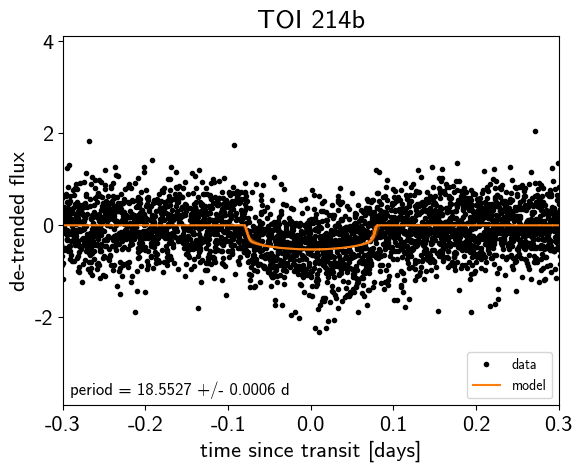

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we'll propagate the constraint on the radius ratio to a constraint on the physical radius of the planet using the stellar radius constraint from the TOI list (if provided).
We also plot the impact parameter constraints on this plot (remember that we're using circular orbits).

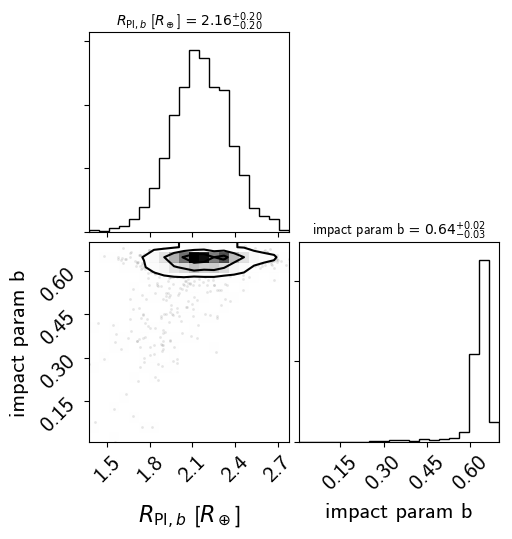

In [11]:
ror_samps = trace["r"]
r_star_samps = toi_r_star + toi_r_star_err * np.random.randn(len(ror_samps))
r_pl = ror_samps * r_star_samps[:, None] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

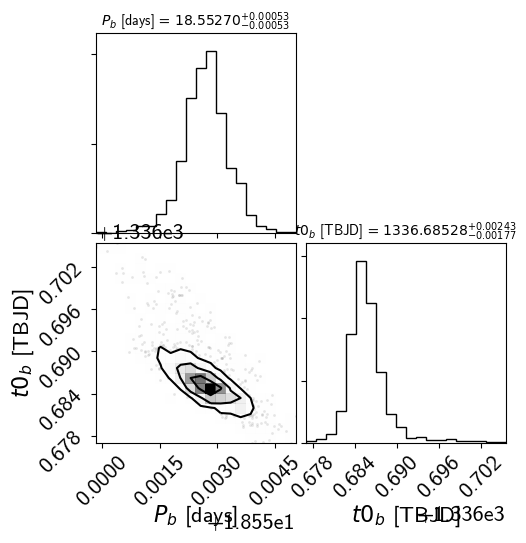

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [13]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [14]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [15]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3